## Downloading and loading data

In [1]:
# @title Kaggle Competition Data Downloading  { display-mode: "form",run :"auto" }
# @markdown Put the competition name

project_name = 'playground-series-s4e1'  # @param {type: "string"}


from google.colab import userdata
from IPython import display
token = {"username":userdata.get("Kaggle_Username"),"key":userdata.get("Kaggle")}
import os, json
os.environ['KAGGLE_CONFIG_DIR']='.'
with open('kaggle.json', "w") as f:
    json.dump(token, f)
!chmod 600 ./kaggle.json
!kaggle competitions download -c $project_name
project_name += ".zip"
!unzip $project_name && rm $project_name
display.clear_output()
print("Files have been downloaded!")

Files have been downloaded!


In [2]:
!gdown 1TirpUEzc7Qg0ioKY1gpwZd7BZTTp3p8C

Downloading...
From: https://drive.google.com/uc?id=1TirpUEzc7Qg0ioKY1gpwZd7BZTTp3p8C
To: /content/Churn_Modelling.csv
100% 685k/685k [00:00<00:00, 118MB/s]


In [3]:
!pip install optuna-dashboard optuna
!pip install catboost
display.clear_output()

In [4]:
# @title Create beep sound  { display-mode: "form",run :"auto" }

!sudo apt install portaudio19-dev
!pip install pydub
!pip install pyaudio
from pydub import AudioSegment
from pydub.generators import Sine
from pydub.playback import play
from IPython.display import Audio,display as dis

# Define frequencies for notes
notes = {'C': 261.63,
         'D': 293.66,
         'E': 329.63,
         'S': 0,  # Silence
         'F': 349.23,
         'G': 392.00,
         'A': 440.00,
         'B': 493.88}

melody = 'CDEFGSGSAAAAGSAAAAGSFFFFESESDDDDCCDEFGSGSAAAAGSAAAAGSFFFFESESDDDDC'

# Create a function to generate audio for a given note
def generate_audio(note, duration):
    if note == 'S':  # Silence
        return AudioSegment.silent(duration=duration)
    else:
        return Sine(note).to_audio_segment(duration=duration,volume=-15)

# Save the melody as a file
output_file = 'output.wav'
melody_audio = AudioSegment.silent(duration=1)

for note in melody:
    sound = generate_audio(notes[note], 500)
    melody_audio += sound

melody_audio.export(output_file, format="wav")
# Display the audio file path

display.clear_output()

### Importing Important Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson,kstest, shapiro
from IPython.display import Audio,display as dis
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_score, f1_score, recall_score,
                             roc_auc_score, roc_curve, auc
                             )

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import VALID_METRICS

from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              BaggingClassifier, RandomForestClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier,
                              StackingClassifier
                              )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier

In [7]:
import optuna
import tensorflow as tf


In [8]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.io as pio
pio.renderers.default = "colab"
pyo.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

### Important Functions

In [9]:
def preprocessing_method_1(dataframe,train=True):

    temp = pd.pivot_table(dataframe,values='Exited',index=['id'],
            columns=['Geography'],aggfunc='count',fill_value=0).reset_index()
    temp.columns = ['id', 'Is_France', 'Is_Germany', 'Is_Spain']

    df = pd.merge(dataframe, temp, on='id').drop('Exited', axis=1)

    df['Gender_F'] = df['Gender'].map({'Female':1,"Male":0})

    temp = pd.pivot_table(dataframe,values='Exited',index=['id'],
        columns=['NumOfProducts'],aggfunc='count',fill_value=0).reset_index()
    temp.columns = ['id', 'No_prd_1', 'No_prd_2', 'No_prd_3', 'No_prd_4']
    df = pd.merge(df, temp, on='id')

    temp = pd.pivot_table(dataframe,values='Exited',index=['id'],
        columns=['Tenure'],aggfunc='count',fill_value=0).reset_index()
    temp.columns = ['id', 'Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3',
                    'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7',
                    'Tenure_8', 'Tenure_9', 'Tenure_10',
                    ]
    df = pd.merge(df, temp, on='id')

    drop_cols = set(['id', 'CustomerId', 'Surname', 'Geography',
                     'Gender', 'NumOfProducts','Tenure']).intersection(df.columns)
    df['Exited'] = dataframe['Exited']
    if train:
        return df.drop(drop_cols, axis=1).drop_duplicates()
    else:
        return df.drop(drop_cols, axis=1)


def preprocessing_method_2(dataframe):
    df = dataframe.copy()
    df['Geography'] = df['Geography'].map({'France':1,'Germany':2,'Spain':3})
    df['Gender'] = df['Gender'].map({'Female':1,"Male":0})
    drop_cols = set(['id', 'CustomerId', 'Surname',]).intersection(df.columns)

    return df.drop(drop_cols, axis=1).drop_duplicates()

def plot_auc_roc(clf, X,Y):
    y_prob = clf.predict_proba(X)[:, 1]
    roc_auc = roc_auc_score(Y, y_prob)
    print(f"AUC-ROC: {roc_auc}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(Y, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_auc(clf, X,Y):
    # Calculate y_pred
    y_pred = clf.predict(X)
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(Y, y_pred)

    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def score(X,Y,clf):
    y_prob = clf.predict(np.array(X))
    roc_auc = roc_auc_score(Y, y_prob)
    print(f"AUC-ROC: {roc_auc}")

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(Y, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC-ROC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def beep(output_file='output.wav'):
    dis(Audio(output_file,autoplay=True))

### Loading the data

In [10]:
df_train = pd.read_csv("train.csv")
df_train.head()

id  CustomerId         Surname  CreditScore Geography Gender   Age  Tenure  \
0   0    15674932  Okwudilichukwu          668    France   Male  33.0       3   
1   1    15749177   Okwudiliolisa          627    France   Male  33.0       1   
2   2    15694510           Hsueh          678    France   Male  40.0      10   
3   3    15741417             Kao          581    France   Male  34.0       2   
4   4    15766172       Chiemenam          716     Spain   Male  33.0       5   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              2        1.0             0.0        181449.97   
1       0.00              2        1.0             1.0         49503.50   
2       0.00              2        1.0             0.0        184866.69   
3  148882.54              1        1.0             1.0         84560.88   
4       0.00              2        1.0             1.0         15068.83   

   Exited  
0       0  
1       0  
2       0  
3       0  
4       0

In [11]:
df_extra = pd.read_csv("Churn_Modelling.csv").drop_duplicates()
df_extra.columns = df_train.columns
df_extra.head()

id  CustomerId   Surname  CreditScore Geography  Gender   Age  Tenure  \
0   1    15634602  Hargrave          619    France  Female  42.0       2   
1   2    15647311      Hill          608     Spain  Female  41.0       1   
2   3    15619304      Onio          502    France  Female  42.0       8   
3   4    15701354      Boni          699    France  Female  39.0       1   
4   5    15737888  Mitchell          850     Spain  Female  43.0       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1        1.0             1.0        101348.88   
1   83807.86              1        0.0             1.0        112542.58   
2  159660.80              3        1.0             0.0        113931.57   
3       0.00              2        0.0             0.0         93826.63   
4  125510.82              1        NaN             1.0         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4       0

In [12]:
df_1 = preprocessing_method_1(df_train)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(df_1.drop('Exited', axis=1))
y_train = df_1['Exited']
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=.25, random_state=42)

## Data Visualization

In [ ]:
df_train.shape

(165034, 14)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [ ]:
df_train.nunique()

id                 165034
CustomerId          23221
Surname              2797
CreditScore           457
Geography               3
Gender                  2
Age                    71
Tenure                 11
Balance             30075
NumOfProducts           4
HasCrCard               2
IsActiveMember          2
EstimatedSalary     55298
Exited                  2
dtype: int64

From above, we can observe that a customer has different number of id, i.e. bank accounts.

### Query-1: Number of diiferent accounts for every customer id

In [ ]:
temp =df_train.groupby('CustomerId').agg({
    'id' : 'count',
    'Exited': ['sum',  'mean'],
})
temp.columns = ['Total_acc_no', 'Exited', 'Per_exited']

In [ ]:
temp = temp.sort_values('Total_acc_no', ascending= False)
temp

Total_acc_no  Exited  Per_exited
CustomerId                                  
15682355             121      33    0.272727
15570194              99      20    0.202020
15585835              98      24    0.244898
15595588              91      17    0.186813
15648067              90      26    0.288889
...                  ...     ...         ...
15641625               1       1    1.000000
15641624               1       0    0.000000
15641621               1       0    0.000000
15641620               1       0    0.000000
15691451               1       0    0.000000

[23221 rows x 3 columns]

In [ ]:
temp.describe(percentiles=[.25, .5, .67, .75, .90, .96, .99, .999])

Total_acc_no        Exited    Per_exited
count  23221.000000  23221.000000  23221.000000
mean       7.107101      1.503854      0.210379
std        9.956665      2.385671      0.294554
min        1.000000      0.000000      0.000000
25%        1.000000      0.000000      0.000000
50%        2.000000      1.000000      0.100000
67%        6.000000      1.000000      0.231319
75%       10.000000      2.000000      0.300000
90%       20.000000      5.000000      0.600000
96%       30.000000      7.000000      1.000000
99%       45.000000     11.000000      1.000000
99.9%     72.780000     17.000000      1.000000
max      121.000000     33.000000      1.000000

#### Visualization of different category customer

In [ ]:
fig = px.histogram(temp,x=['Total_acc_no'])
fig.update_layout(bargap=.2)
fig.show(renderer='colab')

In [ ]:
g1 = temp[temp['Total_acc_no']>60]
g1

Total_acc_no  Exited  Per_exited
CustomerId                                  
15682355             121      33    0.272727
15570194              99      20    0.202020
15585835              98      24    0.244898
15595588              91      17    0.186813
15648067              90      26    0.288889
...                  ...     ...         ...
15592761              62      17    0.274194
15665760              61      13    0.213115
15691823              61       8    0.131148
15785819              61       8    0.131148
15706799              61      16    0.262295

[70 rows x 3 columns]

In [ ]:
g1.describe()

Total_acc_no     Exited  Per_exited
count     70.000000  70.000000   70.000000
mean      71.885714  15.314286    0.212154
std       11.319526   4.626774    0.050372
min       61.000000   8.000000    0.126984
25%       63.000000  12.000000    0.177266
50%       69.000000  15.000000    0.203012
75%       78.750000  18.000000    0.246779
max      121.000000  33.000000    0.355263

In [ ]:
temp[(temp['Total_acc_no']>=45)&((temp['Total_acc_no']<=72))]

Total_acc_no  Exited  Per_exited
CustomerId                                  
15656937              72      18    0.250000
15686957              72      15    0.208333
15656901              72      17    0.236111
15654574              70      18    0.257143
15676521              70      11    0.157143
...                  ...     ...         ...
15626452              45       7    0.155556
15704581              45       9    0.200000
15777784              45      11    0.244444
15803378              45       6    0.133333
15591711              45       7    0.155556

[231 rows x 3 columns]

In [ ]:
temp[(temp['Total_acc_no']>=45)&((temp['Total_acc_no']<=60))].describe()

Total_acc_no      Exited  Per_exited
count    185.000000  185.000000  185.000000
mean      50.816216   10.610811    0.208738
std        4.426791    3.310046    0.063232
min       45.000000    2.000000    0.042553
25%       47.000000    8.000000    0.160714
50%       50.000000   10.000000    0.204082
75%       54.000000   13.000000    0.255319
max       60.000000   19.000000    0.347826

In [ ]:
df_train[df_train['CustomerId']==15773898]

id  CustomerId      Surname  CreditScore Geography  Gender   Age  \
8172      8172    15773898        Mazzi          754    France  Female  35.0   
30654    30654    15773898     Onwubiko          539     Spain  Female  51.0   
31418    31418    15773898  Chukwujekwu          718    France    Male  48.0   
41512    41512    15773898      Fanucci          543    France  Female  36.0   
42786    42786    15773898      Fanucci          583     Spain  Female  35.0   
44519    44519    15773898     Lucciano          676     Spain    Male  26.0   
56631    56631    15773898   Chidiebere          663   Germany  Female  45.0   
67969    67969    15773898       Ch'ien          711   Germany  Female  49.0   
83691    83691    15773898   Olisaemeka          663    France  Female  33.0   
85401    85401    15773898        Ts'ui          661    France  Female  36.0   
130805  130805    15773898       Pisano          711    France    Male  32.0   
132921  132921    15773898         T'ao          703    France  Female  56.0   
157088  157088    15773898        P'eng          684    France  Female  36.0   

        Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
8172         7       0.00              2        1.0             1.0   
30654        3       0.00              1        0.0             1.0   
31418        5  154740.97              1        0.0             1.0   
41512        5       0.00              2        0.0             1.0   
42786        8       0.00              1        1.0             0.0   
44519        3       0.00              2        1.0             1.0   
56631        4  121355.53              1        1.0             0.0   
67969        9  152888.56              1        0.0             0.0   
83691        3       0.00              2        0.0             0.0   
85401        6       0.00              2        1.0             1.0   
130805       7       0.00              2        1.0             1.0   
132921       8       0.00              1        1.0             0.0   
157088       8       0.00              2        1.0             1.0   

        EstimatedSalary  Exited  
8172          131083.90       0  
30654         145557.83       1  
31418         184842.71       1  
41512          55775.52       0  
42786         116692.80       0  
44519          45956.25       0  
56631         168816.53       1  
67969          68879.35       1  
83691          38772.61       0  
85401         162501.65       0  
130805        126441.33       0  
132921        182076.41       1  
157088         66462.82       0

Reason of removing customerid is that customerid is not unique unexpectedly.

### Query-2: Does geography have effect on churning?

$H_0$ : The effect of geography on churning is equivalent.

**Significance level = 5%**

In [ ]:
temp = pd.crosstab(df_train['Exited'],df_train['Geography'])
temp

Geography  France  Germany  Spain
Exited                           
0           78643    21492  29978
1           15572    13114   6235

In [ ]:
from scipy.stats import chi2_contingency
chi2_contingency(temp)

Chi2ContingencyResult(statistic=7358.673765244894, pvalue=0.0, dof=2, expected_freq=array([[74279.21697953, 27283.41116376, 28550.37185671],
       [19935.78302047,  7322.58883624,  7662.62814329]]))

In [ ]:
# Pearson's chi-squared statistic
chi2_contingency(temp, lambda_= 'pearson')

Chi2ContingencyResult(statistic=7358.673765244894, pvalue=0.0, dof=2, expected_freq=array([[74279.21697953, 27283.41116376, 28550.37185671],
       [19935.78302047,  7322.58883624,  7662.62814329]]))

In [ ]:
# G Test
chi2_contingency(temp, lambda_= 'log-likelihood')

Chi2ContingencyResult(statistic=6667.230513742703, pvalue=0.0, dof=2, expected_freq=array([[74279.21697953, 27283.41116376, 28550.37185671],
       [19935.78302047,  7322.58883624,  7662.62814329]]))

In [ ]:
# Freeman-Tukey statistic
chi2_contingency(temp, lambda_= 'freeman-tukey')

Chi2ContingencyResult(statistic=6420.768539311512, pvalue=0.0, dof=2, expected_freq=array([[74279.21697953, 27283.41116376, 28550.37185671],
       [19935.78302047,  7322.58883624,  7662.62814329]]))

In [ ]:
# Modified log-likelihood ratio
chi2_contingency(temp, lambda_= 'mod-log-likelihood')

Chi2ContingencyResult(statistic=6228.223336932911, pvalue=0.0, dof=2, expected_freq=array([[74279.21697953, 27283.41116376, 28550.37185671],
       [19935.78302047,  7322.58883624,  7662.62814329]]))

In [ ]:
# Neyman’s statistic
chi2_contingency(temp, lambda_= 'neyman')

Chi2ContingencyResult(statistic=5978.092848170603, pvalue=0.0, dof=2, expected_freq=array([[74279.21697953, 27283.41116376, 28550.37185671],
       [19935.78302047,  7322.58883624,  7662.62814329]]))

In [ ]:
# The power recommended in
chi2_contingency(temp, lambda_= 'cressie-read')

Chi2ContingencyResult(statistic=7095.013677879094, pvalue=0.0, dof=2, expected_freq=array([[74279.21697953, 27283.41116376, 28550.37185671],
       [19935.78302047,  7322.58883624,  7662.62814329]]))

In [ ]:
if chi2_contingency(temp).pvalue< 0.05:
    print("We reject null hypothesis.")
else:
    print("We failed too reject null hypothesis.")

We reject null hypothesis.


**Conclusion:** Geography will be considered in our feature set.

### Query-3: Does gender have effect on churning?

$H_0$ : The effect of gender on churning is equivalent.

**Significance level = 5%**

In [ ]:
temp = pd.crosstab(df_train['Exited'], df_train['Gender'])
temp

Gender  Female   Male
Exited               
0        51779  78334
1        20105  14816

In [ ]:
p_value = chi2_contingency(temp).pvalue
if p_value < 0.05:
    print(f"We reject null hypothesis. p value: {p_value}")
else:
    print(f"We failed too reject null hypothesis. p value: {p_value}.")

We reject null hypothesis. p value: 0.0


### Query-4: Does credit card have effect on churning?

$H_0$ : The effect of credit card on churning is equivalent.

**Significance level = 5%**

In [ ]:
temp = pd.crosstab(df_train['Exited'], df_train['HasCrCard'])
temp

HasCrCard    0.0    1.0
Exited                 
0          31371  98742
1           9235  25686

In [ ]:
p_value = chi2_contingency(temp).pvalue
if p_value < 0.05:
    print(f"We reject null hypothesis. p value: {p_value}")
else:
    print(f"We failed too reject null hypothesis. p value: {p_value}.")

We reject null hypothesis. p value: 2.522692566848213e-19


### Query-5: Does active membership have effect on churning?

$H_0$ : The effect of active membeship on churning is equivalent.

**Significance level = 5%**

In [ ]:
temp = pd.crosstab(df_train['Exited'], df_train['HasCrCard'])
temp

HasCrCard    0.0    1.0
Exited                 
0          31371  98742
1           9235  25686

In [ ]:
p_value = chi2_contingency(temp).pvalue
if p_value < 0.05:
    print(f"We reject null hypothesis. p value: {p_value}")
else:
    print(f"We failed too reject null hypothesis. p value: {p_value}.")

We reject null hypothesis. p value: 2.522692566848213e-19


### Query-6: Does number of products have effect on churning?

$H_0$ : The effect of number of products on churning is equivalent.

**Significance level = 5%**

In [ ]:
temp = pd.crosstab(df_train['Exited'], df_train['NumOfProducts'])
temp

NumOfProducts      1      2     3    4
Exited                                
0              50516  79198   340   59
1              26858   5093  2554  416

In [ ]:
p_value = chi2_contingency(temp).pvalue
if p_value < 0.05:
    print(f"We reject null hypothesis. p value: {p_value}")
else:
    print(f"We failed too reject null hypothesis. p value: {p_value}.")

We reject null hypothesis. p value: 0.0


### Query-7: Does has Age has any effect on churning?

In [ ]:
df_train['Age'].nunique()

71

In [ ]:
fig = px.histogram(df_train, x=['Age'])
fig.update_layout(bargap=.2)
fig.show(renderer='colab')

### Action-1: one hot encoding category variables and preprocessing

In [ ]:
temp = pd.pivot_table(df_train,values='Exited',index=['id'],columns=['Geography'],aggfunc='count',fill_value=0).reset_index()
temp.columns = ['id', 'Is_France', 'Is_Germany', 'Is_Spain']
temp

id  Is_France  Is_Germany  Is_Spain
0            0          1           0         0
1            1          1           0         0
2            2          1           0         0
3            3          1           0         0
4            4          0           0         1
...        ...        ...         ...       ...
165029  165029          0           0         1
165030  165030          1           0         0
165031  165031          1           0         0
165032  165032          0           0         1
165033  165033          1           0         0

[165034 rows x 4 columns]

In [ ]:
df = pd.merge(df_train, temp, on='id')
df

id  CreditScore Geography  Gender   Age  Tenure    Balance  \
0            0          668    France    Male  33.0       3       0.00   
1            1          627    France    Male  33.0       1       0.00   
2            2          678    France    Male  40.0      10       0.00   
3            3          581    France    Male  34.0       2  148882.54   
4            4          716     Spain    Male  33.0       5       0.00   
...        ...          ...       ...     ...   ...     ...        ...   
165029  165029          667     Spain  Female  33.0       2       0.00   
165030  165030          792    France    Male  35.0       3       0.00   
165031  165031          565    France    Male  31.0       5       0.00   
165032  165032          554     Spain  Female  30.0       7  161533.00   
165033  165033          850    France    Male  31.0       1       0.00   

        NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0                   2        1.0             0.0        181449.97       0   
1                   2        1.0             1.0         49503.50       0   
2                   2        1.0             0.0        184866.69       0   
3                   1        1.0             1.0         84560.88       0   
4                   2        1.0             1.0         15068.83       0   
...               ...        ...             ...              ...     ...   
165029              1        1.0             1.0        131834.75       0   
165030              1        0.0             0.0        131834.45       0   
165031              1        1.0             1.0        127429.56       0   
165032              1        0.0             1.0         71173.03       0   
165033              1        1.0             0.0         61581.79       1   

        Is_France  Is_Germany  Is_Spain  
0               1           0         0  
1               1           0         0  
2               1           0         0  
3               1           0         0  
4               0           0         1  
...           ...         ...       ...  
165029          0           0         1  
165030          1           0         0  
165031          1           0         0  
165032          0           0         1  
165033          1           0         0  

[165034 rows x 15 columns]

In [ ]:
temp = pd.pivot_table(df_train,values='Exited',index=['id'],columns=['NumOfProducts'],aggfunc='count',fill_value=0).reset_index()
temp.columns = ['id', 'No_prd_1', 'No_prd_2', 'No_prd_3', 'No_prd_4']
temp

id  No_prd_1  No_prd_2  No_prd_3  No_prd_4
0            0         0         1         0         0
1            1         0         1         0         0
2            2         0         1         0         0
3            3         1         0         0         0
4            4         0         1         0         0
...        ...       ...       ...       ...       ...
165029  165029         1         0         0         0
165030  165030         1         0         0         0
165031  165031         1         0         0         0
165032  165032         1         0         0         0
165033  165033         1         0         0         0

[165034 rows x 5 columns]

In [ ]:
df = pd.merge(df, temp, on='id')
df

id  CreditScore Geography  Gender   Age  Tenure    Balance  \
0            0          668    France    Male  33.0       3       0.00   
1            1          627    France    Male  33.0       1       0.00   
2            2          678    France    Male  40.0      10       0.00   
3            3          581    France    Male  34.0       2  148882.54   
4            4          716     Spain    Male  33.0       5       0.00   
...        ...          ...       ...     ...   ...     ...        ...   
165029  165029          667     Spain  Female  33.0       2       0.00   
165030  165030          792    France    Male  35.0       3       0.00   
165031  165031          565    France    Male  31.0       5       0.00   
165032  165032          554     Spain  Female  30.0       7  161533.00   
165033  165033          850    France    Male  31.0       1       0.00   

        NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0                   2        1.0             0.0        181449.97       0   
1                   2        1.0             1.0         49503.50       0   
2                   2        1.0             0.0        184866.69       0   
3                   1        1.0             1.0         84560.88       0   
4                   2        1.0             1.0         15068.83       0   
...               ...        ...             ...              ...     ...   
165029              1        1.0             1.0        131834.75       0   
165030              1        0.0             0.0        131834.45       0   
165031              1        1.0             1.0        127429.56       0   
165032              1        0.0             1.0         71173.03       0   
165033              1        1.0             0.0         61581.79       1   

        Is_France  Is_Germany  Is_Spain  No_prd_1  No_prd_2  No_prd_3  \
0               1           0         0         0         1         0   
1               1           0         0         0         1         0   
2               1           0         0         0         1         0   
3               1           0         0         1         0         0   
4               0           0         1         0         1         0   
...           ...         ...       ...       ...       ...       ...   
165029          0           0         1         1         0         0   
165030          1           0         0         1         0         0   
165031          1           0         0         1         0         0   
165032          0           0         1         1         0         0   
165033          1           0         0         1         0         0   

        No_prd_4  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
165029         0  
165030         0  
165031         0  
165032         0  
165033         0  

[165034 rows x 19 columns]

In [ ]:
df_1 = preprocessing_method_1(df_train)
df_1

CreditScore   Age    Balance  HasCrCard  IsActiveMember  \
0               668  33.0       0.00        1.0             0.0   
1               627  33.0       0.00        1.0             1.0   
2               678  40.0       0.00        1.0             0.0   
3               581  34.0  148882.54        1.0             1.0   
4               716  33.0       0.00        1.0             1.0   
...             ...   ...        ...        ...             ...   
165029          667  33.0       0.00        1.0             1.0   
165030          792  35.0       0.00        0.0             0.0   
165031          565  31.0       0.00        1.0             1.0   
165032          554  30.0  161533.00        0.0             1.0   
165033          850  31.0       0.00        1.0             0.0   

        EstimatedSalary  Is_France  Is_Germany  Is_Spain  Gender_F  ...  \
0             181449.97          1           0         0         0  ...   
1              49503.50          1           0         0         0  ...   
2             184866.69          1           0         0         0  ...   
3              84560.88          1           0         0         0  ...   
4              15068.83          0           0         1         0  ...   
...                 ...        ...         ...       ...       ...  ...   
165029        131834.75          0           0         1         1  ...   
165030        131834.45          1           0         0         0  ...   
165031        127429.56          1           0         0         0  ...   
165032         71173.03          0           0         1         1  ...   
165033         61581.79          1           0         0         0  ...   

        Tenure_2  Tenure_3  Tenure_4  Tenure_5  Tenure_6  Tenure_7  Tenure_8  \
0              0         1         0         0         0         0         0   
1              0         0         0         0         0         0         0   
2              0         0         0         0         0         0         0   
3              1         0         0         0         0         0         0   
4              0         0         0         1         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
165029         1         0         0         0         0         0         0   
165030         0         1         0         0         0         0         0   
165031         0         0         0         1         0         0         0   
165032         0         0         0         0         0         1         0   
165033         0         0         0         0         0         0         0   

        Tenure_9  Tenure_10  Exited  
0              0          0       0  
1              0          0       0  
2              0          1       0  
3              0          0       0  
4              0          0       0  
...          ...        ...     ...  
165029         0          0       0  
165030         0          0       0  
165031         0          0       0  
165032         0          0       0  
165033         0          0       1  

[164911 rows x 26 columns]

In [ ]:
df_2 = preprocessing_method_2(df_train)
df_2

CreditScore  Geography  Gender   Age  Tenure    Balance  \
0               668          1       0  33.0       3       0.00   
1               627          1       0  33.0       1       0.00   
2               678          1       0  40.0      10       0.00   
3               581          1       0  34.0       2  148882.54   
4               716          3       0  33.0       5       0.00   
...             ...        ...     ...   ...     ...        ...   
165029          667          3       1  33.0       2       0.00   
165030          792          1       0  35.0       3       0.00   
165031          565          1       0  31.0       5       0.00   
165032          554          3       1  30.0       7  161533.00   
165033          850          1       0  31.0       1       0.00   

        NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0                   2        1.0             0.0        181449.97       0  
1                   2        1.0             1.0         49503.50       0  
2                   2        1.0             0.0        184866.69       0  
3                   1        1.0             1.0         84560.88       0  
4                   2        1.0             1.0         15068.83       0  
...               ...        ...             ...              ...     ...  
165029              1        1.0             1.0        131834.75       0  
165030              1        0.0             0.0        131834.45       0  
165031              1        1.0             1.0        127429.56       0  
165032              1        0.0             1.0         71173.03       0  
165033              1        1.0             0.0         61581.79       1  

[164911 rows x 11 columns]

### Dataviz-1:

In [ ]:
categorical_cols_1 =['HasCrCard', 'IsActiveMember',
                   'Is_France', 'Is_Germany', 'Is_Spain','Gender_F',
                   'No_prd_1', 'No_prd_2', 'No_prd_3', 'No_prd_4',
                   'Tenure_0', 'Tenure_1', 'Tenure_2', 'Tenure_3',
                    'Tenure_4', 'Tenure_5', 'Tenure_6', 'Tenure_7',
                    'Tenure_8', 'Tenure_9', 'Tenure_10','Exited'
                   ]
categorical_cols_2 =['HasCrCard', 'IsActiveMember', 'Geography',
                     'Gender','NumOfProducts', 'Tenure', 'Exited'
                   ]
numerical_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [ ]:
len(categorical_cols_1)+len(numerical_cols), len(categorical_cols_2)+len(numerical_cols)

(26, 11)

#### Boxplot of numerical columns

In [ ]:
fig = make_subplots(rows=2, cols=2)
for i in range(4):
    # fig.add_trace(px.box(df_1,y=numerical_cols[i]),row=i//2+1,col=i%2+1)
    fig.add_trace(go.Box(y=df_1[numerical_cols[i]], name=numerical_cols[i]),row=i//2+1,col=i%2+1)

fig.update_layout(title_text='Box plot of Numerical columns',height=800, width=1100)
fig.show(renderer='colab')

Output hidden; open in https://colab.research.google.com to view.

#### Boxplot of numerical columns based on churning

In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=numerical_cols)
for i in range(4):
    # fig.add_trace(px.box(df_1,y=numerical_cols[i]),row=i//2+1,col=i%2+1)
    fig.add_trace(go.Box(x=df_1['Exited'],y=df_1[numerical_cols[i]], name=numerical_cols[i]),row=i//2+1,col=i%2+1)

fig.update_layout(title_text='Box plot of Numerical columns based on churning',height=800, width=1100)
fig.show(renderer='colab')

Output hidden; open in https://colab.research.google.com to view.

#### Histogram of numerical columns

In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=numerical_cols)
for i in range(4):
    fig.add_trace(go.Histogram(x=df_1[numerical_cols[i]],
                               name=numerical_cols[i]),row=i//2+1,col=i%2+1)

fig.update_layout(title_text='Histogram of Numerical columns',height=800, width=1100)
fig.show(renderer='colab')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = make_subplots(rows=2, cols=2,subplot_titles=numerical_cols)
for i in range(4):
    fig.add_trace(go.Histogram(x=df_1[numerical_cols[i]],nbinsx=20
                               ,name=numerical_cols[i]),row=i//2+1,col=i%2+1)

fig.update_layout(title_text='Histogram of Numerical columns',
                  height=800, width=1100,bargap=.2)
fig.show(renderer='colab')

Output hidden; open in https://colab.research.google.com to view.

#### Countplot of categorical columns

In [ ]:
fig = px.histogram(df_2, x=categorical_cols_2[0])
fig.update_layout(bargap=.2)
fig.show(renderer='colab')

In [ ]:
fig = px.histogram(df_2, x=categorical_cols_2[1])
fig.update_layout(bargap=.2)
fig.show(renderer='colab')

In [ ]:
fig = px.histogram(df_2, x=categorical_cols_2[2])
fig.update_layout(bargap=.2)
fig.show(renderer='colab')

In [ ]:
fig = px.histogram(df_2, x=categorical_cols_2[3])
fig.update_layout(bargap=.2)
fig.show(renderer='colab')

In [ ]:
fig = px.histogram(df_2, x=categorical_cols_2[4])
fig.update_layout(bargap=.2)
fig.show(renderer='colab')

In [ ]:
fig = px.histogram(df_2, x=categorical_cols_2[5])
fig.update_layout(bargap=.2)
fig.show(renderer='colab')

In [ ]:
fig = px.histogram(df_2, x=categorical_cols_2[6])
fig.update_layout(bargap=.2)
fig.show(renderer='colab')

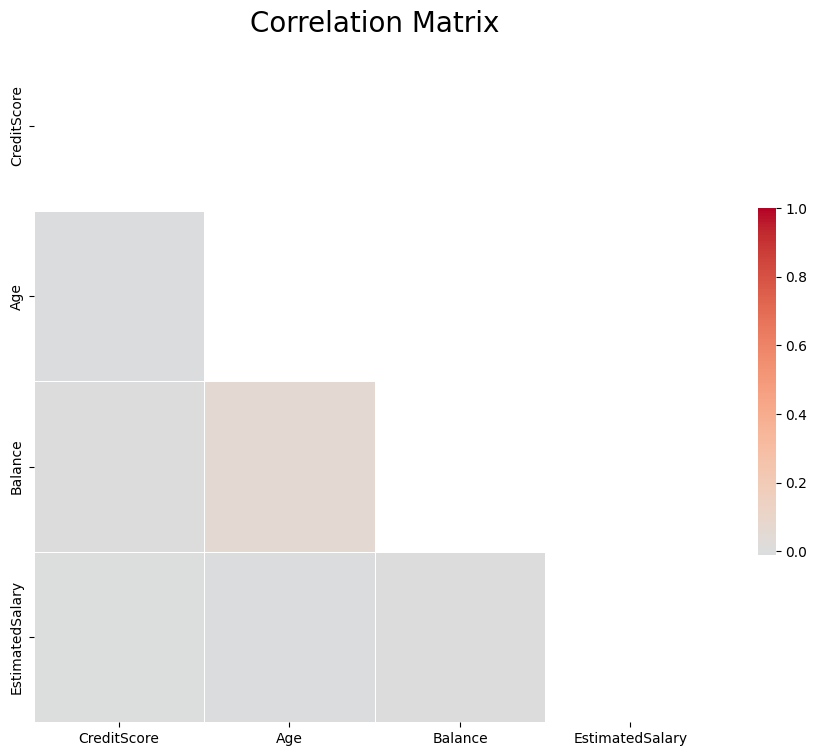

In [ ]:
corr = df_1[numerical_cols].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix', fontsize=20)
plt.savefig("Correlation matrix.png")
plt.show()

## Logistic Regression training

**Key observation:**
1. Score varies upon sparsity of data.
1. Score varies upon other scaler to robust scaler.
**Need to find:**
1. Should there be any effect of different method of cross-validation?

In [ ]:
# Does sparsity / one hot encoding have any effect on classification?
scaler = MinMaxScaler()
# scaler = RobustScaler()
x_train = scaler.fit_transform(df_1.drop('Exited', axis=1))
y_train = df_1['Exited']

In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr.score(x_train, y_train)

0.8563406928585722

In [ ]:
lr = LogisticRegression(penalty='l1', solver = 'liblinear')
lr.fit(x_train, y_train)
lr.score(x_train, y_train)

0.8563528206123303

In [ ]:
%%time
lr = LogisticRegression(penalty='l1', solver = 'liblinear')
lr.fit(x_train, y_train)
lr.score(x_train, y_train)

CPU times: user 47 s, sys: 0 ns, total: 47 s
Wall time: 49.7 s


0.8563528206123303

## Level-0 Algorithm Search

In [ ]:
df_1 = preprocessing_method_1(df_train)
scaler = MinMaxScaler()
# scaler = RobustScaler()
x_train = scaler.fit_transform(df_1.drop('Exited', axis=1))
y_train = df_1['Exited']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=.25, random_state=42)

In [ ]:
algos = [
        #  SVC(), NuSVC(),
         LinearSVC(),
         DecisionTreeClassifier(), ExtraTreeClassifier(),
         AdaBoostClassifier(), ExtraTreesClassifier(),
         BaggingClassifier(), RandomForestClassifier(),
         GradientBoostingClassifier(),
         HistGradientBoostingClassifier(),
         LGBMClassifier(), XGBClassifier(), XGBRFClassifier(),
         CatBoostClassifier()
         ]
names = list(map(lambda x: x.__class__.__name__, algos))


In [ ]:
%%time
history = { 'algo_name': names,
            'train_score' : [],
            'test_score' : [],
            'AUC_score'  : []
            }

for model in algos:
    print(f"{str(model)[:-2]} has started!")
    model.fit(X_train, Y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    history['train_score'].append(accuracy_score(Y_train, pred_train))
    history['test_score'].append(accuracy_score(Y_test, pred_test))
    try:
        y_prob = model.predict_proba(x_train)[:, 1]
        roc_auc = roc_auc_score(y_train, y_prob)
        history['AUC_score'].append(roc_auc)
    except Exception as e:
        history['AUC_score'].append(np.nan)

LinearSVC has started!
DecisionTreeClassifier has started!
ExtraTreeClassifier has started!
AdaBoostClassifier has started!
ExtraTreesClassifier has started!
BaggingClassifier has started!
RandomForestClassifier has started!
GradientBoostingClassifier has started!
HistGradientBoostingClassifier has started!
LGBMClassifier has started!
[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsam

### Result

In [ ]:
temp = pd.DataFrame(history)
temp['diff'] = temp['train_score'] - temp['test_score']
temp.sort_values('diff').reset_index(drop=True).to_csv("history.csv")
temp.sort_values('diff').reset_index(drop=True)

algo_name  train_score  test_score  AUC_score  \
0               AdaBoostClassifier     0.860660    0.859998   0.880439   
1       GradientBoostingClassifier     0.865398    0.864340   0.889539   
2                  XGBRFClassifier     0.860054    0.858349   0.883548   
3                        LinearSVC     0.855582    0.853813        NaN   
4   HistGradientBoostingClassifier     0.869505    0.865164   0.895591   
5                   LGBMClassifier     0.870047    0.865698   0.896082   
6               CatBoostClassifier     0.879579    0.864922   0.905247   
7                    XGBClassifier     0.882053    0.863200   0.909715   
8                BaggingClassifier     0.985584    0.847555   0.969477   
9           RandomForestClassifier     0.999741    0.858203   0.979960   
10            ExtraTreesClassifier     0.999766    0.849326   0.988890   
11          DecisionTreeClassifier     0.999766    0.799578   0.925866   
12             ExtraTreeClassifier     0.999766    0.795624   0.923315   

        diff  
0   0.000662  
1   0.001058  
2   0.001705  
3   0.001769  
4   0.004341  
5   0.004349  
6   0.014657  
7   0.018854  
8   0.138029  
9   0.141538  
10  0.150440  
11  0.200188  
12  0.204141

| algo_name |	train_score	| test_score | diff |
|-----------|---------------|------------|------|
|	AdaBoostClassifier|	0.860660	|0.859998|	0.000662
|	GradientBoostingClassifier	|0.865398	|0.864340	|0.001058
|	XGBRFClassifier|	0.860054	|0.858349	|0.001705
|	LinearSVC	|0.855582	|0.853813|	0.001769
|	HistGradientBoostingClassifier	|0.869303	|0.865261	|0.004042
|	LGBMClassifier	|0.870047	|0.865698	|0.004349
|	CatBoostClassifier |	0.879579	|0.864922|0.014657
|	XGBClassifier	|0.882053	|0.863200	|0.018854
|	BaggingClassifier	|0.985123	|0.848647|	0.136477
|	RandomForestClassifier	|0.999725|	0.857281|	0.142444
|	ExtraTreesClassifier	|0.999766|	0.850320|	0.149445
|	ExtraTreeClassifier	|0.999766|	0.799093|	0.200673
|	DecisionTreeClassifier	|0.999766|	0.798486|	0.201279

### DecisionTreeClassifier

In [ ]:
params = {
    'criterion': ['gini','entropy'],
    'max_depth': [ 5, 8, 10],
    'min_samples_split': [2, 5, 10,20],
    'max_features': ['sqrt', 'log2'],
    'ccp_alpha': [0, .01]
}
clf = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(clf, params, cv=3, scoring='roc_auc')
grid.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0, 0.01],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='roc_auc')

In [ ]:
grid.best_params_

{'ccp_alpha': 0,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 5}

In [ ]:
grid.score(X_train, Y_train), grid.score(X_test, Y_test)

(0.881135671628515, 0.8678442891325845)

In [ ]:
(0.8605224646879522 - 0.8576452896090035)

0.0028771750789486905

AUC-ROC: 0.8804495711808059


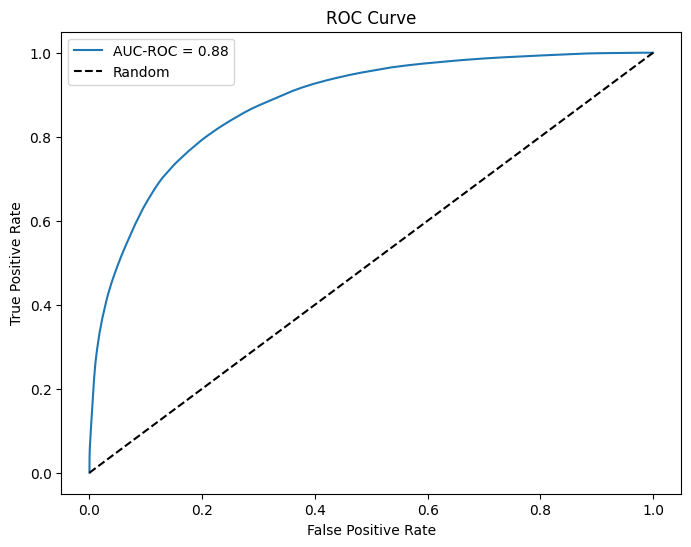

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
clf = DecisionTreeClassifier(
**{'ccp_alpha': 0,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 20,
 'random_state' : 42,
}
)

clf.fit(X_train, Y_train)


plot_auc_roc(clf, X_train,Y_train)

AUC-ROC: 0.8775001906477037


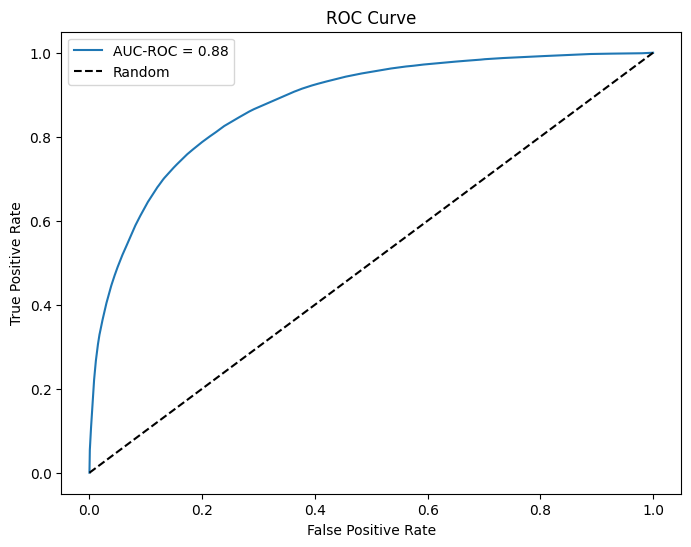

In [ ]:
plot_auc_roc(clf, x_train,y_train)

### GradientBoostingClassifier

#### GridSearch search optimization

In [ ]:
clf = GradientBoostingClassifier(random_state=42)
params = {
    'loss'  : ['log_loss', 'exponential'],
    'learning_rate': [.001, .01, .1],
    'criterion': [ 'friedman_mse', 'squared_error'],
    'min_samples_split' : [2, 5, 10],
}

grid = GridSearchCV(clf, params, cv=3, scoring='roc_auc',verbose=3)
grid.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'loss': ['log_loss', 'exponential'],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [ ]:
grid.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'exponential',
 'min_samples_split': 2}

In [ ]:
grid.score(X_train, Y_train), grid.score(X_test, Y_test)

(0.8901280752767975, 0.8879829902066897)

#### Optuna trial

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1,log=True),
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    }

    clf = GradientBoostingClassifier(random_state=42, **params)
    clf.fit(X_train, Y_train)

    y_prob = clf.predict_proba(X_train)[:, 1]
    roc_auc = roc_auc_score(Y_train, y_prob)

    return roc_auc

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


In [ ]:
# Print the best parameters and corresponding AUC-ROC score
print("Best Parameters:", study.best_params)
print("Best AUC-ROC Score:", study.best_value)

# Get the best model from the study
best_params = study.best_params
best_model = GradientBoostingClassifier(random_state=42, **best_params)
best_model.fit(X_train, Y_train)

# Predict probabilities on the test set using the best model
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC on the test set
roc_auc_test = roc_auc_score(Y_test, y_prob)
print("AUC-ROC on Test Set:", roc_auc_test)

Best Parameters: {'loss': 'exponential', 'learning_rate': 0.09960616152600678, 'criterion': 'squared_error', 'min_samples_split': 2}
Best AUC-ROC Score: 0.890214626070212
AUC-ROC on Test Set: 0.8880784174237548


In [ ]:
optuna.visualization.plot_optimization_history(study).show(renderer='colab')

In [ ]:
optuna.visualization.plot_slice(study).show(renderer='colab')

#### Final

**key observation**

1. Optuna trial is much faster than grid searh.
1. In this trial optimisation priority has been discovered.

In [ ]:
df_1 = preprocessing_method_1(df_train)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(df_1.drop('Exited', axis=1))
y_train = df_1['Exited']
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=.25, random_state=42)

In [ ]:
clf = GradientBoostingClassifier(n_estimators=200, random_state=42,
                                 criterion='squared_error',
                                learning_rate=0.09960616152600678,
                                loss='exponential', )
clf.fit(X_train,Y_train)

GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.09960616152600678,
                           loss='exponential', n_estimators=200,
                           random_state=42)

In [ ]:
clf.score(X_train, Y_train), clf.score(X_test, Y_test)

(0.8667399723486655, 0.8654312603085282)

AUC-ROC: 0.8916710242922645


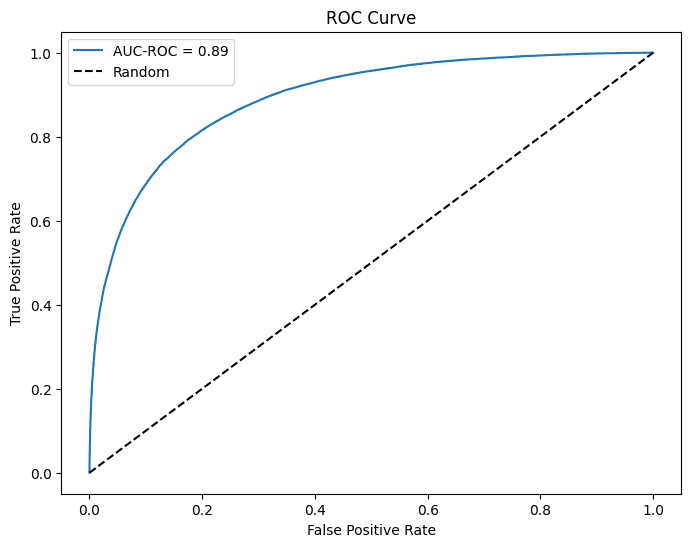

In [ ]:
plot_auc_roc(clf, x_train,y_train)

In [ ]:
confusion_matrix(y_train, clf.predict(x_train))

array([[123642,   6360],
       [ 15670,  19239]])

In [ ]:
abc = df_train.copy()
jkxxas = scaler.transform(preprocessing_method_1(df_train,train=False).drop('Exited',axis=1))
abc["Predicted_Exited"] = clf.predict(jkxxas)
abc['Predicted_proba'] = clf.predict_proba(jkxxas)[:,1]
abc.to_csv("Observation.csv",index=False)

In [ ]:
confusion_matrix(abc['Exited'], abc['Predicted_Exited'])

array([[123746,   6367],
       [ 15675,  19246]])

## Deep Learning Approach

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(np.array(Y_train).reshape(-1,1))
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(np.array(Y_test).reshape(-1,1))

# Create DataLoader for training set
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the binary classification model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(25, 256)
        self.relu = nn.ReLU()
        self.mid_1 = nn.Linear(256,512)
        self.relu_1 = nn.ReLU()
        self.mid_2 = nn.Linear(512,256)
        self.relu_2 = nn.ReLU()
        self.mid_3 = nn.Linear(256,16)
        self.relu_3 = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu_1(self.mid_1(x))
        x = self.relu_2(self.mid_2(x))
        x = self.relu_3(self.mid_3(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model, loss function, and optimizer
model = BinaryClassifier()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
+# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    print(f"epoch {epoch+1} has started!")
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.view(-1, 1).float())
        loss.backward()
        optimizer.step()

epoch 0 has started!
epoch 1 has started!
epoch 2 has started!
epoch 3 has started!
epoch 4 has started!
epoch 5 has started!
epoch 6 has started!
epoch 7 has started!
epoch 8 has started!
epoch 9 has started!
epoch 10 has started!
epoch 11 has started!
epoch 12 has started!
epoch 13 has started!
epoch 14 has started!
epoch 15 has started!
epoch 16 has started!
epoch 17 has started!
epoch 18 has started!
epoch 19 has started!
epoch 20 has started!
epoch 21 has started!
epoch 22 has started!
epoch 23 has started!
epoch 24 has started!
epoch 25 has started!
epoch 26 has started!
epoch 27 has started!
epoch 28 has started!
epoch 29 has started!
epoch 30 has started!
epoch 31 has started!
epoch 32 has started!
epoch 33 has started!
epoch 34 has started!
epoch 35 has started!
epoch 36 has started!
epoch 37 has started!
epoch 38 has started!
epoch 39 has started!
epoch 40 has started!
epoch 41 has started!
epoch 42 has started!
epoch 43 has started!
epoch 44 has started!
epoch 45 has started

In [ ]:
# Evaluate the model on the test set
with torch.no_grad():
    outputs = model(X_test_tensor.float())
    predictions = (outputs > 0.5).float()
    accuracy = (predictions == y_test_tensor.view(-1, 1).float()).sum().item() / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 85.51%


## Perceptrons

In [ ]:
from mlxtend.classifier import Perceptron
from mlxtend.plotting import plot_decision_regions

In [ ]:
len(X_train)

123683

In [ ]:
ppn = Perceptron(eta=.001, epochs=10, random_seed=42, print_progress=3)
ppn.fit(np.array(X_train), np.array(Y_train))

Iteration: 10/10 | Cost 26512.00 | Elapsed: 0:00:37 | ETA: 0:00:00

In [ ]:
confusion_matrix(Y_train, ppn.predict(np.array(X_train)))

array([[84752, 12829],
       [11771, 14331]])

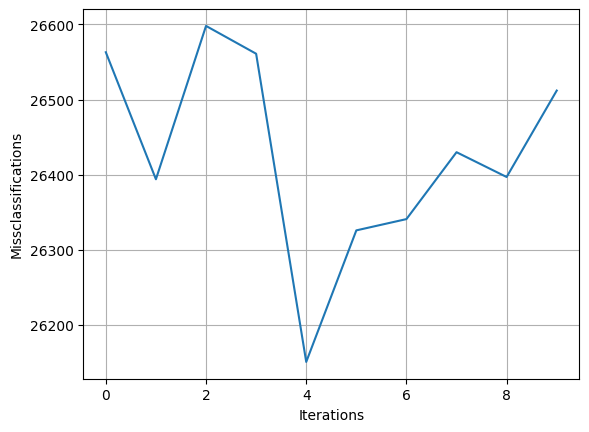

In [ ]:
plt.plot(range(len(ppn.cost_)), ppn.cost_)
plt.xlabel('Iterations')
plt.ylabel('Missclassifications')
plt.grid()
plt.show()

AUC-ROC: 0.7023138896640246


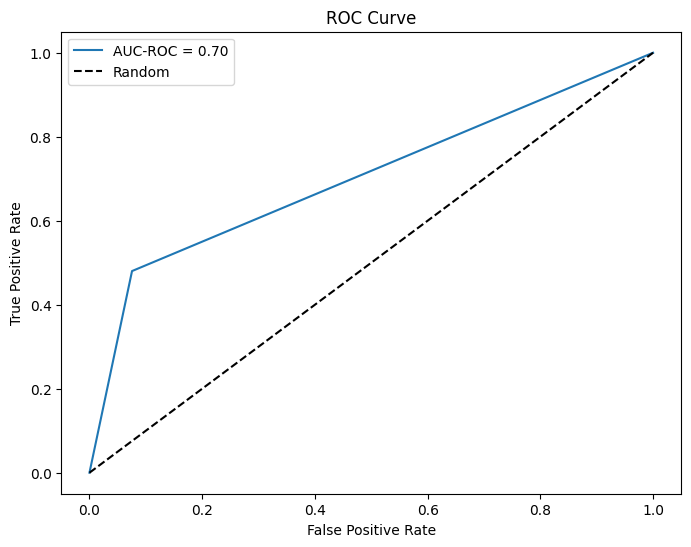

In [ ]:
score(X_train,Y_train, ppn)

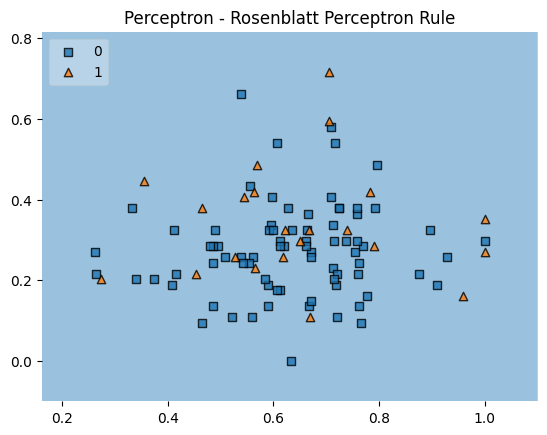

In [ ]:
dict_map= dict(zip(range(25),[0]*25))
dict_map[0] = 1
dict_map[1] = 0
plot_decision_regions(np.array(X_train)[:100],np.array(Y_train)[:100], clf=ppn,
                      filler_feature_values=dict_map,
                      filler_feature_ranges= dict(zip(range(25),[10]*25)),
                      zoom_factor=10,
                      legend=2)
plt.title('Perceptron - Rosenblatt Perceptron Rule')
plt.show()

## Tensorflow Model

### Model 01: Over trained model (Overfitted)

In [ ]:
import tensorflow as tf
# Build the heavily dense TensorFlow Model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output layer
])

# Compile the Model with ROC-AUC metric
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='roc_auc')])

In [ ]:
# Train the Model
history = model_1.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
3093/3093 [==============================] - 10s 3ms/step - loss: 0.3212 - roc_auc: 0.8876 - val_loss: 0.3259 - val_roc_auc: 0.8882
Epoch 2/50
3093/3093 [==============================] - 8s 3ms/step - loss: 0.3208 - roc_auc: 0.8878 - val_loss: 0.3243 - val_roc_auc: 0.8866
Epoch 3/50
3093/3093 [==============================] - 13s 4ms/step - loss: 0.3201 - roc_auc: 0.8884 - val_loss: 0.3234 - val_roc_auc: 0.8869
Epoch 4/50
3093/3093 [==============================] - 10s 3ms/step - loss: 0.3198 - roc_auc: 0.8886 - val_loss: 0.3235 - val_roc_auc: 0.8867
Epoch 5/50
3093/3093 [==============================] - 9s 3ms/step - loss: 0.3193 - roc_auc: 0.8889 - val_loss: 0.3224 - val_roc_auc: 0.8880
Epoch 6/50
3093/3093 [==============================] - 8s 3ms/step - loss: 0.3188 - roc_auc: 0.8893 - val_loss: 0.3229 - val_roc_auc: 0.8873
Epoch 7/50
3093/3093 [==============================] - 10s 3ms/step - loss: 0.3182 - roc_auc: 0.8898 - val_loss: 0.3234 - val_roc_auc: 0.8869
Ep

In [ ]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
train_score = history.history['roc_auc']
val_score = history.history['val_roc_auc']

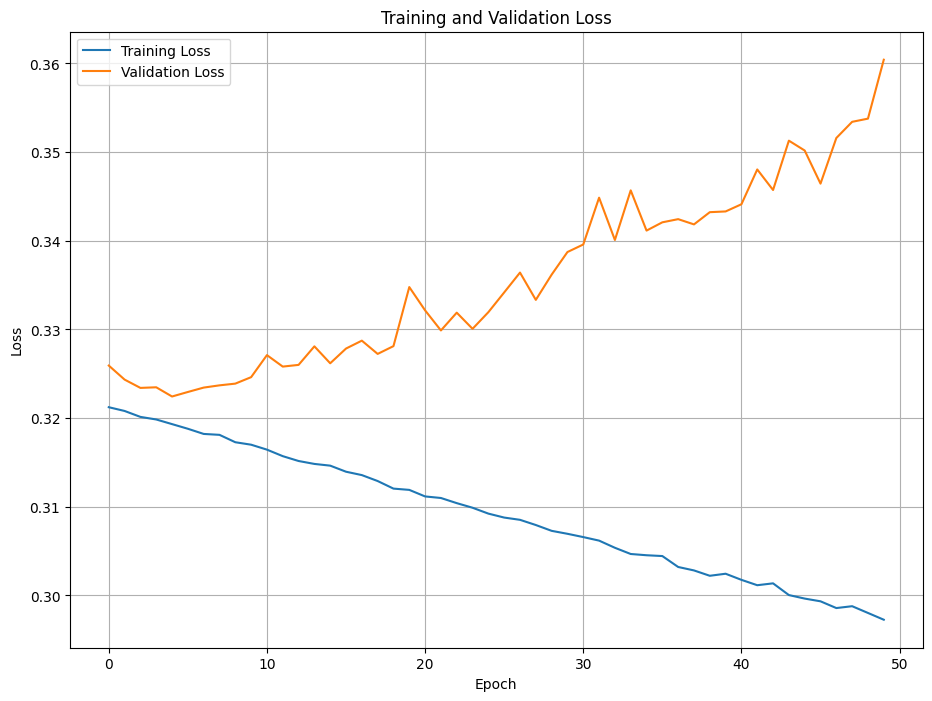

In [ ]:
plt.figure(figsize=(11,8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

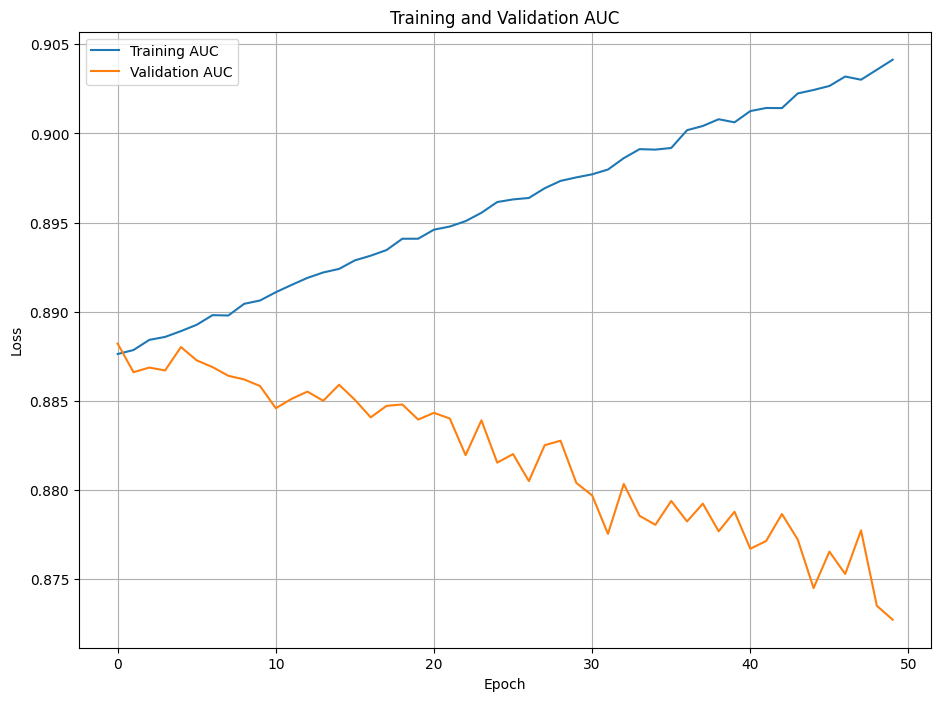

In [ ]:
plt.figure(figsize=(11,8))
plt.plot(history.history['roc_auc'], label='Training AUC')
plt.plot(history.history['val_roc_auc'], label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

### Model 02: Semi trained

In [ ]:
import tensorflow as tf

# Build the TensorFlow Model with Dropout for Regularization
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output layer
])

# Specify the learning rate for the Adam optimizer
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the Model with ROC-AUC metric and the specified optimizer
model_2.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='roc_auc')])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3328      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

In [ ]:
# Train the Model
history = model_2.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
3093/3093 [==============================] - 12s 4ms/step - loss: 0.3538 - roc_auc: 0.8657 - val_loss: 0.3305 - val_roc_auc: 0.8856
Epoch 2/50
3093/3093 [==============================] - 10s 3ms/step - loss: 0.3543 - roc_auc: 0.8663 - val_loss: 0.3289 - val_roc_auc: 0.8856
Epoch 3/50
3093/3093 [==============================] - 11s 4ms/step - loss: 0.3543 - roc_auc: 0.8666 - val_loss: 0.3282 - val_roc_auc: 0.8857
Epoch 4/50
3093/3093 [==============================] - 10s 3ms/step - loss: 0.3536 - roc_auc: 0.8668 - val_loss: 0.3272 - val_roc_auc: 0.8859
Epoch 5/50
3093/3093 [==============================] - 9s 3ms/step - loss: 0.3529 - roc_auc: 0.8668 - val_loss: 0.3284 - val_roc_auc: 0.8857
Epoch 6/50
3093/3093 [==============================] - 11s 4ms/step - loss: 0.3535 - roc_auc: 0.8666 - val_loss: 0.3298 - val_roc_auc: 0.8862
Epoch 7/50
3093/3093 [==============================] - 10s 3ms/step - loss: 0.3532 - roc_auc: 0.8662 - val_loss: 0.3303 - val_roc_auc: 0.8865


### Model 03: Early Stopping

In [ ]:

# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Build the TensorFlow Model with Dropout for Regularization
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),

    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output layer
])

# Specify the learning rate for the Adam optimizer
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=.005)

# Compile the Model with ROC-AUC metric and the specified optimizer
model_3.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='roc_auc')])
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               3328      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 16)               

In [ ]:
# Train the model with Early Stopping callback and validation split
history = model_3.fit(
    X_train, Y_train,
    epochs=30,        # Set the number of epochs
    batch_size=32,      # Set the batch size
    validation_split=0.2,  # Use 20% of the training data as validation data
    callbacks=[early_stopping]  # Use the EarlyStopping callback
)

Epoch 1/30
3093/3093 [==============================] - 21s 5ms/step - loss: 0.4029 - roc_auc: 0.8242 - val_loss: 0.3543 - val_roc_auc: 0.8761
Epoch 2/30
3093/3093 [==============================] - 8s 2ms/step - loss: 0.3842 - roc_auc: 0.8424 - val_loss: 0.3584 - val_roc_auc: 0.8786
Epoch 3/30
3093/3093 [==============================] - 9s 3ms/step - loss: 0.3815 - roc_auc: 0.8439 - val_loss: 0.3394 - val_roc_auc: 0.8796
Epoch 4/30
3093/3093 [==============================] - 9s 3ms/step - loss: 0.3807 - roc_auc: 0.8449 - val_loss: 0.3436 - val_roc_auc: 0.8800
Epoch 5/30
3093/3093 [==============================] - 7s 2ms/step - loss: 0.3790 - roc_auc: 0.8460 - val_loss: 0.3456 - val_roc_auc: 0.8776
Epoch 6/30
3093/3093 [==============================] - 9s 3ms/step - loss: 0.3787 - roc_auc: 0.8467 - val_loss: 0.3343 - val_roc_auc: 0.8806
Epoch 7/30
3093/3093 [==============================] - 10s 3ms/step - loss: 0.3804 - roc_auc: 0.8456 - val_loss: 0.3500 - val_roc_auc: 0.8806
Epoc

### Model 04: Model L1 regularized

In [ ]:
# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Build the TensorFlow Model with L1 Regularization
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu',input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output layer
])
# Specify the learning rate for the Adam optimizer
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

# Compile the Model with ROC-AUC metric and the specified optimizer
model_1.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(name='roc_auc')])
model_4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 32)                832       
                                                                 
 dense_38 (Dense)            (None, 16)                528       
                                                                 
 dense_39 (Dense)            (None, 128)               2176      
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 32)                2080      
                                                                 
 dense_42 (Dense)            (None, 16)                528       
                                                                 
 dense_43 (Dense)            (None, 1)                

### Model 05: L1 - 2

In [ ]:
# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Build the TensorFlow Model with L1 Regularization
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    # tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    # tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    # tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    # tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    # tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output layer
])
# Specify the learning rate for the Adam optimizer
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

# Compile the Model with ROC-AUC metric and the specified optimizer
model_5.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(name='roc_auc')])
model_5.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 256)               6656      
                                                                 
 dense_63 (Dense)            (None, 128)               32896     
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dense_65 (Dense)            (None, 32)                2080      
                                                                 
 dense_66 (Dense)            (None, 16)                528       
                                                                 
 dense_67 (Dense)            (None, 1)                 17        
                                                                 
Total params: 50433 (197.00 KB)
Trainable params: 504

### Model 06

In [ ]:
# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Build the TensorFlow Model with L1 Regularization
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],),),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(128, activation='relu', ),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(64, activation='relu', ),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(32, activation='relu', ),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(16, activation='relu', ),
    tf.keras.layers.Dropout(0.5),  # Adding dropout for regularization
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output layer
])
# Specify the learning rate for the Adam optimizer
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

# Compile the Model with ROC-AUC metric and the specified optimizer
model_6.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(name='roc_auc')])
model_6.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 256)               6656      
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_69 (Dense)            (None, 128)               32896     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_70 (Dense)            (None, 64)                8256      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_71 (Dense)            (None, 32)              

In [ ]:
# Train the model with Early Stopping callback and validation split
history = model_6.fit(
    X_train, Y_train,
    epochs=30,        # Set the number of epochs
    batch_size=32,      # Set the batch size
    validation_split=0.2,  # Use 20% of the training data as validation data
    callbacks=[early_stopping]  # Use the EarlyStopping callback
)

Epoch 1/30
3093/3093 [==============================] - 16s 5ms/step - loss: 0.4211 - accuracy: 0.8112 - roc_auc: 0.8076 - val_loss: 0.3449 - val_accuracy: 0.8596 - val_roc_auc: 0.8781
Epoch 2/30
3093/3093 [==============================] - 15s 5ms/step - loss: 0.3761 - accuracy: 0.8390 - roc_auc: 0.8492 - val_loss: 0.3427 - val_accuracy: 0.8605 - val_roc_auc: 0.8819
Epoch 3/30
3093/3093 [==============================] - 15s 5ms/step - loss: 0.3728 - accuracy: 0.8417 - roc_auc: 0.8521 - val_loss: 0.3387 - val_accuracy: 0.8608 - val_roc_auc: 0.8823
Epoch 4/30
3093/3093 [==============================] - 15s 5ms/step - loss: 0.3680 - accuracy: 0.8439 - roc_auc: 0.8566 - val_loss: 0.3345 - val_accuracy: 0.8588 - val_roc_auc: 0.8826
Epoch 5/30
3093/3093 [==============================] - 14s 5ms/step - loss: 0.3626 - accuracy: 0.8469 - roc_auc: 0.8603 - val_loss: 0.3312 - val_accuracy: 0.8630 - val_roc_auc: 0.8837
Epoch 6/30
3093/3093 [==============================] - 14s 5ms/step - loss

In [ ]:
beep()

Output hidden; open in https://colab.research.google.com to view.

### Check model training history

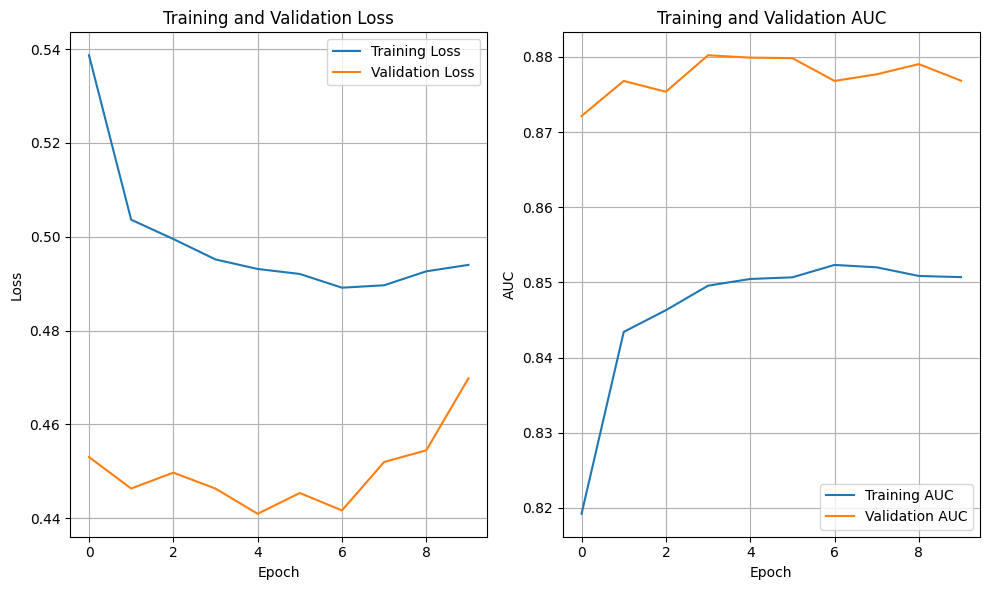

In [ ]:
# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot Training and Validation Loss on the first subplot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# Plot Training and Validation AUC on the second subplot
axes[1].plot(history.history['roc_auc'], label='Training AUC')
axes[1].plot(history.history['val_roc_auc'], label='Validation AUC')
axes[1].set_title('Training and Validation AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].legend()
axes[1].grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


3866/3866 [==============================] - 12s 3ms/step
AUC-ROC: 0.8789560957219691


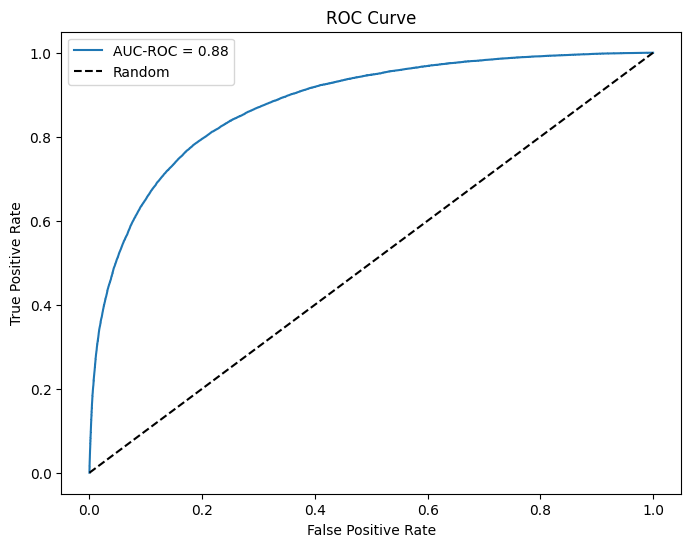

In [ ]:
score(X_train,Y_train,model_3)
# score(X_train,Y_train,model_l1)

1289/1289 [==============================] - 2s 2ms/step
AUC-ROC: 0.8770160731023722


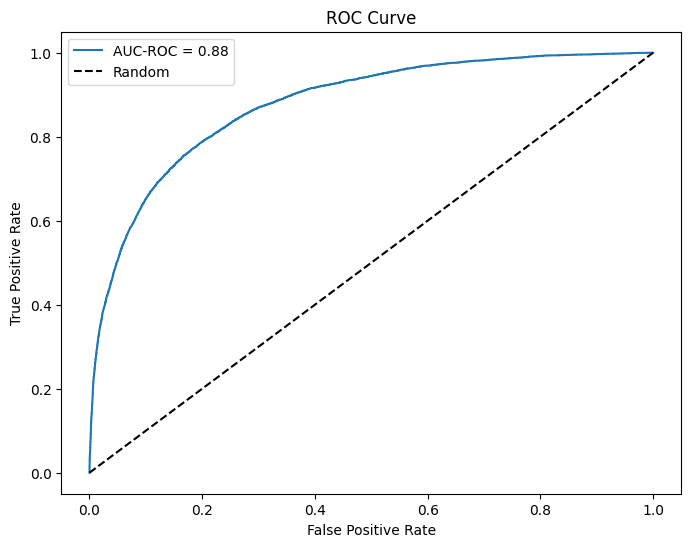

In [ ]:
score(X_test,Y_test,model_3)
# score(X_test,Y_test,model_l1)

In [ ]:
# y_pred = model_l1.predict(X_train)[:,0]
y_pred = model_3.predict(X_train)[:,0]

3866/3866 [==============================] - 6s 2ms/step


In [ ]:
classified = np.vectorize(lambda x: 1 if x>.45 else 0)(y_pred)
accuracy_score(Y_train,classified),confusion_matrix(Y_train,classified)

(0.859059046109813,
 array([[91594,  5987],
        [11445, 14657]]))

In [ ]:
threshold = 0
inc = .05 # increment
model_threshold = {
    'Threshold' : [],
    'TN': [],
    'FP': [],
    'FN': [],
    'TP': [],
    'Accuracy' : [],
    'Score' : [],
}

for i in range(1,20):
    threshold += inc
    classified = np.vectorize(lambda x: 1 if x>threshold else 0)(y_pred)
    m =  confusion_matrix(Y_train,classified)
    tn, fp, fn, tp = m[0][0], m[0][1], m[1][0], m[1][1]

    model_threshold["TN"].append(tn)
    model_threshold["FP"].append(fp)
    model_threshold["FN"].append(fn)
    model_threshold["TP"].append(tp)
    model_threshold["Accuracy"].append(accuracy_score(Y_train, classified))
    model_threshold["Score"].append(roc_auc_score(Y_train, classified))
    model_threshold['Threshold'].append(threshold)


In [ ]:
pd.DataFrame(model_threshold).sort_values(by=['Score', 'Accuracy'], ascending = [False,False]).reset_index(drop=True)

Threshold     TN     FP     FN     TP  Accuracy     Score
0        0.60  79896  17685   5843  20259  0.809772  0.797457
1        0.55  76889  20692   5059  21043  0.791798  0.797067
2        0.50  75207  22374   4684  21418  0.781231  0.795632
3        0.45  73588  23993   4315  21787  0.771125  0.794405
4        0.40  71313  26268   3907  22195  0.756030  0.790563
5        0.65  84324  13257   7412  18690  0.832887  0.790090
6        0.35  65940  31641   3034  23068  0.719646  0.779755
7        0.70  88829   8752   9649  16453  0.851225  0.770323
8        0.75  91537   6044  11654  14448  0.856908  0.745791
9        0.30  52762  44819   1632  24470  0.624435  0.739088
10       0.80  93506   4075  13580  12522  0.857256  0.718987
11       0.25  41738  55843    960  25142  0.540737  0.695474
12       0.85  94998   2583  15603  10499  0.852963  0.687880
13       0.20  34377  63204    629  25473  0.483898  0.664097
14       0.90  96164   1417  17952   8150  0.843398  0.648858
15       0.15  26015  71566    358  25744  0.418481  0.626442
16       0.95  97044    537  21224   4878  0.824058  0.590690
17       0.10  15027  82554    143  25959  0.331379  0.574258
18       0.05   2784  94797     14  26088  0.233435  0.513997

In [ ]:
confusion_matrix(Y_train,Y_train)

array([[97581,     0],
       [    0, 26102]])

### Model 07

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Assume 'X' is your feature matrix, and 'y' is your target variable
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming a binary classification problem where 1 is the minority class
# Create a binary mask for the minority class
minority_mask = (Y_train == 1)

# Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# Separate majority and minority instances
X_majority = X_train[~minority_mask]
X_minority = X_train[minority_mask]

# Define an autoencoder model
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder on the majority class
autoencoder.fit(X_majority, X_majority, epochs=10, batch_size=64, shuffle=True, validation_split=0.2)

# Make predictions on the entire training set
X_train_pred = autoencoder.predict(X_train)

# Calculate reconstruction errors for each instance
reconstruction_errors = np.mean(np.square(X_train - X_train_pred), axis=1)

# Set a threshold for anomaly detection (you may need to tune this)
threshold = np.percentile(reconstruction_errors, 95)

# Classify instances based on the threshold
y_train_pred = (reconstruction_errors > threshold).astype(int)



Epoch 1/10


Exception ignored in: <function _xla_gc_callback at 0x7d2d6c9c2440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1220/1220 [==============================] - 124s 2ms/step - loss: 0.0366 - val_loss: 0.0029
Epoch 2/10
1220/1220 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 5.3003e-04
Epoch 3/10
1220/1220 [==============================] - 3s 3ms/step - loss: 3.9383e-04 - val_loss: 3.4480e-04
Epoch 4/10
1220/1220 [==============================] - 3s 3ms/step - loss: 2.9168e-04 - val_loss: 2.3190e-04
Epoch 5/10
1220/1220 [==============================] - 3s 2ms/step - loss: 1.7733e-04 - val_loss: 1.7161e-04
Epoch 6/10
1220/1220 [==============================] - 3s 2ms/step - loss: 1.5610e-04 - val_loss: 1.6807e-04
Epoch 7/10
1220/1220 [==============================] - 3s 2ms/step - loss: 1.4900e-04 - val_loss: 1.5540e-04
Epoch 8/10
1220/1220 [==============================] - 4s 3ms/step - loss: 1.4488e-04 - val_loss: 1.5675e-04
Epoch 9/10
1220/1220 [==============================] - 3s 2ms/step - loss: 1.4281e-04 - val_loss: 1.5359e-04
Epoch 10/10
3866/3866 [========

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assume 'X' is your feature matrix, and 'y' is your target variable
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming a binary classification problem where 1 is the minority class
# Create a binary mask for the majority class
majority_mask = (Y_train == 0)

# Standardize the features
scaler_2 = StandardScaler()
X_train_scaled = scaler_2.fit_transform(X_train)

# Use OneClassSVM to detect anomalies (minority class instances)
svm_model = OneClassSVM(nu=0.05)  # You may need to tune the nu parameter
svm_model.fit(X_train_scaled[majority_mask])

# Make predictions on the entire training set
y_train_pred = svm_model.predict(X_train_scaled)

# Convert predictions to 1 for anomalies (minority class) and -1 for majority class
y_train_pred_binary = np.where(y_train_pred == -1, 1, 0)

# Evaluate the performance on the test set
X_test_scaled = scaler_2.transform(X_test)
y_test_pred = svm_model.predict(X_test_scaled)
y_test_pred_binary = np.where(y_test_pred == -1, 1, 0)

# Print metrics
print("Train Accuracy:", accuracy_score(Y_train, y_train_pred_binary))
print("Test Accuracy:", accuracy_score(Y_test, y_test_pred_binary))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, y_test_pred_binary))
print("\nClassification Report:\n", classification_report(Y_test, y_test_pred_binary))


Train Accuracy: 0.7825085096577541
Test Accuracy: 0.780464732705928

Confusion Matrix:
 [[30788  1633]
 [ 7418  1389]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.87     32421
           1       0.46      0.16      0.23      8807

    accuracy                           0.78     41228
   macro avg       0.63      0.55      0.55     41228
weighted avg       0.73      0.78      0.74     41228



In [ ]:
confusion_matrix(Y_train, y_train_pred)

array([[93263,  4318],
       [24235,  1867]])

In [ ]:
confusion_matrix(Y_train, Y_train)

array([[97581,     0],
       [    0, 26102]])

In [ ]:
# Evaluate the performance on the test set
X_test_pred = autoencoder.predict(X_test)
test_reconstruction_errors = np.mean(np.square(X_test - X_test_pred), axis=1)
y_test_pred = (test_reconstruction_errors > threshold).astype(int)

# Now, 'y_train_pred' and 'y_test_pred' contain the predicted anomaly labels

0.0006729866953686246

## Observation-1: Before going further

- What we missed till now?

Ans:
1. We missed that our data is Imbalanced. => We should made solve this issue first.

## Balancing our train data

1. For balancing data, we can do in two ways.
    - `df_1` should be balanced first and then split.
    - Use `X_train` and `Y_train` and balance it and then resample it.
1. We decided to go with second one.

In [ ]:
from sklearn.utils import resample, shuffle
# tester = ([[1,2],[3,4]],[5, 6])
tester = [[1,2],[3,4]]

sampled = resample(tester, n_samples=10)
sampled

[[1, 2],
 [1, 2],
 [3, 4],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2],
 [1, 2]]

In [ ]:
np.array(sampled)[:,-1]

array([2, 4, 4, 2, 2, 4, 4, 4, 4, 2])

In [ ]:
np.column_stack((sampled,[0]*10))

array([[1, 2, 0],
       [3, 4, 0],
       [3, 4, 0],
       [1, 2, 0],
       [1, 2, 0],
       [3, 4, 0],
       [3, 4, 0],
       [3, 4, 0],
       [3, 4, 0],
       [1, 2, 0]])

In [ ]:
# first select 0 and 1 level
# we know 0 is majority and 1 is minority,
# let's filter out them first
imbalanced_dataset = pd.DataFrame(np.column_stack((X_train,Y_train)))
imbalanced_dataset.columns =  df_1.columns
imbalanced_dataset.head()

CreditScore       Age   Balance  HasCrCard  IsActiveMember  \
0        0.650  0.297297  0.518819        1.0             0.0   
1        0.596  0.337838  0.611060        0.0             0.0   
2        0.710  0.405405  0.000000        1.0             0.0   
3        0.762  0.135135  0.000000        1.0             0.0   
4        0.522  0.108108  0.000000        1.0             1.0   

   EstimatedSalary  Is_France  Is_Germany  Is_Spain  Gender_F  ...  Tenure_2  \
0         0.885353        0.0         1.0       0.0       0.0  ...       0.0   
1         0.852842        1.0         0.0       0.0       1.0  ...       0.0   
2         0.069558        1.0         0.0       0.0       0.0  ...       0.0   
3         0.297828        1.0         0.0       0.0       0.0  ...       0.0   
4         0.602555        1.0         0.0       0.0       0.0  ...       0.0   

   Tenure_3  Tenure_4  Tenure_5  Tenure_6  Tenure_7  Tenure_8  Tenure_9  \
0       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
1       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       1.0   
4       1.0       0.0       0.0       0.0       0.0       0.0       0.0   

   Tenure_10  Exited  
0        0.0     1.0  
1        0.0     0.0  
2        0.0     0.0  
3        0.0     0.0  
4        0.0     0.0  

[5 rows x 26 columns]

In [ ]:
# we will use oversampling minority class, i.e. level 1

minority_mapper = imbalanced_dataset['Exited']==1

minority  = imbalanced_dataset[minority_mapper]
majority = imbalanced_dataset[~minority_mapper]
# let's find out the length of the both
print(f"length of majority: {len(majority)} and length of minority: {len(minority)}")

# Oversampling minority class
minority_oversampled = resample(minority, n_samples = len(majority), random_state=42)
# Undersampling majority class can be done too.
majority_undersampled = resample(majority, replace=False, n_samples=len(minority), random_state=42)
minority_oversampled.head()

length of majority: 97581 and length of minority: 26102


CreditScore       Age   Balance  HasCrCard  IsActiveMember  \
111813        0.672  0.405405  0.000000        1.0             0.0   
74810         0.634  0.364865  0.228489        1.0             0.0   
4156          0.484  0.094595  0.453862        0.0             0.0   
25885         0.512  0.445946  0.529560        1.0             0.0   
102242        0.612  0.391892  0.607906        1.0             0.0   

        EstimatedSalary  Is_France  Is_Germany  Is_Spain  Gender_F  ...  \
111813         0.691909        1.0         0.0       0.0       1.0  ...   
74810          0.450520        0.0         0.0       1.0       0.0  ...   
4156           0.839890        0.0         1.0       0.0       0.0  ...   
25885          0.658052        0.0         1.0       0.0       1.0  ...   
102242         0.820211        0.0         1.0       0.0       1.0  ...   

        Tenure_2  Tenure_3  Tenure_4  Tenure_5  Tenure_6  Tenure_7  Tenure_8  \
111813       0.0       0.0       1.0       0.0       0.0       0.0       0.0   
74810        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4156         0.0       0.0       1.0       0.0       0.0       0.0       0.0   
25885        0.0       0.0       0.0       0.0       0.0       0.0       0.0   
102242       0.0       0.0       1.0       0.0       0.0       0.0       0.0   

        Tenure_9  Tenure_10  Exited  
111813       0.0        0.0     1.0  
74810        0.0        0.0     1.0  
4156         0.0        0.0     1.0  
25885        0.0        0.0     1.0  
102242       0.0        0.0     1.0  

[5 rows x 26 columns]

In [ ]:
# balanced_dataset = shuffle(pd.concat([minority_oversampled, majority]), random_state=42)
balanced_dataset = shuffle(pd.concat([minority, majority_undersampled]), random_state=42)
balanced_dataset.head()

CreditScore       Age   Balance  HasCrCard  IsActiveMember  \
59556        0.634  0.243243  0.428746        0.0             0.0   
34057        0.462  0.256757  0.000000        1.0             0.0   
67540        0.650  0.256757  0.000000        1.0             0.0   
43979        0.846  0.432432  0.363857        0.0             1.0   
25534        0.342  0.283784  0.000000        1.0             1.0   

       EstimatedSalary  Is_France  Is_Germany  Is_Spain  Gender_F  ...  \
59556         0.494043        1.0         0.0       0.0       1.0  ...   
34057         0.128379        1.0         0.0       0.0       0.0  ...   
67540         0.902996        0.0         0.0       1.0       1.0  ...   
43979         0.457794        1.0         0.0       0.0       1.0  ...   
25534         0.939684        1.0         0.0       0.0       0.0  ...   

       Tenure_2  Tenure_3  Tenure_4  Tenure_5  Tenure_6  Tenure_7  Tenure_8  \
59556       1.0       0.0       0.0       0.0       0.0       0.0       0.0   
34057       0.0       0.0       0.0       0.0       0.0       1.0       0.0   
67540       0.0       0.0       0.0       0.0       1.0       0.0       0.0   
43979       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
25534       0.0       1.0       0.0       0.0       0.0       0.0       0.0   

       Tenure_9  Tenure_10  Exited  
59556       0.0        0.0     0.0  
34057       0.0        0.0     0.0  
67540       0.0        0.0     0.0  
43979       0.0        0.0     1.0  
25534       0.0        0.0     0.0  

[5 rows x 26 columns]

In [ ]:
# data should be saved!!!

In [ ]:
X_train_balanced = balanced_dataset.drop('Exited', axis=1)
Y_train_balanced = balanced_dataset['Exited']

### Test the effect of balancing

#### LR model

In [ ]:
lr = LogisticRegression(penalty='l1', solver = 'liblinear')
lr.fit(X_train, Y_train)
lr.score(X_train, Y_train)

0.8567062571250698

In [ ]:
confusion_matrix(Y_train, lr.predict(X_train))

array([[92532,  5049],
       [12674, 13428]])

In [ ]:
lr = LogisticRegression(penalty='l1', solver = 'liblinear', max_iter=1000,verbose=3)
lr.fit(X_train_balanced, Y_train_balanced)
lr.score(X_train_balanced, Y_train_balanced)

[LibLinear]

0.7935790360891886

In [ ]:
confusion_matrix(Y_train_balanced, lr.predict(X_train_balanced))

array([[20717,  5385],
       [ 5391, 20711]])

In [ ]:
confusion_matrix(Y_train, lr.predict(X_train))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



array([[77290, 20291],
       [ 5391, 20711]])

In [ ]:
df_extra['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

#### Deep Neural network

In [ ]:
# Define Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Build the TensorFlow Model with Dropout for Regularization
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),

    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(32, activation='relu'),

    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(16, activation='relu'),

    tf.keras.layers.Dropout(0.5),  # Add dropout for regularization

    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification output layer
])

# Specify the learning rate for the Adam optimizer
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=.005)

# Compile the Model with ROC-AUC metric and the specified optimizer
model_3.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='roc_auc')])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               3328      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)               

In [ ]:
# Train the model with Early Stopping callback and validation split
history = model_3.fit(
    X_train_balanced, Y_train_balanced,
    epochs=30,        # Set the number of epochs
    batch_size=32,      # Set the batch size
    validation_split=0.2,  # Use 20% of the training data as validation data
    callbacks=[early_stopping]  # Use the EarlyStopping callback
)

Epoch 1/30
1306/1306 [==============================] - 7s 4ms/step - loss: 0.5387 - roc_auc: 0.8192 - val_loss: 0.4530 - val_roc_auc: 0.8721
Epoch 2/30
1306/1306 [==============================] - 3s 3ms/step - loss: 0.5036 - roc_auc: 0.8434 - val_loss: 0.4463 - val_roc_auc: 0.8768
Epoch 3/30
1306/1306 [==============================] - 5s 4ms/step - loss: 0.4995 - roc_auc: 0.8463 - val_loss: 0.4497 - val_roc_auc: 0.8754
Epoch 4/30
1306/1306 [==============================] - 5s 3ms/step - loss: 0.4952 - roc_auc: 0.8496 - val_loss: 0.4463 - val_roc_auc: 0.8802
Epoch 5/30
1306/1306 [==============================] - 4s 3ms/step - loss: 0.4931 - roc_auc: 0.8505 - val_loss: 0.4409 - val_roc_auc: 0.8799
Epoch 6/30
1306/1306 [==============================] - 4s 3ms/step - loss: 0.4921 - roc_auc: 0.8507 - val_loss: 0.4453 - val_roc_auc: 0.8798
Epoch 7/30
1306/1306 [==============================] - 5s 4ms/step - loss: 0.4891 - roc_auc: 0.8523 - val_loss: 0.4416 - val_roc_auc: 0.8768
Epoch 

In [ ]:
confusion_matrix(Y_train, np.vectorize(lambda x: 1 if x>.59 else 0)(model_3.predict(X_train)[:,0]))

3866/3866 [==============================] - 13s 3ms/step


array([[79007, 18574],
       [ 5592, 20510]])

In [ ]:
accuracy_score(Y_train, np.vectorize(lambda x: 1 if x>.45 else 0)(model_3.predict(X_train)[:,0]))

3866/3866 [==============================] - 9s 2ms/step


0.7711245684532232

### Effect of Balancing

- We observed fp $\approx$ fn. This applies for TP and TN. \[ For both undersampling and oversampling. \]
- Accuracy got down for both.

## LGBM Classifier

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    params = {
        'boosting_type' : trial.suggest_categorical('boosting_type',
                                                    ['gbdt', 'rf', 'dart']),
        'num_leaves' : trial.suggest_int('num_leaves', 8, 64, log=True),
        'max_depth'  : trial.suggest_categorical('max_depth', [-1, 4, 5, 6]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1,log=True),
        'objective' : trial.suggest_categorical('objective', ['binary'] ),
        # 'class_weight' : trial.suggest_categorical('class_weight', ['scale_pos_weight', 'is_unbalance']),

        'min_split_gain' : trial.suggest_categorical('min_split_gain', [0, 1e-4, 1e-3, 1e-1] ),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 20, 40] ),
        'colsample_bytree' : trial.suggest_categorical('colsample_bytree',[.1, .25, .4, .5, .67, .75, .9, 1.0]),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0, .1 ),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, .1 ),
        'importance_type' : trial.suggest_categorical('importance_type', ['split', 'gain'] ),

    }
    clf = LGBMClassifier(random_state=42, **params)
    roc_auc = 0
    try:
        clf.fit(X_train, Y_train)

        y_prob = clf.predict_proba(X_train)[:, 1]
        roc_auc = roc_auc_score(Y_train, y_prob)
    except Exception as e:
        print(e)

    return roc_auc

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)


[I 2024-01-06 14:12:02,562] A new study created in memory with name: no-name-9fa7f044-5cb7-4c4b-bd2d-b27963518f9f


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:12:05,896] Trial 0 finished with value: 0.8753932043376225 and parameters: {'boosting_type': 'dart', 'num_leaves': 16, 'max_depth': -1, 'learning_rate': 0.0016176604599029366, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.9, 'reg_alpha': 0.015597736195361445, 'reg_lambda': 0.06942189859758865, 'importance_type': 'gain'}. Best is trial 0 with value: 0.8753932043376225.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:12:07,270] Trial 1 finished with value: 0.8735767691768767 and parameters: {'boosting_type': 'rf', 'num_leaves': 53, 'max_depth': -1, 'learning_rate': 0.008187107188650277, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 40, 'colsample_bytree': 0.1, 'reg_alpha': 0.040412248564150245, 'reg_lambda': 0.07835568778420066, 'importance_type': 'gain'}. Best is trial 0 with value: 0.8753932043376225.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:12:08,557] Trial 2 finished with value: 0.8779214745259429 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': 4, 'learning_rate': 0.0437477872680798, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.1, 'reg_alpha': 0.059171965936611295, 'reg_lambda': 0.029426664453179777, 'importance_type': 'gain'}. Best is trial 2 with value: 0.8779214745259429.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:12:09,559] Trial 3 finished with value: 0.8678196361494788 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 4, 'learning_rate': 0.0017646800810291918, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.9, 'reg_alpha': 0.031010799628228503, 'reg_lambda': 0.012164478017484704, 'importance_type': 'gain'}. Best is trial 2 with value: 0.8779214745259429.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:12:10,409] Trial 4 finished with value: 0.8704406193356957 and parameters: {'boosting_type': 'rf', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.0010057484196553579, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.1, 'reg_alpha': 0.04830060442338411, 'reg_lambda': 0.08269841130349692, 'importance_type': 'gain'}. Best is trial 2 with value: 0.8779214745259429.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:12:13,548] Trial 5 finished with value: 0.8788955494275421 and parameters: {'boosting_type': 'dart', 'num_leaves': 10, 'max_depth': 4, 'learning_rate': 0.001263855029417943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.016985529878933637, 'reg_lambda': 0.04340840989057179, 'importance_type': 'split'}. Best is trial 5 with value: 0.8788955494275421.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-06 14:12:16,603] Trial 6 finished with value: 0.8707043140247124 and parameters: {'boosting_type': 'dart', 'num_leaves': 9, 'max_depth': 6, 'learning_rate': 0.016101614305498654, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 40, 'colsample_bytree': 0.25, 'reg_alpha': 0.002587172220002043, 'reg_lambda': 0.006496618029447832, 'importance_type': 'split'}. Best is trial 5 with value: 0.8788955494275421.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:12:22,082] Trial 7 finished with value: 0.8834109009827977 and parameters: {'boosting_type': 'dart', 'num_leaves': 46, 'max_depth': 5, 'learning_rate': 0.005495697484895711, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.5, 'reg_alpha': 0.06471288466148255, 'reg_lambda': 0.06002611923271939, 'importance_type': 'split'}. Best is trial 7 with value: 0.8834109009827977.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:12:23,121] Trial 8 finished with value: 0.8716121615705068 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': -1, 'learning_rate': 0.0029595545219031627, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.1, 'reg_alpha': 0.029013057584778602, 'reg_lambda': 0.08292790126928108, 'importance_type': 'split'}. Best is trial 7 with value: 0.8834109009827977.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:12:28,013] Trial 9 finished with value: 0.8827358978426469 and parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'max_depth': 5, 'learning_rate': 0.004422039025870576, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.75, 'reg_alpha': 0.08237701644050312, 'reg_lambda': 0.01678895440700672, 'importance_type': 'split'}. Best is trial 7 with value: 0.8834109009827977.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-01-06 14:12:33,459] Trial 10 finished with value: 0.8894396174045518 and parameters: {'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': 5, 'learning_rate': 0.07911932569438744, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.08579706599850036, 'reg_lambda': 0.05320296561701984, 'importance_type': 'split'}. Best is trial 10 with value: 0.8894396174045518.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:12:38,426] Trial 11 finished with value: 0.8897585351902974 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'max_depth': 5, 'learning_rate': 0.08419479934874653, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.08836575166019756, 'reg_lambda': 0.0589782459893866, 'importance_type': 'split'}. Best is trial 11 with value: 0.8897585351902974.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:12:43,780] Trial 12 finished with value: 0.8896876071193666 and parameters: {'boosting_type': 'dart', 'num_leaves': 35, 'max_depth': 5, 'learning_rate': 0.08269509565174903, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.09947425905234762, 'reg_lambda': 0.049178393519834565, 'importance_type': 'split'}. Best is trial 11 with value: 0.8897585351902974.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:12:48,683] Trial 13 finished with value: 0.8822213242245324 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'max_depth': 5, 'learning_rate': 0.028572441838410945, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09506371448287484, 'reg_lambda': 0.09859330250868008, 'importance_type': 'split'}. Best is trial 11 with value: 0.8897585351902974.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:12:53,678] Trial 14 finished with value: 0.8907264394463076 and parameters: {'boosting_type': 'dart', 'num_leaves': 32, 'max_depth': 6, 'learning_rate': 0.08980717186388543, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.09958451360143707, 'reg_lambda': 0.041453698795711494, 'importance_type': 'split'}. Best is trial 14 with value: 0.8907264394463076.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:12:55,327] Trial 15 finished with value: 0.883167509511995 and parameters: {'boosting_type': 'rf', 'num_leaves': 24, 'max_depth': 6, 'learning_rate': 0.03588874279155905, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.07537456564361561, 'reg_lambda': 0.03598581525686574, 'importance_type': 'split'}. Best is trial 14 with value: 0.8907264394463076.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:12:59,793] Trial 16 finished with value: 0.8899254969513937 and parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'max_depth': 6, 'learning_rate': 0.09853674453322116, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.07318745948312412, 'reg_lambda': 0.02617458243442569, 'importance_type': 'split'}. Best is trial 14 with value: 0.8907264394463076.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:03,935] Trial 17 finished with value: 0.885359724504125 and parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'max_depth': 6, 'learning_rate': 0.018526198518914662, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.0719628330330189, 'reg_lambda': 0.0229622165777458, 'importance_type': 'split'}. Best is trial 14 with value: 0.8907264394463076.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:05,412] Trial 18 finished with value: 0.890307720684671 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'max_depth': 6, 'learning_rate': 0.049074178817487386, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.059326876525197796, 'reg_lambda': 0.03285498237501356, 'importance_type': 'split'}. Best is trial 14 with value: 0.8907264394463076.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:07,142] Trial 19 finished with value: 0.8902928205602152 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.05086402360708544, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.05729995177906199, 'reg_lambda': 0.03690522688458505, 'importance_type': 'split'}. Best is trial 14 with value: 0.8907264394463076.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:08,735] Trial 20 finished with value: 0.8860382787983988 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 19, 'max_depth': 6, 'learning_rate': 0.020426305546598432, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.046062174913601, 'reg_lambda': 0.00039709430939872947, 'importance_type': 'split'}. Best is trial 14 with value: 0.8907264394463076.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:10,044] Trial 21 finished with value: 0.8894680503904193 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': 6, 'learning_rate': 0.050811965286180344, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.057832195543244896, 'reg_lambda': 0.04036795378516636, 'importance_type': 'split'}. Best is trial 14 with value: 0.8907264394463076.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:11,467] Trial 22 finished with value: 0.890647038074295 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 17, 'max_depth': 6, 'learning_rate': 0.054268287699377755, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.060463490944749704, 'reg_lambda': 0.03240926321771535, 'importance_type': 'split'}. Best is trial 14 with value: 0.8907264394463076.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:13,077] Trial 23 finished with value: 0.8929459957732229 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 6, 'learning_rate': 0.0608743264573785, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.039301014355587395, 'reg_lambda': 0.032393137419674846, 'importance_type': 'split'}. Best is trial 23 with value: 0.8929459957732229.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:14,685] Trial 24 finished with value: 0.8891217459234759 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'max_depth': 6, 'learning_rate': 0.02539125437125978, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.03585984947262047, 'reg_lambda': 0.019822064432451537, 'importance_type': 'split'}. Best is trial 23 with value: 0.8929459957732229.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:13:16,417] Trial 25 finished with value: 0.8858704672337538 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': 6, 'learning_rate': 0.012012582185654442, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.023523675629950277, 'reg_lambda': 0.04602985719308572, 'importance_type': 'split'}. Best is trial 23 with value: 0.8929459957732229.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:13:17,929] Trial 26 finished with value: 0.8825180674182523 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 6, 'learning_rate': 0.06551871926802856, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.25, 'reg_alpha': 0.039910426542266716, 'reg_lambda': 0.02921872127903246, 'importance_type': 'gain'}. Best is trial 23 with value: 0.8929459957732229.
[I 2024-01-06 14:13:18,133] Trial 27 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 13, 'max_depth': 6, 'learning_rate': 0.03319909282866823, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0013685618379635361, 'reg_lambda': 0.05486456836863836, 'importance_type': 'split'}. Best is trial 23 with value: 0.8929459957732229.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:20,558] Trial 28 finished with value: 0.8944469170737339 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'max_depth': 6, 'learning_rate': 0.055391704569110016, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.75, 'reg_alpha': 0.05181221035366574, 'reg_lambda': 0.06531159643674643, 'importance_type': 'split'}. Best is trial 28 with value: 0.8944469170737339.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:22,303] Trial 29 finished with value: 0.8960418310832376 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': -1, 'learning_rate': 0.06543205429072715, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.014274493509171697, 'reg_lambda': 0.07029095192481996, 'importance_type': 'gain'}. Best is trial 29 with value: 0.8960418310832376.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:24,015] Trial 30 finished with value: 0.888475169094829 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 41, 'max_depth': -1, 'learning_rate': 0.012721171296634437, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.010569983008688692, 'reg_lambda': 0.06840352920744912, 'importance_type': 'gain'}. Best is trial 29 with value: 0.8960418310832376.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:25,768] Trial 31 finished with value: 0.8962556317623677 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 39, 'max_depth': -1, 'learning_rate': 0.06390881662109812, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.013336434736701184, 'reg_lambda': 0.06847829673397342, 'importance_type': 'gain'}. Best is trial 31 with value: 0.8962556317623677.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:27,582] Trial 32 finished with value: 0.8987278948125236 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.06620553145577673, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.016792899168303687, 'reg_lambda': 0.06852649568917012, 'importance_type': 'gain'}. Best is trial 32 with value: 0.8987278948125236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:29,445] Trial 33 finished with value: 0.8939802257337504 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': -1, 'learning_rate': 0.03971074234804602, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.010828618319312859, 'reg_lambda': 0.07081713812105926, 'importance_type': 'gain'}. Best is trial 32 with value: 0.8987278948125236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:31,811] Trial 34 finished with value: 0.9012142967170584 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.06543794946178383, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.02227287531199284, 'reg_lambda': 0.07078666892033766, 'importance_type': 'gain'}. Best is trial 34 with value: 0.9012142967170584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:34,019] Trial 35 finished with value: 0.89304758351555 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.02560037553419131, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.019881494313443535, 'reg_lambda': 0.07656193231100206, 'importance_type': 'gain'}. Best is trial 34 with value: 0.9012142967170584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:35,882] Trial 36 finished with value: 0.8949257712638176 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.04092021626410727, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.00984573740044209, 'reg_lambda': 0.09300455834554296, 'importance_type': 'gain'}. Best is trial 34 with value: 0.9012142967170584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:37,275] Trial 37 finished with value: 0.8855667192952813 and parameters: {'boosting_type': 'rf', 'num_leaves': 53, 'max_depth': -1, 'learning_rate': 0.06396831900854752, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.9, 'reg_alpha': 0.023650077944314275, 'reg_lambda': 0.07778537137460793, 'importance_type': 'gain'}. Best is trial 34 with value: 0.9012142967170584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:39,043] Trial 38 finished with value: 0.8985634581202768 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': -1, 'learning_rate': 0.07206832981409117, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0058739055241014936, 'reg_lambda': 0.08527109294013172, 'importance_type': 'gain'}. Best is trial 34 with value: 0.9012142967170584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:40,731] Trial 39 finished with value: 0.9020495862730342 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'max_depth': -1, 'learning_rate': 0.099870071517792, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.006355039979290256, 'reg_lambda': 0.08511647208287673, 'importance_type': 'gain'}. Best is trial 39 with value: 0.9020495862730342.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:42,496] Trial 40 finished with value: 0.9014146866363724 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'max_depth': -1, 'learning_rate': 0.09556869549221564, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.005612631442967261, 'reg_lambda': 0.08410918771008792, 'importance_type': 'gain'}. Best is trial 39 with value: 0.9020495862730342.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:44,630] Trial 41 finished with value: 0.9025858258573962 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': -1, 'learning_rate': 0.09705801429025986, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.005860783234262767, 'reg_lambda': 0.08720440221850863, 'importance_type': 'gain'}. Best is trial 41 with value: 0.9025858258573962.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:46,414] Trial 42 finished with value: 0.9058178152432796 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.09501533528025229, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.004774777919724912, 'reg_lambda': 0.08836770831891033, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:13:47,798] Trial 43 finished with value: 0.8919922303715916 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.09415334952411691, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.005975432779669578, 'reg_lambda': 0.08900427314153654, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:49,553] Trial 44 finished with value: 0.9042646427046502 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09212331567076454, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.004985695921316739, 'reg_lambda': 0.09967936591106125, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:13:50,747] Trial 45 finished with value: 0.8737049546513456 and parameters: {'boosting_type': 'rf', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.007513878439250795, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.1, 'reg_alpha': 0.005909224573253715, 'reg_lambda': 0.09737489754231042, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:52,376] Trial 46 finished with value: 0.902650076227398 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': -1, 'learning_rate': 0.09110402082842356, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.9, 'reg_alpha': 0.0005575579962975429, 'reg_lambda': 0.09150145699397026, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:54,085] Trial 47 finished with value: 0.8871699222756444 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.0022664160342071283, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.9, 'reg_alpha': 1.10965237781047e-05, 'reg_lambda': 0.09024525615275043, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:13:56,000] Trial 48 finished with value: 0.8915741093581199 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 4, 'learning_rate': 0.08026298436703469, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.9, 'reg_alpha': 0.02977852444868542, 'reg_lambda': 0.0954041281097551, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:13:57,659] Trial 49 finished with value: 0.8998005382883785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 44, 'max_depth': -1, 'learning_rate': 0.08094607112491296, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.9, 'reg_alpha': 0.018454054769596606, 'reg_lambda': 0.08791689933849021, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-06 14:13:59,206] Trial 50 finished with value: 0.8824028258907468 and parameters: {'boosting_type': 'rf', 'num_leaves': 36, 'max_depth': -1, 'learning_rate': 0.0991477551879459, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.4, 'reg_alpha': 0.0034299224831012996, 'reg_lambda': 0.0999037563098847, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:14:00,833] Trial 51 finished with value: 0.8893112719416577 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': -1, 'learning_rate': 0.09913413465155894, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.25, 'reg_alpha': 0.008198630795668209, 'reg_lambda': 0.08117272150922496, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:02,602] Trial 52 finished with value: 0.9016687388328226 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': -1, 'learning_rate': 0.08658059236895946, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.01329485890751186, 'reg_lambda': 0.0937752141766811, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:04,382] Trial 53 finished with value: 0.9007898611665675 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.07775960238327229, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.013836883180790672, 'reg_lambda': 0.09419367300758263, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:06,399] Trial 54 finished with value: 0.8966517387611532 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.044140987724143974, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.67, 'reg_alpha': 0.0005956330423974282, 'reg_lambda': 0.08987753783660808, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:14:08,087] Trial 55 finished with value: 0.874680009310282 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.004321979763912991, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.1, 'reg_alpha': 0.008770434332841304, 'reg_lambda': 0.07978373706135368, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:09,295] Trial 56 finished with value: 0.8893257578629515 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': 4, 'learning_rate': 0.07632446532697716, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.02705371513634813, 'reg_lambda': 0.09340732011368502, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:11,148] Trial 57 finished with value: 0.8950350531734115 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.0459763649838379, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.9, 'reg_alpha': 0.003571519706735228, 'reg_lambda': 0.07472325832415698, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:14:12,815] Trial 58 finished with value: 0.8898104393615008 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 5, 'learning_rate': 0.03324146280724948, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.75, 'reg_alpha': 0.013514102679135786, 'reg_lambda': 0.08497423293426495, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:14,648] Trial 59 finished with value: 0.8963936685977274 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 47, 'max_depth': -1, 'learning_rate': 0.055348736887194834, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.01860333457911245, 'reg_lambda': 0.09658140240740487, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-06 14:14:20,583] Trial 60 finished with value: 0.8911066940459746 and parameters: {'boosting_type': 'dart', 'num_leaves': 43, 'max_depth': -1, 'learning_rate': 0.08307787934416593, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.4, 'reg_alpha': 0.008206106834147771, 'reg_lambda': 0.08649460891221279, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:22,320] Trial 61 finished with value: 0.9024104810954335 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.08724387932847395, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0042690319424054405, 'reg_lambda': 0.08297065024089323, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:24,101] Trial 62 finished with value: 0.9022487349569961 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.086106625629524, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.004168223288011474, 'reg_lambda': 0.09244260181240953, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:25,941] Trial 63 finished with value: 0.9001466751110088 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.07058588282006016, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0035184304141165205, 'reg_lambda': 0.09106418290220522, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:14:27,671] Trial 64 finished with value: 0.8840186744347529 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.05391237064849259, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.25, 'reg_alpha': 0.0030134888660705438, 'reg_lambda': 0.09997761688457796, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:29,438] Trial 65 finished with value: 0.9026004482105372 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.08684826274703847, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0003054289915164496, 'reg_lambda': 0.08161697242830966, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:14:31,580] Trial 66 finished with value: 0.8938416125474509 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 5, 'learning_rate': 0.07449616155415129, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 20, 'colsample_bytree': 0.67, 'reg_alpha': 0.0003176754362643015, 'reg_lambda': 0.0748336662389585, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:33,589] Trial 67 finished with value: 0.8982809010903964 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.05713155336058781, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.011789954419787356, 'reg_lambda': 0.08124721108745912, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:34,891] Trial 68 finished with value: 0.8846594080542443 and parameters: {'boosting_type': 'rf', 'num_leaves': 42, 'max_depth': -1, 'learning_rate': 0.08324026392988598, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.9, 'reg_alpha': 0.033526924168105224, 'reg_lambda': 0.09100594504004932, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-06 14:14:38,551] Trial 69 finished with value: 0.8845411711115498 and parameters: {'boosting_type': 'dart', 'num_leaves': 36, 'max_depth': 4, 'learning_rate': 0.04897136243883177, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.01573940122242843, 'reg_lambda': 0.09660203840066832, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:40,436] Trial 70 finished with value: 0.8991370109314716 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.05936873349900813, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.5, 'reg_alpha': 0.0085709741861998, 'reg_lambda': 0.05987634436961199, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:42,137] Trial 71 finished with value: 0.9023978569290154 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': -1, 'learning_rate': 0.09843212521442789, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.005760681452259907, 'reg_lambda': 0.08362711259385881, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:44,715] Trial 72 finished with value: 0.9011871909480527 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 48, 'max_depth': -1, 'learning_rate': 0.08668675201523593, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0032912280234776107, 'reg_lambda': 0.08297972618918845, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:46,449] Trial 73 finished with value: 0.8867394010795497 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.0010829416394853102, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.01101902201916245, 'reg_lambda': 0.08784218741250137, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:48,750] Trial 74 finished with value: 0.9013079933983884 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.07254090093610906, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.004848414213769616, 'reg_lambda': 0.0737240594172902, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:50,836] Trial 75 finished with value: 0.8988290167235222 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': -1, 'learning_rate': 0.08898711871154591, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.00014807119293317437, 'reg_lambda': 0.07879329650071241, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:52,770] Trial 76 finished with value: 0.893158773900566 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 21, 'max_depth': -1, 'learning_rate': 0.07360437478345466, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0073052183988877055, 'reg_lambda': 0.06497414524382294, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:14:54,704] Trial 77 finished with value: 0.8837530296536933 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.062143796787648836, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 40, 'colsample_bytree': 0.1, 'reg_alpha': 0.02065227860166599, 'reg_lambda': 0.09223898809886359, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:14:56,872] Trial 78 finished with value: 0.8904343139307765 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 5, 'learning_rate': 0.03871698617919377, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.044554762227624445, 'reg_lambda': 0.08277789695999484, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:14:58,584] Trial 79 finished with value: 0.9026338084472886 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': -1, 'learning_rate': 0.09110374316660153, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.015890208819592824, 'reg_lambda': 0.08643452692706355, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:04,156] Trial 80 finished with value: 0.8900971346932093 and parameters: {'boosting_type': 'dart', 'num_leaves': 48, 'max_depth': -1, 'learning_rate': 0.06756527388584209, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.9, 'reg_alpha': 0.016055057473291744, 'reg_lambda': 0.08657669028233184, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:05,901] Trial 81 finished with value: 0.902525697299618 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': -1, 'learning_rate': 0.09111876331697223, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.011556807151147028, 'reg_lambda': 0.08891634080684001, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:07,814] Trial 82 finished with value: 0.8911994881177602 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 11, 'max_depth': -1, 'learning_rate': 0.09128174689304876, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.010859883402083294, 'reg_lambda': 0.08847562202643808, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:09,547] Trial 83 finished with value: 0.9036342987138555 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.09959109312992176, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0022852770683517505, 'reg_lambda': 0.08114564203193658, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:11,015] Trial 84 finished with value: 0.8913184855453119 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': -1, 'learning_rate': 0.07094115468999876, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0029267066162844317, 'reg_lambda': 0.07952810513897343, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:15:12,857] Trial 85 finished with value: 0.8983111687410751 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.07807015339489434, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.4, 'reg_alpha': 0.025481041711675645, 'reg_lambda': 0.07612744514675815, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:15:14,373] Trial 86 finished with value: 0.8722807219865936 and parameters: {'boosting_type': 'rf', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09957930495571082, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.25, 'reg_alpha': 0.008920885055683678, 'reg_lambda': 0.08097486808730936, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:16,151] Trial 87 finished with value: 0.9029597066359896 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.08898615629910123, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0021172840024456137, 'reg_lambda': 0.09786211856976015, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:15:17,559] Trial 88 finished with value: 0.8900855776397715 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 4, 'learning_rate': 0.05788195576462865, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0013835381101251429, 'reg_lambda': 0.09586379982915133, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:19,814] Trial 89 finished with value: 0.8865064227940214 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': -1, 'learning_rate': 0.0016045565663187133, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.67, 'reg_alpha': 0.012168901272550731, 'reg_lambda': 0.09769133176988498, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:21,756] Trial 90 finished with value: 0.8983002170916901 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': -1, 'learning_rate': 0.06564626182589273, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.5, 'reg_alpha': 0.007609921916316674, 'reg_lambda': 0.09452804073771957, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:23,898] Trial 91 finished with value: 0.9032491298194224 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.08961356225210838, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0020270455971664694, 'reg_lambda': 0.08938450389789228, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:25,696] Trial 92 finished with value: 0.9046806261549795 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.08837599144166376, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.001850098878977347, 'reg_lambda': 0.09005582265681585, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:27,531] Trial 93 finished with value: 0.9032235261748693 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07960240479971598, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0021332652863585923, 'reg_lambda': 0.09858571761177219, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:29,371] Trial 94 finished with value: 0.902962310619375 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.07857708801919927, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.001843084930255516, 'reg_lambda': 0.09876393117287928, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:31,697] Trial 95 finished with value: 0.9025850798990951 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.07691542555207573, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.06609558648820604, 'reg_lambda': 0.09913917827187967, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:33,720] Trial 96 finished with value: 0.898682616321473 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.05172066959698858, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.002161876648896906, 'reg_lambda': 0.09577683983266122, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:35,856] Trial 97 finished with value: 0.8881698676000417 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.006567615776563938, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.9, 'reg_alpha': 0.006882992362989388, 'reg_lambda': 0.09144615698154313, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:37,981] Trial 98 finished with value: 0.8890836863457322 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.015533894289653644, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0020429680909424784, 'reg_lambda': 0.09773663808945945, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:15:40,149] Trial 99 finished with value: 0.8927832620252556 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 5, 'learning_rate': 0.06118264872640323, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.009765009176082794, 'reg_lambda': 0.09425457655073669, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:15:41,348] Trial 100 finished with value: 0.8738218317905788 and parameters: {'boosting_type': 'rf', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.07963917003823334, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.1, 'reg_alpha': 0.00492838351014133, 'reg_lambda': 0.010443918164920282, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:43,525] Trial 101 finished with value: 0.9050645795299914 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.08954077808796634, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0007353702450278447, 'reg_lambda': 0.09803943764514245, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:45,536] Trial 102 finished with value: 0.9022018846532829 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.06899501634568819, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0015918360012085935, 'reg_lambda': 0.09860648377180771, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:47,345] Trial 103 finished with value: 0.9044907010491066 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.0896782113312928, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0024512473692272544, 'reg_lambda': 0.09243861211649779, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:49,192] Trial 104 finished with value: 0.9030915019597217 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08060773057263915, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.004378734285068107, 'reg_lambda': 0.09233033299596742, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:51,019] Trial 105 finished with value: 0.9031226783053939 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07943700307124903, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.006747979755554839, 'reg_lambda': 0.0954789317308579, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:53,184] Trial 106 finished with value: 0.8973954697878561 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.04735127089590046, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0068822718331421305, 'reg_lambda': 0.09298084582618281, 'importance_type': 'split'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:15:59,565] Trial 107 finished with value: 0.8930960700199051 and parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07791754905699523, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0047292031039507885, 'reg_lambda': 0.09993556764196444, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:01,668] Trial 108 finished with value: 0.900853682806851 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.06822245328043734, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.008804590896506207, 'reg_lambda': 0.09008686816728609, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-06 14:16:03,357] Trial 109 finished with value: 0.8774578316034487 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.003693247472509232, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.004368105876519466, 'reg_lambda': 0.09521156256890288, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:05,181] Trial 110 finished with value: 0.9021200734433481 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.08174243610041737, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.07993836901834554, 'reg_lambda': 0.09672798768844562, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:07,251] Trial 111 finished with value: 0.9035472383131382 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.09155453009605798, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0020929593705239476, 'reg_lambda': 0.09799709244896927, 'importance_type': 'gain'}. Best is trial 42 with value: 0.9058178152432796.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:09,306] Trial 112 finished with value: 0.906000898733702 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09978501438011533, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0001688213003807591, 'reg_lambda': 0.09487581126859229, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:11,046] Trial 113 finished with value: 0.9054426388529 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09905561844282526, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.00634255480101708, 'reg_lambda': 0.09311574169347983, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:12,760] Trial 114 finished with value: 0.9054582649125656 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0995356349622624, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.006481263809017448, 'reg_lambda': 0.09008862135663125, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:14,503] Trial 115 finished with value: 0.9052261472273512 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09980980931560103, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.09151216191936339, 'reg_lambda': 0.08914718679638767, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:16,183] Trial 116 finished with value: 0.9032480063669598 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': -1, 'learning_rate': 0.09964346200791381, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.05286870490070052, 'reg_lambda': 0.08891424718018784, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:17,999] Trial 117 finished with value: 0.9032766711888152 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.09121218649113748, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0700041442885957, 'reg_lambda': 0.0849821835409538, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:16:20,091] Trial 118 finished with value: 0.8878051161732256 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 6, 'learning_rate': 0.09493681449606281, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.25, 'reg_alpha': 0.09903247668912522, 'reg_lambda': 0.0864605380354107, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:16:21,936] Trial 119 finished with value: 0.9014823232644518 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09920471087020355, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.4, 'reg_alpha': 0.08866552541121502, 'reg_lambda': 0.08512130341882572, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:23,784] Trial 120 finished with value: 0.9000689792352385 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.07148530291315815, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.09065711613316195, 'reg_lambda': 0.09107440804131543, 'importance_type': 'split'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:25,548] Trial 121 finished with value: 0.9029478667073118 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.0889654132350098, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.0687213418633353, 'reg_lambda': 0.089611853176425, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:27,330] Trial 122 finished with value: 0.9034186712221067 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.08733663420856744, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.08113188757961039, 'reg_lambda': 0.09352620989524998, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:29,069] Trial 123 finished with value: 0.9014151693499152 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 50, 'max_depth': -1, 'learning_rate': 0.08657222720387789, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.09255953019210354, 'reg_lambda': 0.09371120626183081, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:31,312] Trial 124 finished with value: 0.8995780352204463 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.06288614574239387, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.09506642130419597, 'reg_lambda': 0.09287765580557512, 'importance_type': 'gain'}. Best is trial 112 with value: 0.906000898733702.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:33,231] Trial 125 finished with value: 0.9065820334258089 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0991878155159939, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.083175140686543, 'reg_lambda': 0.08682232058808424, 'importance_type': 'gain'}. Best is trial 125 with value: 0.9065820334258089.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:16:35,066] Trial 126 finished with value: 0.8937971082825948 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 5, 'learning_rate': 0.0704669923788237, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.08141403016651454, 'reg_lambda': 0.054104302451976255, 'importance_type': 'gain'}. Best is trial 125 with value: 0.9065820334258089.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:36,837] Trial 127 finished with value: 0.8864789609280791 and parameters: {'boosting_type': 'rf', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09961670594612666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.5, 'reg_alpha': 0.00033479428556068254, 'reg_lambda': 0.0873849766494315, 'importance_type': 'gain'}. Best is trial 125 with value: 0.9065820334258089.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:38,599] Trial 128 finished with value: 0.9016173079525309 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.08473647621178666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.08473415676280914, 'reg_lambda': 0.0953772213524196, 'importance_type': 'gain'}. Best is trial 125 with value: 0.9065820334258089.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:44,947] Trial 129 finished with value: 0.8924765856115365 and parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.07277294738236141, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.75, 'reg_alpha': 0.07649218259220383, 'reg_lambda': 0.09185415144169255, 'importance_type': 'gain'}. Best is trial 125 with value: 0.9065820334258089.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:46,654] Trial 130 finished with value: 0.9073685479093497 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09892715929079558, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08467237115985739, 'reg_lambda': 0.09373905532967922, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:48,394] Trial 131 finished with value: 0.9056993829772932 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.09227355260269143, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08279308288655292, 'reg_lambda': 0.09394692180293308, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:50,131] Trial 132 finished with value: 0.9063900535974259 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09306182511867242, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08419194769514345, 'reg_lambda': 0.09081002353385052, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:51,859] Trial 133 finished with value: 0.9071201832523361 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.09965306379268224, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08520818110258735, 'reg_lambda': 0.09025347323025065, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:53,639] Trial 134 finished with value: 0.9049622523074219 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08531535778326757, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08416696885455631, 'reg_lambda': 0.0906002928192656, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:55,999] Trial 135 finished with value: 0.9046843176670463 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'max_depth': -1, 'learning_rate': 0.08493537967451804, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0861121739767986, 'reg_lambda': 0.08780238436532029, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:57,845] Trial 136 finished with value: 0.9032494291842669 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07401488741408616, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08512843563299456, 'reg_lambda': 0.08799973177803246, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:16:59,551] Trial 137 finished with value: 0.8880974627279794 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.009572398894841612, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0777746239174152, 'reg_lambda': 0.08987809295512696, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:01,270] Trial 138 finished with value: 0.9069376240920773 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09846793923624414, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08385394040293859, 'reg_lambda': 0.08615531977019078, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:02,985] Trial 139 finished with value: 0.906865771229158 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.0998815361571095, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08328762600807502, 'reg_lambda': 0.08550735512521722, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:17:04,908] Trial 140 finished with value: 0.9001754404409299 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 6, 'learning_rate': 0.09773728515213906, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08418706134146943, 'reg_lambda': 0.08636298819599467, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:06,623] Trial 141 finished with value: 0.8949396739635028 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 25, 'max_depth': -1, 'learning_rate': 0.08200305228323773, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08806585950208977, 'reg_lambda': 0.0836876946137352, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:08,677] Trial 142 finished with value: 0.906731375651832 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09913529949025238, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0869290346223798, 'reg_lambda': 0.08811758173852327, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:10,382] Trial 143 finished with value: 0.9062849325647139 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.0994690127011825, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08780944444727781, 'reg_lambda': 0.04889503765562035, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:17:11,794] Trial 144 finished with value: 0.892524128282336 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 4, 'learning_rate': 0.09934354926593522, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08722349671228233, 'reg_lambda': 0.08482790761326107, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:13,467] Trial 145 finished with value: 0.9054698029244361 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.09934291445941014, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09022642526033811, 'reg_lambda': 0.04135657791900273, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:15,170] Trial 146 finished with value: 0.9050659736867952 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.09985875328379784, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09050260198532122, 'reg_lambda': 0.049111996859861534, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:16,877] Trial 147 finished with value: 0.9021832315733532 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.07604800702571887, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0787260825188383, 'reg_lambda': 0.04018002077902292, 'importance_type': 'split'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:18,733] Trial 148 finished with value: 0.9060878629450594 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09991721898636062, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08271493097067921, 'reg_lambda': 0.05737247601924712, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:20,849] Trial 149 finished with value: 0.9036339989564013 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.08157875580720539, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08236013418798177, 'reg_lambda': 0.0442397173140775, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:22,749] Trial 150 finished with value: 0.9014411567703837 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.06653768685559491, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09405305049029149, 'reg_lambda': 0.05745121221780962, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:24,446] Trial 151 finished with value: 0.9052958118804852 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.0958389307446867, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08957034021656256, 'reg_lambda': 0.038843505538535605, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:26,138] Trial 152 finished with value: 0.9042148207386311 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.09246427128286046, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08948451061490473, 'reg_lambda': 0.03623897046927543, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:27,873] Trial 153 finished with value: 0.9054501606645382 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09315844761327642, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.07404080868120436, 'reg_lambda': 0.04071168981063834, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:29,665] Trial 154 finished with value: 0.9026184173644876 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.07738441253020534, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08247740662934876, 'reg_lambda': 0.04666664994065747, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:32,036] Trial 155 finished with value: 0.9039225878443656 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08377295070602295, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08683416117109458, 'reg_lambda': 0.030584000629843223, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:33,718] Trial 156 finished with value: 0.9035678617045072 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.09225331324211125, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08305133009015095, 'reg_lambda': 0.04202523432803141, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:35,568] Trial 157 finished with value: 0.9033067821882506 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.07597855543310195, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.07945852023919188, 'reg_lambda': 0.05115806295264395, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.
[I 2024-01-06 14:17:35,738] Trial 158 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09980613672025408, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.07396039386404495, 'reg_lambda': 0.034570573858370035, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-06 14:17:40,797] Trial 159 finished with value: 0.8884594864993761 and parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'max_depth': 5, 'learning_rate': 0.08520912735026204, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0859781823213116, 'reg_lambda': 0.06317858586244011, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:42,875] Trial 160 finished with value: 0.8918475458699399 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.028496232158749142, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08137690540662709, 'reg_lambda': 0.045183525870144375, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:44,879] Trial 161 finished with value: 0.8902046210026502 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.02068172694433574, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09614487734432314, 'reg_lambda': 0.050291734928232856, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:46,584] Trial 162 finished with value: 0.9054612707319096 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09326705722671629, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08883990737076272, 'reg_lambda': 0.039584263816588354, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:48,323] Trial 163 finished with value: 0.9049739326402843 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09027320134996665, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.07576719392062184, 'reg_lambda': 0.03846320209678402, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:50,116] Trial 164 finished with value: 0.9046044577269832 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08244386168101488, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08762125609972861, 'reg_lambda': 0.0406647769488975, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:51,855] Trial 165 finished with value: 0.9046846466739179 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09138631082436226, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0840164573765718, 'reg_lambda': 0.04661192044964114, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:53,631] Trial 166 finished with value: 0.9008804839107822 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': -1, 'learning_rate': 0.07393899720971889, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08618050452238137, 'reg_lambda': 0.02646311836165905, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:55,881] Trial 167 finished with value: 0.9063717083234476 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09984040083374039, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0927849828322319, 'reg_lambda': 0.04293071512090338, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:17:57,233] Trial 168 finished with value: 0.8925910446680452 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': -1, 'learning_rate': 0.09097935704895611, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09193739329815574, 'reg_lambda': 0.0378952045219119, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:17:58,619] Trial 169 finished with value: 0.8917347455891271 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 4, 'learning_rate': 0.08186966295668469, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0934456248661313, 'reg_lambda': 0.04239694773948849, 'importance_type': 'gain'}. Best is trial 130 with value: 0.9073685479093497.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:00,357] Trial 170 finished with value: 0.9073958097406845 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09991682845311298, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09731459284841787, 'reg_lambda': 0.043547317822898446, 'importance_type': 'gain'}. Best is trial 170 with value: 0.9073958097406845.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:02,113] Trial 171 finished with value: 0.9064081538829936 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09222090905666265, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08874955370964732, 'reg_lambda': 0.04667705193613438, 'importance_type': 'gain'}. Best is trial 170 with value: 0.9073958097406845.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:03,824] Trial 172 finished with value: 0.9074289275409878 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09976534695065759, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09764744640273025, 'reg_lambda': 0.04837140330859261, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:05,628] Trial 173 finished with value: 0.9050561162404551 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08359846008768833, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09717370534037899, 'reg_lambda': 0.0514603380143068, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:07,963] Trial 174 finished with value: 0.9055936286652446 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0917945424812184, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09875635942217523, 'reg_lambda': 0.04744938864095981, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:09,803] Trial 175 finished with value: 0.9031954439857082 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07606517683981456, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09674751598112104, 'reg_lambda': 0.047719797261355834, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:11,579] Trial 176 finished with value: 0.9049919781568081 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.08656898669378761, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0989430966477545, 'reg_lambda': 0.04412738757954212, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:13,449] Trial 177 finished with value: 0.9014630475056453 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0682801175835147, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09456562419110358, 'reg_lambda': 0.04845070437685073, 'importance_type': 'split'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:18:15,367] Trial 178 finished with value: 0.9003645742420894 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 6, 'learning_rate': 0.09935795000074912, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09823924898142641, 'reg_lambda': 0.04329962081226281, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:16,731] Trial 179 finished with value: 0.8948702737329557 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 20, 'max_depth': -1, 'learning_rate': 0.09974287269899705, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0911768626431361, 'reg_lambda': 0.04790968536345109, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:18,695] Trial 180 finished with value: 0.9031555065560937 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.08698282664826401, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0927777265962109, 'reg_lambda': 0.05189540533604278, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:20,712] Trial 181 finished with value: 0.9050960179425931 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.0910582490666231, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0888369826921663, 'reg_lambda': 0.04563533914979368, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:22,433] Trial 182 finished with value: 0.9058763007297472 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0918915634941755, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09646331874739704, 'reg_lambda': 0.04337770095324886, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:24,247] Trial 183 finished with value: 0.9035982512604765 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0796748127180097, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09502321604875177, 'reg_lambda': 0.04344812143120687, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:25,989] Trial 184 finished with value: 0.9043565537973729 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09145189170066267, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09697799200945978, 'reg_lambda': 0.05368435112111685, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:27,616] Trial 185 finished with value: 0.885856566104507 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0025866481236848323, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.09961958542300797, 'reg_lambda': 0.04577881768157403, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:29,291] Trial 186 finished with value: 0.9066093698529737 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09985591225025903, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08030099659195869, 'reg_lambda': 0.056354611299570936, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:31,616] Trial 187 finished with value: 0.9041683082755065 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.08284324824840553, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08008759871172241, 'reg_lambda': 0.04991010842159266, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:18:33,011] Trial 188 finished with value: 0.8869465641039334 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09088463211748801, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.1, 'reg_alpha': 0.061704878955017695, 'reg_lambda': 0.055265044918569796, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.
[I 2024-01-06 14:18:33,186] Trial 189 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07262222531450004, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0831138711648208, 'reg_lambda': 0.04921795445006596, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:34,962] Trial 190 finished with value: 0.9034650454866409 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.08305613116070168, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.07787363661302668, 'reg_lambda': 0.057077172796775516, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:36,643] Trial 191 finished with value: 0.9054145507745944 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.09978704365596955, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08600672782429367, 'reg_lambda': 0.0626435868302712, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:38,364] Trial 192 finished with value: 0.9067931431585199 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09948203008026554, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08492241582855277, 'reg_lambda': 0.0472803669009048, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:40,094] Trial 193 finished with value: 0.9055288808588389 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09168252256701058, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08412301588824533, 'reg_lambda': 0.04646851079798019, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:41,951] Trial 194 finished with value: 0.9061696458871007 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09083207864638622, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08169049685972125, 'reg_lambda': 0.05179919011287617, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:18:44,114] Trial 195 finished with value: 0.8956237136032525 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.09951956104473804, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08139815151660482, 'reg_lambda': 0.05599218502263534, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:18:49,921] Trial 196 finished with value: 0.8924509580177958 and parameters: {'boosting_type': 'dart', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.07862929983134166, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.4, 'reg_alpha': 0.08738688938386241, 'reg_lambda': 0.053243125180615164, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:51,726] Trial 197 finished with value: 0.9054007576129967 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08652658694863666, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0850639234690227, 'reg_lambda': 0.05217089212190784, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:53,394] Trial 198 finished with value: 0.9057538008316667 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09952685275863848, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08261759276063319, 'reg_lambda': 0.0012190973138089395, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:18:55,500] Trial 199 finished with value: 0.8905728723480325 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.09973565131625034, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.25, 'reg_alpha': 0.08056091240161924, 'reg_lambda': 0.007042896290347424, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:57,301] Trial 200 finished with value: 0.90364344671459 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.08623664383218657, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.07895786971202728, 'reg_lambda': 0.013534246052474067, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:18:59,028] Trial 201 finished with value: 0.9055336542067469 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09189625025582096, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08218722770300571, 'reg_lambda': 0.021302521597259625, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:00,768] Trial 202 finished with value: 0.9051914501548021 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09189126821720599, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08319630152104514, 'reg_lambda': 0.004395899534137174, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:02,574] Trial 203 finished with value: 0.9044412587366017 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0808435614496943, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08545538849552987, 'reg_lambda': 0.06663363059325594, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:04,329] Trial 204 finished with value: 0.9049865464025469 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09929454737383923, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 0.67, 'reg_alpha': 0.0872608466013924, 'reg_lambda': 0.05984056747290059, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:06,125] Trial 205 finished with value: 0.9065062776305359 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09992920949708328, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.07708055395552146, 'reg_lambda': 0.07197320677285524, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:08,360] Trial 206 finished with value: 0.9036684959943425 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.08538366690288313, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.07700335631281244, 'reg_lambda': 0.05017687126871462, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-06 14:19:10,179] Trial 207 finished with value: 0.9041050453187296 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09974116130930741, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 40, 'colsample_bytree': 0.5, 'reg_alpha': 0.07958768693489728, 'reg_lambda': 0.07278363936347826, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:11,903] Trial 208 finished with value: 0.9035993228884676 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.0853737795993808, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 1.0, 'reg_alpha': 0.08400470262046739, 'reg_lambda': 0.06207883047979196, 'importance_type': 'split'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:19:13,306] Trial 209 finished with value: 0.8913879073693889 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 4, 'learning_rate': 0.07595925620123672, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.03622742382345193, 'reg_lambda': 0.04401898771477731, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:14,861] Trial 210 finished with value: 0.8979032182801249 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': -1, 'learning_rate': 0.09148026072396405, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.04270957171732647, 'reg_lambda': 0.05735531686862363, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:16,578] Trial 211 finished with value: 0.907065084023946 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09992339486591975, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08180290666906789, 'reg_lambda': 0.08603362686626143, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:18,412] Trial 212 finished with value: 0.9065589397346342 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09952875387271085, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08129304244258709, 'reg_lambda': 0.08687145580601723, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:20,526] Trial 213 finished with value: 0.905580780907641 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09151540515099961, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08034121372911114, 'reg_lambda': 0.08346661707363237, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:22,287] Trial 214 finished with value: 0.9042335197538879 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08461432539211915, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.08592677736290838, 'reg_lambda': 0.086906436970204, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:24,025] Trial 215 finished with value: 0.9059525822293175 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09144185201217478, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 40, 'colsample_bytree': 1.0, 'reg_alpha': 0.0879180374709692, 'reg_lambda': 0.0862205202243325, 'importance_type': 'gain'}. Best is trial 172 with value: 0.9074289275409878.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:25,718] Trial 216 finished with value: 0.9075090950906977 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09166294197209857, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09277104792141241, 'reg_lambda': 0.08498505311770173, 'importance_type': 'gain'}. Best is trial 216 with value: 0.9075090950906977.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:27,385] Trial 217 finished with value: 0.9088107609174271 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09945709969164158, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09072359938674017, 'reg_lambda': 0.08520831296826617, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:19:29,331] Trial 218 finished with value: 0.8997465554454774 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 6, 'learning_rate': 0.08015390176846958, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09117029754873146, 'reg_lambda': 0.08244121575295663, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:31,448] Trial 219 finished with value: 0.9073880011277099 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09987570527782894, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09306374550048489, 'reg_lambda': 0.0804171870695258, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:33,266] Trial 220 finished with value: 0.9049507692608999 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0851499286615578, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09201222983513258, 'reg_lambda': 0.07829364705081672, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:34,895] Trial 221 finished with value: 0.9078898834431595 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09954284051490363, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0934722652369727, 'reg_lambda': 0.08024901695210543, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:36,071] Trial 222 finished with value: 0.890519329816834 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 8, 'max_depth': -1, 'learning_rate': 0.09969152817049622, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09388173438761092, 'reg_lambda': 0.08088782517940926, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:37,711] Trial 223 finished with value: 0.9079927813238293 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09982462162448258, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08990689103987123, 'reg_lambda': 0.08433057751555942, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:39,377] Trial 224 finished with value: 0.9073822276067638 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09272365159015049, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08885886758162184, 'reg_lambda': 0.0850150725812326, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:41,072] Trial 225 finished with value: 0.9069041360608908 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09156238952403625, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08991690753679063, 'reg_lambda': 0.08396824374214905, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:43,176] Trial 226 finished with value: 0.9060960942023029 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.08607067121021617, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09015998417547177, 'reg_lambda': 0.0842595867795489, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:45,107] Trial 227 finished with value: 0.9048577364824579 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07804582348117695, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09281149417776739, 'reg_lambda': 0.07720176417608325, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:46,780] Trial 228 finished with value: 0.9056546741628189 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09002293162016999, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08924312641425493, 'reg_lambda': 0.08022832124162256, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:48,468] Trial 229 finished with value: 0.9070225414331172 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09255744584470782, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09485212011404907, 'reg_lambda': 0.08524173902872843, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:50,205] Trial 230 finished with value: 0.8888315557771266 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.012641832685554235, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09536028323215252, 'reg_lambda': 0.08475039086290284, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:51,901] Trial 231 finished with value: 0.906973012157579 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09246620870002742, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09322708569574784, 'reg_lambda': 0.08618061340870971, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:53,610] Trial 232 finished with value: 0.9075402720252844 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09110604875839938, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09416689052544358, 'reg_lambda': 0.08232745983659484, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:55,934] Trial 233 finished with value: 0.9052511444863273 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08508984063794077, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09359509161043278, 'reg_lambda': 0.08269448880630609, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:19:57,601] Trial 234 finished with value: 0.9068411033696633 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09231511708660675, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09109182581792677, 'reg_lambda': 0.08533436309469238, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.
[I 2024-01-06 14:19:57,769] Trial 235 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.08126920981194183, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09451870161296708, 'reg_lambda': 0.08544801897775299, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2024-01-06 14:19:59,142] Trial 236 finished with value: 0.8869109750223 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09093898758700816, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.1, 'reg_alpha': 0.09128580961325365, 'reg_lambda': 0.08169667981460088, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:00,826] Trial 237 finished with value: 0.9059134523977165 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09296730022068117, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09101555636934595, 'reg_lambda': 0.08700078295084755, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:06,799] Trial 238 finished with value: 0.8930918934386379 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.09936459287977313, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09598701088792624, 'reg_lambda': 0.08395215483214234, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:08,283] Trial 239 finished with value: 0.8898870322005096 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 9, 'max_depth': 5, 'learning_rate': 0.07417122092016148, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09519697932528276, 'reg_lambda': 0.08016295351838656, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:10,038] Trial 240 finished with value: 0.9053473994120205 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08414595564802685, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09299704760285847, 'reg_lambda': 0.0863171259682968, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:11,715] Trial 241 finished with value: 0.8872251288827687 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.005544289990111867, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09058731751670963, 'reg_lambda': 0.0882046143644422, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:13,397] Trial 242 finished with value: 0.9073485931321844 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0916740034560705, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08860554444220659, 'reg_lambda': 0.08290242381283759, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:15,066] Trial 243 finished with value: 0.907650305586019 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0995747755664954, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08949838152687996, 'reg_lambda': 0.08252251692181013, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:16,766] Trial 244 finished with value: 0.9073553275652054 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09062264962454511, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08981507566866564, 'reg_lambda': 0.08223635880809643, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:18,740] Trial 245 finished with value: 0.9066737303499772 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08778089120104778, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08917002304423284, 'reg_lambda': 0.08231708139904767, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:20,756] Trial 246 finished with value: 0.9066701970595924 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08637695345429046, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08934616790298142, 'reg_lambda': 0.07914243898974009, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:22,554] Trial 247 finished with value: 0.9047221045774003 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07761355213865086, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08930942462421518, 'reg_lambda': 0.07915037125585496, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:24,268] Trial 248 finished with value: 0.9045780771079679 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.08376632646756083, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09227551135001444, 'reg_lambda': 0.08216982212209459, 'importance_type': 'split'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:25,999] Trial 249 finished with value: 0.9067436788598757 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0876972606070373, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08950468669394716, 'reg_lambda': 0.08347770331112435, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:27,609] Trial 250 finished with value: 0.8935813940241175 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'max_depth': -1, 'learning_rate': 0.07095471428746516, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.08787085303427777, 'reg_lambda': 0.0835002139306873, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:29,332] Trial 251 finished with value: 0.9066352850332697 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.08918133044190929, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09112628034613661, 'reg_lambda': 0.08205735802362567, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:31,623] Trial 252 finished with value: 0.9036014630035726 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.07812160002072759, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09754069824303335, 'reg_lambda': 0.08468357838912861, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:33,359] Trial 253 finished with value: 0.9067531226919683 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09139994877637582, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.09278589157089537, 'reg_lambda': 0.08457262784269107, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:35,060] Trial 254 finished with value: 0.9057778713356062 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09066214122724585, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.09414070635314642, 'reg_lambda': 0.08471917995835783, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:20:36,457] Trial 255 finished with value: 0.8920244375138532 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 4, 'learning_rate': 0.09153730018237397, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.09253871965734946, 'reg_lambda': 0.08507448828119779, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:38,216] Trial 256 finished with value: 0.9035001033674418 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.08008844218472966, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.09571403006489726, 'reg_lambda': 0.0765730633556454, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:20:39,922] Trial 257 finished with value: 0.8904586651506029 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09150498220062854, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.25, 'reg_alpha': 0.087299155312396, 'reg_lambda': 0.08345280834904788, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:41,655] Trial 258 finished with value: 0.9045089144062483 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.08329686151453033, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.09073257462908017, 'reg_lambda': 0.08068213486806418, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:20:44,136] Trial 259 finished with value: 0.8998528782562736 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 6, 'learning_rate': 0.0907870953506378, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.09321364089044698, 'reg_lambda': 0.08801341198772791, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:46,011] Trial 260 finished with value: 0.9033663693373459 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07375675000523212, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.08635226485223813, 'reg_lambda': 0.08507079954756619, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:47,719] Trial 261 finished with value: 0.8888317171396856 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.014667807975467649, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08977321376762534, 'reg_lambda': 0.08178835752923914, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:49,430] Trial 262 finished with value: 0.9067076406328232 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09253214198341016, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09987737630599658, 'reg_lambda': 0.08863518380905383, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.
[I 2024-01-06 14:20:49,605] Trial 263 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.0018985156538337455, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09625292048707143, 'reg_lambda': 0.08346557942312716, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:51,256] Trial 264 finished with value: 0.9079787170652804 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09995196275262919, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09409315365221813, 'reg_lambda': 0.0860496211562382, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:53,008] Trial 265 finished with value: 0.9055664145359803 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08232697480615836, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09400777652003472, 'reg_lambda': 0.08571326908935349, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:20:59,331] Trial 266 finished with value: 0.8936488632041888 and parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.099623749391814, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09254910425470232, 'reg_lambda': 0.07957027682304374, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:01,081] Trial 267 finished with value: 0.905773010632055 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.08599067706081037, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09554024090279589, 'reg_lambda': 0.08250697115384618, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:02,845] Trial 268 finished with value: 0.9033948445287489 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.07809478834510093, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09782551377572643, 'reg_lambda': 0.08634303059390526, 'importance_type': 'split'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:21:04,515] Trial 269 finished with value: 0.8956788155799102 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.09209302494631608, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09111554506367227, 'reg_lambda': 0.0807038907521117, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:06,366] Trial 270 finished with value: 0.9069299538739982 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09156476045717397, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0942630595124229, 'reg_lambda': 0.07834081512184773, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:08,465] Trial 271 finished with value: 0.9053003848011762 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.09310638986410558, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.0944124542457398, 'reg_lambda': 0.07707279247445865, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:10,102] Trial 272 finished with value: 0.9073423492648991 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0999741294631562, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09625241366125029, 'reg_lambda': 0.07859360385456411, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:11,382] Trial 273 finished with value: 0.8922143394557578 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 12, 'max_depth': -1, 'learning_rate': 0.09992789194420527, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09735694811710108, 'reg_lambda': 0.07447839950157759, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:12,822] Trial 274 finished with value: 0.8930250112099669 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 18, 'max_depth': -1, 'learning_rate': 0.08117882706559511, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09691448003782589, 'reg_lambda': 0.07866882267274788, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:14,503] Trial 275 finished with value: 0.88794425251186 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.01093601258407147, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09470421091238021, 'reg_lambda': 0.07828660374143463, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:16,110] Trial 276 finished with value: 0.9073370398085383 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09924591497412073, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09788775114256479, 'reg_lambda': 0.0810874907677754, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:17,969] Trial 277 finished with value: 0.9024507282940478 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.07198895317649864, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09993013204729916, 'reg_lambda': 0.08095998350357911, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:20,144] Trial 278 finished with value: 0.9069589475064204 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09998207040675765, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09806397444762917, 'reg_lambda': 0.07536839887161195, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:21,902] Trial 279 finished with value: 0.8902097906899821 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': -1, 'learning_rate': 0.0215623777690794, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0974668849733691, 'reg_lambda': 0.07550373079998472, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-06 14:21:23,289] Trial 280 finished with value: 0.8919150700153595 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 4, 'learning_rate': 0.0851157297269168, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09756666445640581, 'reg_lambda': 0.07886805452753158, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:24,911] Trial 281 finished with value: 0.9063799315321938 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.09889289975333729, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09548587704656869, 'reg_lambda': 0.07723475413344169, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:21:26,269] Trial 282 finished with value: 0.887634704747596 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0999131839358722, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.1, 'reg_alpha': 0.09849448996079616, 'reg_lambda': 0.0810271666972113, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:21:28,197] Trial 283 finished with value: 0.8998206126151769 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': 6, 'learning_rate': 0.08510714001996643, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09401726018883473, 'reg_lambda': 0.08016952449204644, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:29,993] Trial 284 finished with value: 0.9054260636594484 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.08972381474672433, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09980765502671436, 'reg_lambda': 0.08257284300675691, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:21:32,191] Trial 285 finished with value: 0.8839710732651184 and parameters: {'boosting_type': 'rf', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.07761930500046495, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.09635466974918568, 'reg_lambda': 0.08803508380028541, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:33,852] Trial 286 finished with value: 0.9068072248881973 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09947699876995988, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09289961674194472, 'reg_lambda': 0.08295322359262101, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:21:35,562] Trial 287 finished with value: 0.890495268539221 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09175391741879922, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.25, 'reg_alpha': 0.09514453847842406, 'reg_lambda': 0.08970159998324741, 'importance_type': 'split'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:41,470] Trial 288 finished with value: 0.8935716877324859 and parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09992635074895555, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09738523987100436, 'reg_lambda': 0.07775375213631446, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:43,856] Trial 289 finished with value: 0.9011863886502693 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.0668442883672924, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09232663596779973, 'reg_lambda': 0.08619448202486776, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:45,534] Trial 290 finished with value: 0.9032586529586605 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.08300807687665614, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08837725954436763, 'reg_lambda': 0.08043629369304056, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:47,318] Trial 291 finished with value: 0.9057498484304995 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0908871803706758, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.0948296602633758, 'reg_lambda': 0.08383984071052965, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:49,109] Trial 292 finished with value: 0.9036147057264661 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.07688137152758721, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0911258197472936, 'reg_lambda': 0.08740494564253388, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:50,973] Trial 293 finished with value: 0.9061806470052993 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09997998352671074, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.09603134547804093, 'reg_lambda': 0.08247868804489814, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:21:52,668] Trial 294 finished with value: 0.8950765482817417 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 5, 'learning_rate': 0.08477403433653824, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09813189338587908, 'reg_lambda': 0.08537182006037101, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:54,506] Trial 295 finished with value: 0.9063769078491115 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09168789326436025, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09382666499395882, 'reg_lambda': 0.07560621687822613, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:56,607] Trial 296 finished with value: 0.9049994430400496 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0850006583889909, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08767634037926364, 'reg_lambda': 0.08129616525007365, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:58,276] Trial 297 finished with value: 0.8862086203395138 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.003723195508843948, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09195554337564994, 'reg_lambda': 0.07933334203744413, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:21:59,976] Trial 298 finished with value: 0.8877279691657209 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.008723686318323126, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09011394561188628, 'reg_lambda': 0.08994744169176916, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:01,650] Trial 299 finished with value: 0.9049882116563019 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.0915627701898687, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08551937144888903, 'reg_lambda': 0.08421076946395933, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:03,435] Trial 300 finished with value: 0.9044870171929278 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.07855455032117539, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09413764627889973, 'reg_lambda': 0.08708088954922488, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:05,153] Trial 301 finished with value: 0.9061734184730563 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09250180074170523, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08953295931497972, 'reg_lambda': 0.08152059617671287, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:07,441] Trial 302 finished with value: 0.9043488721936144 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07363289274109149, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09625487594059672, 'reg_lambda': 0.08439867997744047, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:09,278] Trial 303 finished with value: 0.9053565786252209 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08422729791754567, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09878651900605387, 'reg_lambda': 0.07862418570340826, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:22:10,687] Trial 304 finished with value: 0.892573722927378 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': 4, 'learning_rate': 0.09992617349829912, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09282183155916503, 'reg_lambda': 0.0861593353594484, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:12,392] Trial 305 finished with value: 0.9048912932203304 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.0918573361339911, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 1.0, 'reg_alpha': 0.08755926906858345, 'reg_lambda': 0.09140353321968818, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:22:13,782] Trial 306 finished with value: 0.8864401489139753 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08413733990703333, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.1, 'reg_alpha': 0.05309839447250576, 'reg_lambda': 0.088440100519362, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:15,476] Trial 307 finished with value: 0.9061668536473966 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.0916789573755756, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0914828516775894, 'reg_lambda': 0.08254753502874275, 'importance_type': 'split'}. Best is trial 217 with value: 0.9088107609174271.
[I 2024-01-06 14:22:15,657] Trial 308 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.07910596410233499, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0953539476812637, 'reg_lambda': 0.07655412456443877, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-06 14:22:17,571] Trial 309 finished with value: 0.9016337824416116 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 6, 'learning_rate': 0.09993169331101864, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08612427295375068, 'reg_lambda': 0.08413022413924987, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:19,830] Trial 310 finished with value: 0.9060140274034975 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09061381830099241, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08931969097783468, 'reg_lambda': 0.07982069982869425, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:25,789] Trial 311 finished with value: 0.8912810722030228 and parameters: {'boosting_type': 'dart', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0703761186131265, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09779624742996829, 'reg_lambda': 0.08542367945644626, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:27,171] Trial 312 finished with value: 0.8957855983328903 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': -1, 'learning_rate': 0.09960471005051723, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09398668712547621, 'reg_lambda': 0.08199280600743923, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:28,963] Trial 313 finished with value: 0.905834935967815 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08352315869190301, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09984643442137882, 'reg_lambda': 0.0880895539002598, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:22:31,056] Trial 314 finished with value: 0.901183486676173 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.09144831066077284, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.09108394877935261, 'reg_lambda': 0.07333893512475109, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:32,968] Trial 315 finished with value: 0.9056230461197647 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08505549585584694, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09574335321268834, 'reg_lambda': 0.08340978041984926, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:22:34,667] Trial 316 finished with value: 0.890007860563081 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09224188055053598, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 0.25, 'reg_alpha': 0.09270723602657563, 'reg_lambda': 0.08626783012480692, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:36,512] Trial 317 finished with value: 0.9045755524317282 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07545754147034654, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08572666959919785, 'reg_lambda': 0.08065965501406536, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:38,142] Trial 318 finished with value: 0.9048035693093348 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.09282366970876434, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.048847702930045346, 'reg_lambda': 0.0899173038511558, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:22:39,828] Trial 319 finished with value: 0.8960917419753385 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 5, 'learning_rate': 0.09916353308962446, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08850621585514953, 'reg_lambda': 0.07891526938032947, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:41,650] Trial 320 finished with value: 0.9024211581143808 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.08056836702489945, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.67, 'reg_alpha': 0.09678769879859288, 'reg_lambda': 0.08342993815311979, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:43,905] Trial 321 finished with value: 0.9076984008548759 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09954658569881406, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09373174015194191, 'reg_lambda': 0.08707103574809374, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:45,923] Trial 322 finished with value: 0.9064000828104798 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08582891021434909, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09351985391070626, 'reg_lambda': 0.08888122746472081, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:47,286] Trial 323 finished with value: 0.888292186308777 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 16, 'max_depth': -1, 'learning_rate': 0.033873194094646876, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09096555744621435, 'reg_lambda': 0.08655477662468715, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:49,267] Trial 324 finished with value: 0.9055381623468484 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0918506022444123, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09459535071752576, 'reg_lambda': 0.07769471557904443, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:51,127] Trial 325 finished with value: 0.9051444068834549 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09980315231017546, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.0920149398953743, 'reg_lambda': 0.08132883605753864, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:53,212] Trial 326 finished with value: 0.9036863216494725 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.07706843311255979, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09618358807392077, 'reg_lambda': 0.08448196109860315, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:55,611] Trial 327 finished with value: 0.902956736544122 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.06762317724954231, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0898946976620615, 'reg_lambda': 0.07483734656322044, 'importance_type': 'split'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:57,361] Trial 328 finished with value: 0.9041249298187708 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.08576914732885212, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09761406775234695, 'reg_lambda': 0.0911769495761112, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:22:58,981] Trial 329 finished with value: 0.9052116850589399 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.09977805453757853, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09395184395919737, 'reg_lambda': 0.08756756465110122, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:00,705] Trial 330 finished with value: 0.9068716456507795 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.08920913911105116, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08815384113084013, 'reg_lambda': 0.08354384661440395, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.
[I 2024-01-06 14:23:00,890] Trial 331 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 59, 'max_depth': 4, 'learning_rate': 0.08041455949865461, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09303482431392399, 'reg_lambda': 0.08157022085099606, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:02,075] Trial 332 finished with value: 0.8686463255914616 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 15, 'max_depth': -1, 'learning_rate': 0.0014231044334809294, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09799779939945336, 'reg_lambda': 0.08533121982895162, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:03,774] Trial 333 finished with value: 0.907003905824316 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09149990032824663, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09051541171604666, 'reg_lambda': 0.07981368829889239, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:05,469] Trial 334 finished with value: 0.9060199777950827 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09180413306806211, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09514530009571345, 'reg_lambda': 0.07663554985565432, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:23:09,806] Trial 335 finished with value: 0.8790625985442815 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 6, 'learning_rate': 0.09970329029671979, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.1, 'reg_alpha': 0.09971529341484581, 'reg_lambda': 0.07843982459887157, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:11,878] Trial 336 finished with value: 0.9020998306870176 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.07306370953207988, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09138548337371914, 'reg_lambda': 0.07993988541629826, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:13,618] Trial 337 finished with value: 0.9054791978766294 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.08533402872316873, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09606809964895136, 'reg_lambda': 0.08202377820672103, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:15,397] Trial 338 finished with value: 0.9050055494939637 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08159929634145849, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09196332607813158, 'reg_lambda': 0.09190806093369869, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:17,103] Trial 339 finished with value: 0.9076472108405932 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09153264596961683, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08783661669161151, 'reg_lambda': 0.08029185051958433, 'importance_type': 'gain'}. Best is trial 217 with value: 0.9088107609174271.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:19,078] Trial 340 finished with value: 0.9089528677405387 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09984562750249625, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0865065744968527, 'reg_lambda': 0.08859489113478577, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:21,169] Trial 341 finished with value: 0.9017085219668517 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.06214740586535694, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08660429349258772, 'reg_lambda': 0.08888936820300627, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:22,912] Trial 342 finished with value: 0.906392788123514 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08575125596176722, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08839539552193176, 'reg_lambda': 0.08033439322064347, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:23:24,774] Trial 343 finished with value: 0.9036950813592809 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09987294521117931, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.08727481540805346, 'reg_lambda': 0.08932039798643339, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:23:26,727] Trial 344 finished with value: 0.8955822506889123 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': 5, 'learning_rate': 0.09133484639955244, 'objective': 'binary', 'min_split_gain': 0.1, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08995332907172887, 'reg_lambda': 0.09212719574303975, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:28,525] Trial 345 finished with value: 0.9032378413109731 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07473253255548203, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08545696822110137, 'reg_lambda': 0.08647536092988757, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:23:30,322] Trial 346 finished with value: 0.8892216069686406 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.08499037658178034, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.25, 'reg_alpha': 0.08956359838612764, 'reg_lambda': 0.08185988296724397, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:32,549] Trial 347 finished with value: 0.9063304044160084 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09198168206938737, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 1.0, 'reg_alpha': 0.09254538290270001, 'reg_lambda': 0.08784191144631656, 'importance_type': 'split'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:34,220] Trial 348 finished with value: 0.9087031375872243 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09976780621212196, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08823207555908992, 'reg_lambda': 0.08423200921906264, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:36,010] Trial 349 finished with value: 0.9049871056749679 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07828752305147117, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08697440328335952, 'reg_lambda': 0.08483718913439606, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:37,810] Trial 350 finished with value: 0.9064497811044651 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0918299274925618, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.08845936399288568, 'reg_lambda': 0.0831489651893517, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:39,532] Trial 351 finished with value: 0.9055363944256748 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08414788371541586, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09029469247998083, 'reg_lambda': 0.09031522894771934, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:41,363] Trial 352 finished with value: 0.9045998634090675 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09235908029787972, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.08437515214278168, 'reg_lambda': 0.08660603767704857, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:43,664] Trial 353 finished with value: 0.8876318084663394 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.007293860772194311, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.06413523677645849, 'reg_lambda': 0.08385999627674647, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.
[I 2024-01-06 14:23:43,885] Trial 354 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 59, 'max_depth': 4, 'learning_rate': 0.09935364252571734, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08768339432381492, 'reg_lambda': 0.08546858661759349, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:45,673] Trial 355 finished with value: 0.9049283969899244 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08037769038880076, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08987089716337829, 'reg_lambda': 0.09416394299398098, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:47,483] Trial 356 finished with value: 0.9018563534310102 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.07123370285053197, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09151081814659005, 'reg_lambda': 0.08244310141273989, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:53,293] Trial 357 finished with value: 0.8875764253811853 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.02358670359786416, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08586782498196088, 'reg_lambda': 0.08807092079715406, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:55,226] Trial 358 finished with value: 0.897552244506826 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.08785851394975124, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09311644227842299, 'reg_lambda': 0.080352722502358, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:23:57,318] Trial 359 finished with value: 0.9016762417991984 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 6, 'learning_rate': 0.09959057188059603, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08830388509735233, 'reg_lambda': 0.0852721072472508, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:23:59,043] Trial 360 finished with value: 0.9050676481668765 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.08617084277867376, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09137372440590857, 'reg_lambda': 0.08255379484801029, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:00,727] Trial 361 finished with value: 0.9066428745700696 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09244701398984828, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.09448662557268242, 'reg_lambda': 0.0909975238549612, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:02,468] Trial 362 finished with value: 0.9032101552649309 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.078677470535168, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08652771299436932, 'reg_lambda': 0.08672225778778409, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:04,054] Trial 363 finished with value: 0.8880230094151614 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 37, 'max_depth': -1, 'learning_rate': 0.017509925159659517, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08933984127085086, 'reg_lambda': 0.08926203350459276, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:05,723] Trial 364 finished with value: 0.9087958274211525 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09993370647440367, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08479370962769629, 'reg_lambda': 0.0808218701822256, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:24:07,487] Trial 365 finished with value: 0.8809064025224868 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.039443583781695706, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 20, 'colsample_bytree': 0.1, 'reg_alpha': 0.08387305621519359, 'reg_lambda': 0.07929117488487045, 'importance_type': 'gain'}. Best is trial 340 with value: 0.9089528677405387.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:09,249] Trial 366 finished with value: 0.9090181663782584 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09940180252305245, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0848152334344768, 'reg_lambda': 0.08114824992797998, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:10,941] Trial 367 finished with value: 0.9087615066649359 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09870254178121156, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08463379030200806, 'reg_lambda': 0.08222869841220107, 'importance_type': 'gain'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:12,618] Trial 368 finished with value: 0.9088813213094372 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09931318885096309, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08476810727965373, 'reg_lambda': 0.08118738048966764, 'importance_type': 'gain'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:14,311] Trial 369 finished with value: 0.9085944489107847 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09991693427134565, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08434805651363508, 'reg_lambda': 0.08052685954232788, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:24:15,985] Trial 370 finished with value: 0.8963278542672557 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.0998717713089268, 'objective': 'binary', 'min_split_gain': 0, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08455851237882406, 'reg_lambda': 0.0778651047719832, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:17,666] Trial 371 finished with value: 0.9087646589276728 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09988792494336562, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08324707483787476, 'reg_lambda': 0.0809342692167037, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:19,975] Trial 372 finished with value: 0.9066980892256915 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0890914449322607, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08343796452866815, 'reg_lambda': 0.08047403510159365, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:24:21,890] Trial 373 finished with value: 0.901701869589244 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08446839352595381, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.08464900457039032, 'reg_lambda': 0.07701130807333557, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:23,620] Trial 374 finished with value: 0.907616631261562 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09230591792607089, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08238772789849441, 'reg_lambda': 0.08191022443954424, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:25,421] Trial 375 finished with value: 0.9048588887917285 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07845560518722237, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08215035257252556, 'reg_lambda': 0.0818324277125299, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:26,705] Trial 376 finished with value: 0.8907626570959621 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': -1, 'learning_rate': 0.08568680404217432, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08397590481094358, 'reg_lambda': 0.08287947716388269, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:28,438] Trial 377 finished with value: 0.9076782207197815 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09191138827079674, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08611626155788073, 'reg_lambda': 0.08072416360372617, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:24:30,029] Trial 378 finished with value: 0.8724277242592089 and parameters: {'boosting_type': 'rf', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09254921524686228, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.25, 'reg_alpha': 0.08245123379388183, 'reg_lambda': 0.07988374333387407, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:32,241] Trial 379 finished with value: 0.9081339878930543 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09981431303837482, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08551243444635899, 'reg_lambda': 0.08124090619426959, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:33,931] Trial 380 finished with value: 0.908244759167288 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09960407923488133, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08575010086714273, 'reg_lambda': 0.07026209316346231, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:35,723] Trial 381 finished with value: 0.9044097824371706 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08406008685826946, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.08627277720395006, 'reg_lambda': 0.0713554952349779, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:41,589] Trial 382 finished with value: 0.893620003451651 and parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09962655603420284, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08025796896371014, 'reg_lambda': 0.06725413407901876, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:24:43,425] Trial 383 finished with value: 0.8926488000969017 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 4, 'learning_rate': 0.09968235404276779, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08533203318154053, 'reg_lambda': 0.07621518517302946, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:45,619] Trial 384 finished with value: 0.8933879896116841 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.027897514766776516, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.08209611574703059, 'reg_lambda': 0.07855217708418293, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:47,317] Trial 385 finished with value: 0.9058760200138601 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09153432467551642, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08537694815090215, 'reg_lambda': 0.08089035628720169, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:24:49,294] Trial 386 finished with value: 0.8995524824188406 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 6, 'learning_rate': 0.08045010916840341, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08320754304216436, 'reg_lambda': 0.07426834363616576, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:50,878] Trial 387 finished with value: 0.8850333237750949 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.001045216059580868, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08684512780168153, 'reg_lambda': 0.07767502981748796, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:52,575] Trial 388 finished with value: 0.9059134117626196 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09178070238382756, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08469639121138062, 'reg_lambda': 0.08022466378834389, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:54,062] Trial 389 finished with value: 0.8963438888372437 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 24, 'max_depth': -1, 'learning_rate': 0.09998605383051384, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08056098928643131, 'reg_lambda': 0.08344299920535617, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:56,467] Trial 390 finished with value: 0.9036665490431766 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07362126637589839, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08619014503272827, 'reg_lambda': 0.08101034543001202, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:58,212] Trial 391 finished with value: 0.9063943528692031 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.08792033039819033, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0824652051494955, 'reg_lambda': 0.07895906078866012, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:24:59,974] Trial 392 finished with value: 0.9047157183891232 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.08440344744490677, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0871782077178141, 'reg_lambda': 0.083642105984704, 'importance_type': 'split'}. Best is trial 366 with value: 0.9090181663782584.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:01,639] Trial 393 finished with value: 0.9093841303799236 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09955317586097001, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08398503086127282, 'reg_lambda': 0.08163954780893747, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:03,304] Trial 394 finished with value: 0.9056526559530047 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.09286328404897726, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0779022342847816, 'reg_lambda': 0.07599875392907238, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:04,969] Trial 395 finished with value: 0.9082311028301469 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09993699938723707, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08423524663178264, 'reg_lambda': 0.08171123563815029, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:06,825] Trial 396 finished with value: 0.9083377000750759 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09993490671784362, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08370750594701669, 'reg_lambda': 0.08259083478010956, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:08,812] Trial 397 finished with value: 0.9081705932447205 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09990285745837257, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08107782278170828, 'reg_lambda': 0.08201079846932414, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:10,521] Trial 398 finished with value: 0.9044527572912042 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.08531655906741265, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07887898133717382, 'reg_lambda': 0.08174901201146496, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:25:11,785] Trial 399 finished with value: 0.8827396820105868 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 5, 'learning_rate': 0.07895019500883403, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.1, 'reg_alpha': 0.08098431527481004, 'reg_lambda': 0.08191656840656579, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:13,501] Trial 400 finished with value: 0.9057568443415354 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09162764727138951, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08343649675029335, 'reg_lambda': 0.07923329999449252, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:15,172] Trial 401 finished with value: 0.9084687847753736 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09956739682433655, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08332390401465593, 'reg_lambda': 0.0834957088069842, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:16,786] Trial 402 finished with value: 0.9057638930585667 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.09968135943055957, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08181872634579519, 'reg_lambda': 0.08290086914184988, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:18,462] Trial 403 finished with value: 0.8990519854264781 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 34, 'max_depth': -1, 'learning_rate': 0.09231128841103484, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08388251242626905, 'reg_lambda': 0.07703696864048856, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.
[I 2024-01-06 14:25:18,717] Trial 404 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.08485056882657638, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07977863105347091, 'reg_lambda': 0.08001995226119671, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:20,750] Trial 405 finished with value: 0.9077633306358461 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.0998807746913264, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08430082077731249, 'reg_lambda': 0.08172279005584379, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:22,639] Trial 406 finished with value: 0.9065432500722082 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.09964198009094753, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.0833303169176917, 'reg_lambda': 0.08373017364462454, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:28,526] Trial 407 finished with value: 0.8930413447521898 and parameters: {'boosting_type': 'dart', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09250273057084071, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08141584046856874, 'reg_lambda': 0.08102933611350632, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:25:30,527] Trial 408 finished with value: 0.9011511105154646 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.08561992418950527, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.08475949969101558, 'reg_lambda': 0.07871498726791179, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:32,596] Trial 409 finished with value: 0.9065655972161671 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.09994352113040071, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08536703161591379, 'reg_lambda': 0.08347293824648824, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:25:34,028] Trial 410 finished with value: 0.8921245669077016 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'max_depth': 4, 'learning_rate': 0.09243630577252199, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08156641460323069, 'reg_lambda': 0.07750689771766654, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:35,843] Trial 411 finished with value: 0.9048769447124078 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07851041644584185, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0791785390315049, 'reg_lambda': 0.0812519313149417, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:37,490] Trial 412 finished with value: 0.8867635345973351 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.005361134395735657, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0752533021181208, 'reg_lambda': 0.07969144791769411, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:39,232] Trial 413 finished with value: 0.9069195860351363 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09977704583167464, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.08363825672508375, 'reg_lambda': 0.08463961213009431, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:25:41,044] Trial 414 finished with value: 0.8873081868245907 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 6, 'learning_rate': 0.08745584910371063, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.25, 'reg_alpha': 0.08521704480080931, 'reg_lambda': 0.08199599164542315, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:42,925] Trial 415 finished with value: 0.9054793780844507 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.09972581019817699, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 1.0, 'reg_alpha': 0.08303008473570866, 'reg_lambda': 0.08361371571409024, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:45,086] Trial 416 finished with value: 0.9030725377366582 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.06912821077376433, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08633724703520994, 'reg_lambda': 0.07407965436119261, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:46,939] Trial 417 finished with value: 0.9035155454894948 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.08396766589324049, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.0809048464545861, 'reg_lambda': 0.0786733489043593, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:48,655] Trial 418 finished with value: 0.9061817912660722 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09216391351763159, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08412425543926594, 'reg_lambda': 0.08127620846831421, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:50,454] Trial 419 finished with value: 0.9042081049545678 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07706295735489102, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08658389658402656, 'reg_lambda': 0.08396998850235637, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:52,105] Trial 420 finished with value: 0.9089910943736809 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09958237596482529, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07841847169028654, 'reg_lambda': 0.07619447959959202, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:53,749] Trial 421 finished with value: 0.9067486661800332 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.09972849794547647, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07889449002535327, 'reg_lambda': 0.07539319196780343, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:56,049] Trial 422 finished with value: 0.9052615951658215 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.08565936925909007, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08657015884611799, 'reg_lambda': 0.0794938256452974, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:25:57,740] Trial 423 finished with value: 0.8961709511649361 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': 5, 'learning_rate': 0.09970267929581443, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08440716749140295, 'reg_lambda': 0.07157773437997064, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:25:59,460] Trial 424 finished with value: 0.9070491511398528 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09140340537652371, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0803699145169347, 'reg_lambda': 0.07712262905860749, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:01,141] Trial 425 finished with value: 0.9085952661277341 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0995450119872364, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08708077235606596, 'reg_lambda': 0.07767062639701988, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:02,822] Trial 426 finished with value: 0.9056740753604029 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09263413909984931, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07163906347180449, 'reg_lambda': 0.0689401192545324, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.
[I 2024-01-06 14:26:03,018] Trial 427 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 41, 'max_depth': -1, 'learning_rate': 0.09969299544420715, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08280880694529445, 'reg_lambda': 0.07559780454611358, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:04,694] Trial 428 finished with value: 0.907714392434109 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09994136122791368, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08541098687408268, 'reg_lambda': 0.07331434125459922, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:06,619] Trial 429 finished with value: 0.9043083586093648 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0811439302734885, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08515524480262905, 'reg_lambda': 0.0730896578137809, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:12,908] Trial 430 finished with value: 0.8928681805441243 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08531190887267531, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07705712637866655, 'reg_lambda': 0.07339425717142867, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:26:14,301] Trial 431 finished with value: 0.8868726150981877 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.09307030656000875, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.1, 'reg_alpha': 0.08198405585584002, 'reg_lambda': 0.0702314413006864, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:15,911] Trial 432 finished with value: 0.8854112633520657 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.002217488705756425, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08479702415757902, 'reg_lambda': 0.07569461469090842, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:17,654] Trial 433 finished with value: 0.905217061455243 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.08679188967911518, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0872848477996826, 'reg_lambda': 0.07240842735427853, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:19,958] Trial 434 finished with value: 0.9074071104200323 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09364426737730332, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08306971170365778, 'reg_lambda': 0.07729582203141849, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:21,574] Trial 435 finished with value: 0.9054620017710447 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'max_depth': -1, 'learning_rate': 0.09996628101601952, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07991833814961304, 'reg_lambda': 0.07760473715642217, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:26:23,003] Trial 436 finished with value: 0.8914219782295745 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 4, 'learning_rate': 0.09977346142286572, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 0.4, 'reg_alpha': 0.08526966630841758, 'reg_lambda': 0.0744866498544005, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:24,794] Trial 437 finished with value: 0.9039330987894384 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.07904798528502231, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.0873698163890528, 'reg_lambda': 0.07804965195789462, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:26,484] Trial 438 finished with value: 0.904390455442807 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.08601831349240878, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0813377203204898, 'reg_lambda': 0.07627153890025229, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:28,138] Trial 439 finished with value: 0.9080504723647063 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09961928799061749, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08376593159102041, 'reg_lambda': 0.07916833200244822, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:26:29,889] Trial 440 finished with value: 0.887125377768301 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': 6, 'learning_rate': 0.08591928770612096, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.25, 'reg_alpha': 0.07838392673170083, 'reg_lambda': 0.07958350201438155, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:32,126] Trial 441 finished with value: 0.9065103389808761 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.09994614097043611, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08393983779748869, 'reg_lambda': 0.07031911936800644, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:33,431] Trial 442 finished with value: 0.892631819534005 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 13, 'max_depth': -1, 'learning_rate': 0.09991780099494532, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08340614303888226, 'reg_lambda': 0.075554804692824, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:35,252] Trial 443 finished with value: 0.9032923581029737 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07363428634345032, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08120823785616345, 'reg_lambda': 0.07869334873348634, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:37,192] Trial 444 finished with value: 0.9043570685086008 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.0908870959066372, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.032397462875401996, 'reg_lambda': 0.08467303978164767, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:38,906] Trial 445 finished with value: 0.9004273480072644 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 45, 'max_depth': -1, 'learning_rate': 0.07969882096919036, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08495968545567044, 'reg_lambda': 0.07390218906323777, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:40,573] Trial 446 finished with value: 0.8857973383895297 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0031932456737395662, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08194408977422123, 'reg_lambda': 0.08199382588025445, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:42,343] Trial 447 finished with value: 0.9078437357143833 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.0998131091791262, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08723409062244558, 'reg_lambda': 0.07810496098366079, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:44,562] Trial 448 finished with value: 0.9046219502528403 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.08682375666813726, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08714086228892677, 'reg_lambda': 0.07727328656727525, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:46,259] Trial 449 finished with value: 0.9064797440900689 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09134026103486868, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08562201398642838, 'reg_lambda': 0.07906532889341793, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:26:47,779] Trial 450 finished with value: 0.8823010453770902 and parameters: {'boosting_type': 'rf', 'num_leaves': 39, 'max_depth': 5, 'learning_rate': 0.09975734372394954, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.08799129332312149, 'reg_lambda': 0.01626392364728698, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:49,597] Trial 451 finished with value: 0.9058895326558758 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08183795730474072, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08347573551763728, 'reg_lambda': 0.07616116170066195, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:51,297] Trial 452 finished with value: 0.9064121137437438 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': -1, 'learning_rate': 0.09101689081471695, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0788095166537987, 'reg_lambda': 0.07355617794276705, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:55,863] Trial 453 finished with value: 0.888337295585076 and parameters: {'boosting_type': 'dart', 'num_leaves': 19, 'max_depth': -1, 'learning_rate': 0.09979557922442418, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0860988830993285, 'reg_lambda': 0.08013554405636499, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:57,654] Trial 454 finished with value: 0.9024052833365132 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.07287156209556422, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08355501386833529, 'reg_lambda': 0.07774048997081855, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:26:59,388] Trial 455 finished with value: 0.9055619411418312 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0841509474096519, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08769950767976217, 'reg_lambda': 0.08095182672470246, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:01,054] Trial 456 finished with value: 0.9044921279888147 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 54, 'max_depth': -1, 'learning_rate': 0.09092175896718563, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08089813227556163, 'reg_lambda': 0.07919586130450523, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:02,768] Trial 457 finished with value: 0.9073943604222272 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09134721748560982, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0852067477282716, 'reg_lambda': 0.08293410894974304, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:04,645] Trial 458 finished with value: 0.9009059564237182 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0656248791367318, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 1.0, 'reg_alpha': 0.07629473512838394, 'reg_lambda': 0.0777777317133326, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:27:05,827] Trial 459 finished with value: 0.8817233104880935 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 60, 'max_depth': 4, 'learning_rate': 0.08011037812387684, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.1, 'reg_alpha': 0.08294064342222963, 'reg_lambda': 0.07507216697634546, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:08,116] Trial 460 finished with value: 0.9067845805387469 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09206230651368885, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08684437656995374, 'reg_lambda': 0.08126081639419644, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:09,598] Trial 461 finished with value: 0.8977273970863738 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 28, 'max_depth': -1, 'learning_rate': 0.09973168496263561, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.057590758244896, 'reg_lambda': 0.08461951716322626, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:11,341] Trial 462 finished with value: 0.9064232018249758 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08537683108582553, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08034656364055988, 'reg_lambda': 0.07223659585484778, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:13,057] Trial 463 finished with value: 0.8888489982452555 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.01490153477556253, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08802296996141933, 'reg_lambda': 0.08235210411453804, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:14,871] Trial 464 finished with value: 0.9027776058474763 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.07564971713097793, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08444943318090767, 'reg_lambda': 0.07966062300620295, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:16,623] Trial 465 finished with value: 0.9061622852417166 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09087502729688646, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.08204254144057313, 'reg_lambda': 0.07678248262031577, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:27:18,766] Trial 466 finished with value: 0.9018258775009217 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': 6, 'learning_rate': 0.09966561088965466, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08576962585228382, 'reg_lambda': 0.08367253911147265, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:27:20,875] Trial 467 finished with value: 0.9012581767325993 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'max_depth': -1, 'learning_rate': 0.09987026323926444, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.08368747256244412, 'reg_lambda': 0.08058383376998426, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:22,795] Trial 468 finished with value: 0.8962453734615932 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.04376053088815899, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08776539693327103, 'reg_lambda': 0.08524494735136735, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:24,519] Trial 469 finished with value: 0.9052572536885088 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08379778651953548, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07938701816029681, 'reg_lambda': 0.07834995218199485, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:27:26,240] Trial 470 finished with value: 0.8899580866917418 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.09109938153299622, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.25, 'reg_alpha': 0.08536627644329926, 'reg_lambda': 0.08230282818633479, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:28,024] Trial 471 finished with value: 0.9053663351708855 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.0801555443253913, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08848026631241956, 'reg_lambda': 0.07603604284409896, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.
[I 2024-01-06 14:27:28,215] Trial 472 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09999758412481966, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08257330468177723, 'reg_lambda': 0.08039955430419317, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-06 14:27:29,969] Trial 473 finished with value: 0.8953579938337533 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 5, 'learning_rate': 0.08801282021061448, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0859064447246305, 'reg_lambda': 0.0836357654420872, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:32,209] Trial 474 finished with value: 0.9050780849087288 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.09179156468730215, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08165491560307743, 'reg_lambda': 0.08657696011173222, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:38,046] Trial 475 finished with value: 0.8939526258655226 and parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08261593918303436, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.67, 'reg_alpha': 0.08404631875469819, 'reg_lambda': 0.06557537162030029, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:39,851] Trial 476 finished with value: 0.9035653372245722 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09139006180102938, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.5, 'reg_alpha': 0.08816882087733675, 'reg_lambda': 0.07936079146509012, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:41,702] Trial 477 finished with value: 0.904458215154006 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.07348547566190636, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08604040074353864, 'reg_lambda': 0.0816278752325016, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:43,934] Trial 478 finished with value: 0.907841254225203 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09999319822612082, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07739924180765366, 'reg_lambda': 0.07478626615519914, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:45,643] Trial 479 finished with value: 0.9046543623373298 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 58, 'max_depth': -1, 'learning_rate': 0.08766771095099947, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07708470879784424, 'reg_lambda': 0.0779069723410169, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:47,307] Trial 480 finished with value: 0.9080226744249189 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09995921387850659, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0744354677300167, 'reg_lambda': 0.08456015706389372, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:49,140] Trial 481 finished with value: 0.9049949867244196 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.08237252906913675, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 20, 'colsample_bytree': 1.0, 'reg_alpha': 0.07267317764922372, 'reg_lambda': 0.08523863621757967, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:50,807] Trial 482 finished with value: 0.9085276673864843 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09999444761214464, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07856962560417019, 'reg_lambda': 0.08750575448723642, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:52,571] Trial 483 finished with value: 0.9077807338430117 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0913861879378493, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07472505187668459, 'reg_lambda': 0.0866308896907163, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-06 14:27:54,047] Trial 484 finished with value: 0.8914673699885041 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 4, 'learning_rate': 0.07657665736203408, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07879234724342414, 'reg_lambda': 0.08759726614094386, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:56,316] Trial 485 finished with value: 0.9044566441265629 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 57, 'max_depth': -1, 'learning_rate': 0.08616680490674428, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07523011573630954, 'reg_lambda': 0.08536585817702727, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:58,020] Trial 486 finished with value: 0.9068264250696496 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': -1, 'learning_rate': 0.09208419931216613, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07891296973936254, 'reg_lambda': 0.08805514552136577, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:27:59,671] Trial 487 finished with value: 0.9073879061161789 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0999120277151945, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.06790579858030031, 'reg_lambda': 0.0835035392301317, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:28:01,646] Trial 488 finished with value: 0.9001189297809122 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 62, 'max_depth': 6, 'learning_rate': 0.08495046590959691, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08008269321212308, 'reg_lambda': 0.08604748258637474, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:28:03,428] Trial 489 finished with value: 0.8885114717444685 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.011181157747810404, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08155777156124129, 'reg_lambda': 0.08387913016964915, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-01-06 14:28:04,816] Trial 490 finished with value: 0.8867832112105761 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.0907285815340704, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.1, 'reg_alpha': 0.0786502438234626, 'reg_lambda': 0.08882888450632899, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:28:06,915] Trial 491 finished with value: 0.8989674106373422 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': -1, 'learning_rate': 0.058239205518058834, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07624598313712769, 'reg_lambda': 0.0852020704673956, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:28:08,924] Trial 492 finished with value: 0.9047322649220715 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.07779389098405003, 'objective': 'binary', 'min_split_gain': 0.0001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.04041133757891255, 'reg_lambda': 0.025875409628019687, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:28:10,346] Trial 493 finished with value: 0.8911716878223149 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 14, 'max_depth': -1, 'learning_rate': 0.06911628784219348, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.06160312139667286, 'reg_lambda': 0.08324363281574931, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.
[I 2024-01-06 14:28:10,542] Trial 494 finished with value: 0.0 and parameters: {'boosting_type': 'rf', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09240942750139401, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08075292438966036, 'reg_lambda': 0.0871414520945781, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
Check failed: (config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f) || (config->feature_fraction < 1.0f && config->feature_fraction > 0.0f) at /__w/1/s/lightgbm-python/src/boosting/rf.hpp, line 36 .

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:28:12,512] Trial 495 finished with value: 0.9055956623831393 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 59, 'max_depth': -1, 'learning_rate': 0.09197436955287286, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0822492162567215, 'reg_lambda': 0.08185811025043689, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:28:14,324] Trial 496 finished with value: 0.9051052246384679 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.08268332704418206, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.9, 'reg_alpha': 0.08005438002162726, 'reg_lambda': 0.08458081008617925, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:28:15,994] Trial 497 finished with value: 0.904779310156467 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': -1, 'learning_rate': 0.09054338580719899, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.0891876321929383, 'reg_lambda': 0.0802730547746719, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-01-06 14:28:17,871] Trial 498 finished with value: 0.9036827952297563 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.0999427807313261, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 0.4, 'reg_alpha': 0.08315428669995402, 'reg_lambda': 0.08291716133744272, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671


[I 2024-01-06 14:28:24,270] Trial 499 finished with value: 0.8937822093359681 and parameters: {'boosting_type': 'dart', 'num_leaves': 61, 'max_depth': -1, 'learning_rate': 0.09994104527790557, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.07703763258976712, 'reg_lambda': 0.08055720103722641, 'importance_type': 'split'}. Best is trial 393 with value: 0.9093841303799236.


In [ ]:
# Print the best parameters and corresponding AUC-ROC score
print("Best Parameters:", study.best_params)
print("Best AUC-ROC Score:", study.best_value)

# Get the best model from the study
best_params = study.best_params
# {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1,
# 'learning_rate': 0.09955317586097001, 'objective': 'binary', 'min_split_gain': 0.001,
# 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08398503086127282,
# 'reg_lambda': 0.08163954780893747, 'importance_type': 'split'}

best_model = LGBMClassifier(random_state=42, **best_params)
best_model.fit(X_train, Y_train)

# Predict probabilities on the test set using the best model
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC on the test set
roc_auc_test = roc_auc_score(Y_test, y_prob)
print("AUC-ROC on Test Set:", roc_auc_test)

Best Parameters: {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1, 'learning_rate': 0.09955317586097001, 'objective': 'binary', 'min_split_gain': 0.001, 'min_child_samples': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.08398503086127282, 'reg_lambda': 0.08163954780893747, 'importance_type': 'split'}
Best AUC-ROC Score: 0.9093841303799236
[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
AUC-ROC on Test Set: 0.8883589834233039


In [ ]:
optuna.visualization.plot_optimization_history(study).show(renderer='colab')

In [ ]:
optuna.visualization.plot_slice(study).show(renderer='colab')

In [13]:
lgbm_params = {'boosting_type': 'gbdt', 'num_leaves': 64, 'max_depth': -1,
'learning_rate': 0.09955317586097001, 'objective': 'binary', 'min_split_gain': 0.001,
'min_child_samples': 10, 'colsample_bytree': .8, 'reg_alpha': 0.08398503086127282,
'reg_lambda': 0.08163954780893747, 'importance_type': 'split'}
lgbm_params = {'boosting_type': 'rf', 'num_leaves': 61, 'max_depth': 4,
 'learning_rate': 0.030729078918389434, 'objective': 'binary',
 'min_split_gain': 0.1, 'min_child_samples': 40, 'colsample_bytree': 0.4,
 'reg_alpha': 0.03322178957220514, 'reg_lambda': 0.025298773146466703,
 'importance_type': 'gain'}
lgbm = LGBMClassifier(n_estimators=100 ,random_state=79, **lgbm_params)
lgbm.fit(X_train, Y_train)

[LightGBM] [Info] Number of positive: 26102, number of negative: 97581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 123683, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211040 -> initscore=-1.318671
[LightGBM] [Info] Start training from score -1.318671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(boosting_type='rf', colsample_bytree=0.4, importance_type='gain',
               learning_rate=0.030729078918389434, max_depth=4,
               min_child_samples=40, min_split_gain=0.1, num_leaves=61,
               objective='binary', random_state=79,
               reg_alpha=0.03322178957220514, reg_lambda=0.025298773146466703)

In [14]:
# roc_auc = 0
roc_auc_score(Y_train, lgbm.predict_proba(X_train)[:,1])

0.8786888579273269

In [15]:
roc_auc_score(Y_test, lgbm.predict_proba(X_test)[:,1])

0.8762743202072028

## Stacking Classifier based Approach

In [ ]:
df_1 = preprocessing_method_1(df_train)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(df_1.drop('Exited', axis=1))
y_train = df_1['Exited']
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=.25, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import VALID_METRICS

def objective(trial):

    params = {
        'n_neighbors' : trial.suggest_int('n_neighbors', 2,16),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree',
                                                             'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 10, 80, step=5),
        'p': trial.suggest_int('p',2,16),
        # 'metric': trial.suggest_categorical('metric',
        #                     ['minkowski',
        #                      'cityblock', 'cosine', 'euclidean', 'haversine',
        #                      'l1', 'l2', 'manhattan', 'nan_euclidean'
        #                      ]),

    }
    # if params['algorithm']=='kd_tree':
    #     params['metric'] = trial.suggest_categorical('metric', ['cityblock',
    #             'euclidean', 'infinity', 'l1', 'l2', 'manhattan', 'minkowski',])
    roc_auc = 0
    try:
        clf = KNeighborsClassifier(**params)
        clf.fit(X_train, Y_train)
        y_prob = clf.predict_proba(X_train)[:, 1]
        roc_auc = roc_auc_score(Y_train, y_prob)
    except Exception as e:
        print(e)

    return roc_auc

In [ ]:
# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2024-01-06 16:51:26,015] A new study created in memory with name: no-name-998cc2d6-8a48-4315-88fb-a8406ff89ae1


In [ ]:
# Print the best parameters and corresponding AUC-ROC score
print("Best Parameters:", study.best_params)
print("Best AUC-ROC Score:", study.best_value)

# Get the best model from the study
best_params = study.best_params
best_model = LGBMClassifier(random_state=42, **best_params)
best_model.fit(X_train, Y_train)

# Predict probabilities on the test set using the best model
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC on the test set
roc_auc_test = roc_auc_score(Y_test, y_prob)
print("AUC-ROC on Test Set:", roc_auc_test)

In [ ]:
optuna.visualization.plot_optimization_history(study).show(renderer='colab')

In [ ]:
optuna.visualization.plot_slice(study).show(renderer='colab')

In [ ]:
params = {'n_neighbors': 4, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 32, 'metric': 'cityblock'}
params = {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 39, 'metric': 'cityblock'}
params = {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 14, 'metric': 'cityblock'}
neighbor_classifier = KNeighborsClassifier(**params)
neighbor_classifier.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=14, metric='cityblock',
                     n_neighbors=6)

In [ ]:
neighbor_classifier.score(X_train, Y_train)

0.874210683764139

In [ ]:
neighbor_classifier.score(X_test, Y_test)

0.8445473949742893

In [ ]:
y_pred_ = neighbor_classifier.predict_proba(X_test)[:,1]
roc_auc_score(Y_test, y_pred_)

0.824425591806434

In [ ]:
y_pred = neighbor_classifier.predict(X_test)
roc_auc_score(Y_test, y_pred)

0.6928338147281394

## Clustering Based Approach

In [ ]:
from sklearn.cluster import KMeans
clusters = KMeans( max_iter=1000, random_state=0, n_init='auto')
clusters.fit(X_train)
labels = clusters.labels_
labels[:5]

array([0, 4, 3, 3, 6], dtype=int32)

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([23028, 16349, 12476, 10905, 12620, 14710, 15496, 18099]))

In [ ]:
### Experiment
cluster_frame = pd.DataFrame()
cluster_frame['Label'] = labels
cluster_frame['Target'] = np.array(Y_train)
cluster_frame.head()

Label  Target
0      0       1
1      4       0
2      3       0
3      3       0
4      6       0

In [ ]:
cluster_frame.groupby(by=['Label','Target'])['Target'].count()

Label  Target
0      0         13383
       1          9645
1      0         14846
       1          1503
2      0          8562
       1          3914
3      0         10201
       1           704
4      0          8681
       1          3939
5      0         13953
       1           757
6      0         14962
       1           534
7      0         12993
       1          5106
Name: Target, dtype: int64

In [ ]:
# level 0

# find out the indices where level is targeted as zero
indices = np.where(labels == 0)[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
clf_0 = GradientBoostingClassifier(n_estimators=200, random_state=42,
                                 criterion='squared_error',
                                learning_rate=0.09960616152600678,
                                loss='exponential',)


In [ ]:
X, y = np.array(X_train)[indices], np.array(Y_train)[indices]
clf_0.fit(X,y)

GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.09960616152600678,
                           loss='exponential', n_estimators=200,
                           random_state=42)

In [ ]:
confusion_matrix(y,clf_0.predict(X))

array([[11434,  1949],
       [ 3063,  6582]])

In [ ]:
roc_auc_score(y,clf_0.predict_proba(X)[:,1])

0.8574864655596472

** This might not help much. Let's try later.

## Cascading based approach

In [ ]:
threshold_0 = []
threshold_1 = []
clf_layer_1 = GradientBoostingClassifier(n_estimators=200, random_state=42,
                                 criterion='squared_error',
                                learning_rate=0.09960616152600678,
                                loss='exponential',)
clf_layer_1.fit(X_train,Y_train)

GradientBoostingClassifier(criterion='squared_error',
                           learning_rate=0.09960616152600678,
                           loss='exponential', n_estimators=200,
                           random_state=42)

In [ ]:
# indices of 0 level correctly classified
y_pred = clf_layer_1.predict(X_train)
mask_0 = np.where((y_pred==np.array(Y_train)) & (np.array(Y_train)==0))[0]
mask_1 = np.where((y_pred==np.array(Y_train)) & (np.array(Y_train)==1))[0]

y_pred_proba = clf_layer_1.predict_proba(X_train)[:,1]

y_pred_0 = y_pred_proba[mask_0]
y_pred_1 = y_pred_proba[mask_1]

In [ ]:
mask_0.shape[0], mask_1.shape[0], X_train.shape[0]-(mask_0.shape[0]+ mask_1.shape[0])

(92773, 14428, 16482)

In [ ]:
thres_0 = np.percentile(y_pred_0,75)
thres_1 = np.percentile(y_pred_1,25)
print(thres_0, thres_1)

0.12942106690082664 0.6606022425458224


In [ ]:
y_pred_0.shape, y_pred_1.shape

((92773,), (14428,))

In [ ]:
mask_next = np.where(((y_pred_proba>thres_0)&(y_pred_proba<thres_1))|(y_pred!=np.array(Y_train)))[0]


In [ ]:
mask_next.shape[0]

43282

In [ ]:
anomaly = np.array([],dtype=int)
np.hstack((anomaly, mask_next))

array([     0,      1,      2, ..., 123679, 123680, 123681])

In [ ]:
class CascadedClassifier():
    def __init__(self, model_list, X, y,updater=10,verbose = 1):
        self.models = model_list
        self.X = np.array(X)
        self.y = np.array(y)
        self.updater = updater
        self.threshold_0 = []
        self.threshold_1 = []
        self.anomaly = np.array([],dtype=int)
        self.unpredicted = None
        self.iter = 0
        self.total_predicted = 0
        self.verbose = verbose
        self.fit(self.X,self.y)

    def train(self,X,y):
        model = self.models[self.iter]
        model.fit(X, y)
        y_pred = model.predict(X)
        mask_0 = np.where((y_pred==y) & (y==0))[0]
        mask_1 = np.where((y_pred==y) & (y==1))[0]
        mask_0_misclassified = np.where((y_pred!=y) & (y==0))[0]
        mask_1_misclassified = np.where((y_pred!=y) & (y==1))[0]

        y_pred_proba = model.predict_proba(X)[:,1]

        y_pred_0 = y_pred_proba[mask_0]
        y_pred_1 = y_pred_proba[mask_1]

        # thres_0 = min(np.percentile(y_pred_0,30), np.min(y_pred_proba[mask_1_misclassified]))
        # thres_1 = max(np.percentile(y_pred_1,70), np.max(y_pred_proba[mask_0_misclassified]))

        percentile_0 = min(99.99, 30+self.iter * self.updater)
        percentile_1 = max(.01, 70-self.iter * self.updater)

        if self.verbose==1:
            print(f"[Level-{self.iter+1}]- percentile values: ({percentile_0}, {percentile_1})")

        thres_0 = np.percentile(y_pred_0, percentile_0)
        thres_1 = np.percentile(y_pred_1, percentile_1)

        self.threshold_0.append(thres_0)
        self.threshold_1.append(thres_1)

        y_pred_new = np.vectorize(lambda x: 0 if x<=thres_0 else -1 if x < thres_1 else 1 )(y_pred_proba)

        mask_anomaly = np.where((y_pred_new!=-1)&(y_pred_new!=y))[0]
        self.anomaly = np.hstack((self.anomaly, mask_anomaly))
        self.unpredicted = np.where(y_pred_new==-1)[0]

        mask_ = np.where(y_pred_new==y)[0]
        self.total_predicted += mask_.shape[0]
        if self.verbose==1:
            print(f"[Level-{self.iter+1}]- predicted: {mask_.shape[0]}, total: {self.total_predicted}")
            print(f"[Level-{self.iter+1}]- anomaly detected: {mask_anomaly.shape[0]}, total: {self.anomaly.shape[0]}")

        # print(mask_next[:5], mask_next.shape)
        X, y = X[self.unpredicted], y[self.unpredicted]
        # print(X[:5], X.shape)
        # print(y[:5], y.shape)

        self.iter += 1
        return X, y

    def fit(self, X, y):
        for model in self.models:
            if self.verbose==1:
                print(f"[Layer-{self.iter+1}]- training has started!")
            X,y = self.train(X,y)
            if self.verbose==1:
                print(f"[Layer-{self.iter}]- threshold values = ({self.threshold_0[-1]}, {self.threshold_1[-1]}) ")

    def predict(self, X, y_true=None):
        tot, correctly_pred = 0, 0
        y = np.zeros(X.shape[0])-1
        for i, model in enumerate(self.models):
            y_pred = model.predict_proba(X)[:,1]
            mask_0 = np.where((y_pred<=self.threshold_0[i])&(y==-1))[0]
            mask_1 = np.where((y_pred>=self.threshold_1[i])&(y==-1))[0]
            y[mask_0] = 0
            y[mask_1] = 1
            tot += mask_0.shape[0]+mask_1.shape[0]
            if y_true is not None:
                correctly_pred += np.sum(y==y_true)
                if self.verbose==1:
                    print(f"[Level-{i+1}]- correctly predicted: {np.sum(y==y_true)}, total: {correctly_pred}")

            if self.verbose==1:
                print(f"[Level-{i+1}]- predicted: {mask_0.shape[0]+mask_1.shape[0]}, total: {tot}")
        return y



In [ ]:
models = [GradientBoostingClassifier(n_estimators=200, random_state=42,
                                 criterion='squared_error',
                                learning_rate=0.09960616152600678,
                                loss='exponential',),
          GradientBoostingClassifier(n_estimators=200, random_state=42,
                                 criterion='squared_error',
                                learning_rate=0.09960616152600678,
                                loss='exponential',),
          GradientBoostingClassifier(n_estimators=200, random_state=42,
                                 criterion='squared_error',
                                learning_rate=0.09960616152600678,
                                loss='exponential',),
          GradientBoostingClassifier(n_estimators=200, random_state=42,
                                 criterion='squared_error',
                                learning_rate=0.09960616152600678,
                                loss='exponential',),
          ]
new_classifier = CascadedClassifier(models,X_train,Y_train,updater=0)

[Layer-1]- training has started!
[Level-1]- percentile values: (30, 70)
[Level-1]- predicted: 32161, total: 32161
[Level-1]- anomaly detected: 611, total: 611
[Layer-1]- threshold values = (0.02358750000946237, 0.8782665321224475) 
[Layer-2]- training has started!
[Level-2]- percentile values: (30, 70)
[Level-2]- predicted: 22501, total: 54662
[Level-2]- anomaly detected: 1207, total: 1818
[Layer-2]- threshold values = (0.05470170601370894, 0.7785328336166908) 
[Layer-3]- training has started!
[Level-3]- percentile values: (30, 70)
[Level-3]- predicted: 15769, total: 70431
[Level-3]- anomaly detected: 1606, total: 3424
[Layer-3]- threshold values = (0.10112674906013665, 0.6850780236361782) 
[Layer-4]- training has started!
[Level-4]- percentile values: (30, 70)
[Level-4]- predicted: 11036, total: 81467
[Level-4]- anomaly detected: 1794, total: 5218
[Layer-4]- threshold values = (0.1560234341367892, 0.6160853546507528) 


In [ ]:
ano = new_classifier.anomaly
un = new_classifier.unpredicted
ano.shape[0], un.shape[0]

(5218, 36998)

In [ ]:
mask = np.ones(X_train.shape[0], dtype=bool)
mask[ano] = False
# mask[un] = False
y_pred = new_classifier.predict(X_train[mask])
y_pred

[Level-1]- predicted: 31026, total: 31026
[Level-2]- predicted: 22828, total: 53854
[Level-3]- predicted: 16739, total: 70593
[Level-4]- predicted: 12319, total: 82912


array([-1., -1., -1., ..., -1., -1.,  0.])

In [ ]:
np.unique(y_pred, return_counts=True)

(array([-1.,  0.,  1.]), array([24909, 49771,  8406]))

In [ ]:
np.sum(np.unique(y_pred, return_counts=True)[1][1:])

77566

In [ ]:
new_classifier.threshold_0

[0.02358750000946237, 0.0074864149758423785, 7.384872312759371e-05]

In [ ]:
y_pred = new_classifier.predict(X_test)

[Level-1]- predicted: 10823, total: 10823
[Level-2]- predicted: 7921, total: 18744
[Level-3]- predicted: 5831, total: 24575
[Level-4]- predicted: 4260, total: 28835


In [ ]:
###########
mask__ = np.where(y_pred!=-1)[0]
accuracy_score(np.array(Y_train[mask])[mask__], y_pred[mask__])

0.7055314721692387

In [ ]:
confusion_matrix(np.array(Y_train[mask])[mask__], y_pred[mask__])

array([[19459,  3326],
       [ 5165,   885]])

In [ ]:
np.sum(confusion_matrix(np.array(Y_train[mask])[mask__], y_pred[mask__]).flatten())

109071

## Autogluon model

In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.1/229.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.7/416.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from autogluon.tabular import TabularPredictor
eval_metric = 'roc_auc'
label = 'Exited'
save_path = 'AutoGluonModels/'
predictor = TabularPredictor(label=label, eval_metric=eval_metric, path=save_path, verbosity=3).fit(
    df_1, presets='best_quality', time_limit=3600*6
)

results = predictor.fit_summary()

Presets specified: ['best_quality']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': True, 'num_bag_sets': 1}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': True,
 'calibrate': 'auto',
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
             'holdout_data': None,
             'holdout_frac': 0.1111111111111111,
             'memory_safe_fits': True,
             'n_folds': 2,
             'n_repeats': 1,
             'validation_procedure': 'holdout'},
 'excluded_model_types': None,
 'feature_generator': 'auto',
 'feature_prune_kwargs': None,
 'holdout_frac': None,
 'hyperparameter_tune_kwargs': None,
 'included_model_types': None,
 'keep_only_best': False,
 'name_suffix': None,
 'num_bag_folds': None,
 'num_bag_sets': 1,
 'num_stack_levels': None,
 'pseudo_data': None,
 'refit_full': False,
 'save_space': False,
 

In [ ]:
y_predproba = predictor.predict_proba(pd.DataFrame(X, columns=df_1.columns[:-1]))
predictor.positive_class


In [ ]:
y_predproba

In [ ]:
import pickle
with open( '/content/AutoGluonModels/models/LightGBM_BAG_L2/model.pkl','rb') as f:
    model = pickle.load(f)

In [ ]:
temp = pd.DataFrame(X, columns=df_1.columns[:-1])
model.predict_proba(temp)

Loading: AutoGluonModels/models/LightGBM_BAG_L2/../../../KNeighborsUnif_BAG_L1/model.pkl


FileNotFoundError: [Errno 2] No such file or directory: 'AutoGluonModels/models/LightGBM_BAG_L2/../../../KNeighborsUnif_BAG_L1/model.pkl'

## Test with sample data

In [ ]:
def test_preprocessing(dataframe, preprocessor, scaler, has_y=False):
    df = preprocessor(dataframe,train=False)
    if has_y:
        return scaler.transform(df.drop('Exited', axis=1)), df['Exited']
    else:
        return scaler.transform(df)

In [ ]:
p = df_extra.dropna().reset_index(drop=True)
p['id']=p.index+1
p.isna().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

313/313 [==============================] - 2s 5ms/step
AUC-ROC: 0.8443027511578579


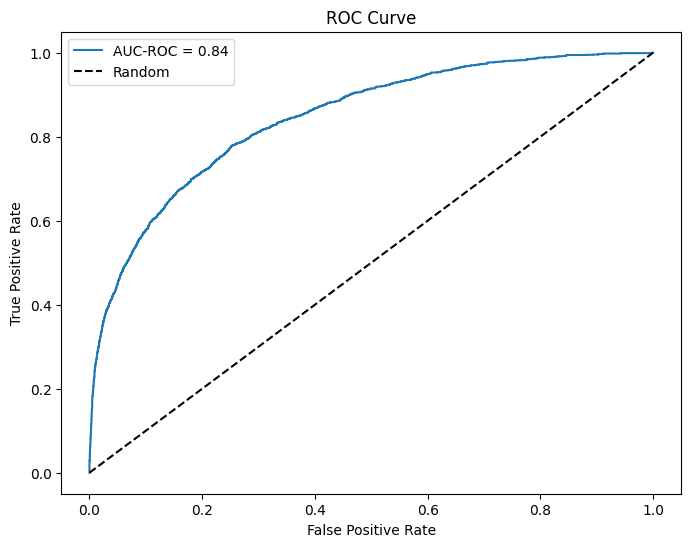

In [ ]:
X, y = test_preprocessing(p, preprocessing_method_1, scaler, has_y=True)
# plot_auc_roc(clf, X, y)
score(X, y,model_3)

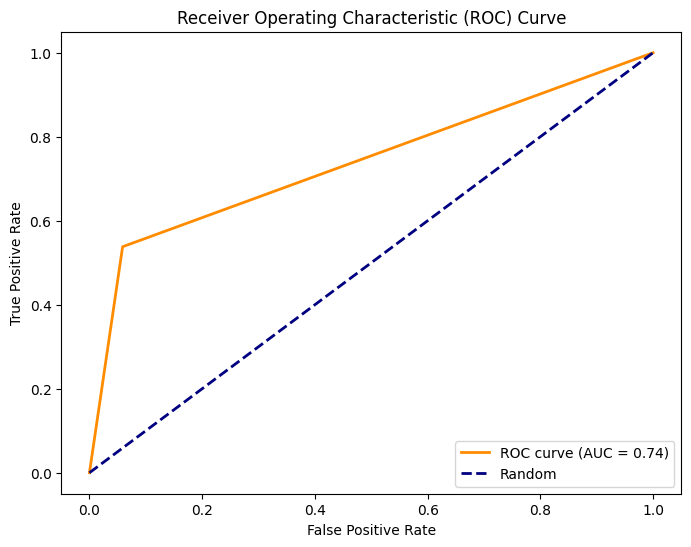

In [ ]:
plot_auc(clf, X, y)

In [ ]:
# scaler_2 = MinMaxScaler()
# x_train = scaler_2.fit_transform(df_2.drop('Exited', axis=1))
# lr2 = LogisticRegression()
# # lr2 = DummyClassifier(strategy='stratified')
# lr2.fit(x_train, df_2['Exited'])
# lr2.score(x_train, df_2['Exited'])

0.8260819472321433

## Test data visualization

In [ ]:
df_test = pd.read_csv('test.csv')
df_test.head()

id  CustomerId    Surname  CreditScore Geography  Gender   Age  Tenure  \
0  165034    15773898   Lucchese          586    France  Female  23.0       2   
1  165035    15782418       Nott          683    France  Female  46.0       2   
2  165036    15807120         K?          656    France  Female  34.0       7   
3  165037    15808905  O'Donnell          681    France    Male  36.0       8   
4  165038    15607314    Higgins          752   Germany    Male  38.0      10   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  
0       0.00              2        0.0             1.0        160976.75  
1       0.00              1        1.0             0.0         72549.27  
2       0.00              2        1.0             0.0        138882.09  
3       0.00              1        1.0             0.0        113931.57  
4  121263.62              1        1.0             0.0        139431.00

In [ ]:
df_test.shape

(110023, 13)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


### Submission

In [ ]:
def test_preprocessing(dataframe, preprocessor, scaler, has_y=False):
    df = preprocessor(dataframe,train=False)
    if has_y:
        return scaler.transform(df.drop('Exited', axis=1)), df['Exited']
    else:
        return scaler.transform(df)

df_test['Exited'] = np.zeros(shape=(len(df_test),))
X,y = test_preprocessing(df_test, preprocessing_method_1, scaler,has_y=True)

In [ ]:
# y = clf.predict_proba(X)[:,1]
y = lgbm.predict_proba(X)[:,1]
submission =  pd.DataFrame()
submission['id'] = df_test['id']
submission['Exited'] = y#y_predproba[1]
submission.to_csv("Submission_prob.csv",index=False)

In [ ]:
submission['Exited']= clf.predict(X)
submission.to_csv("Submission_val.csv",index=False)

In [ ]:
!kaggle competitions submit -c playground-series-s4e1 -f Submission_prob.csv -m "Probability model - Tenforflow 50 runs"

100% 2.83M/2.83M [00:02<00:00, 1.23MB/s]
Successfully submitted to Binary Classification with a Bank Churn Dataset 

In [ ]:
# !kaggle competitions submit -c playground-series-s4e1 -f Submission_val.csv -m "Valued model - gradient boosting"

100% 967k/967k [00:02<00:00, 454kB/s] 
Successfully submitted to Binary Classification with a Bank Churn Dataset 

In [ ]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok
import mlflow
# Set the MLflow tracking URI to localhost
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Run MLflow UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &")

# Create a public URL for accessing the UI
public_url = ngrok.connect(port="5000")
public_url


In [ ]:
!mlflow ui

/bin/bash: line 1: mlflow: command not found


In [ ]:

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
# ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2b6VnaMpH2CObuf5HhDv8WWT6ma_7ntvd3SYb8K6a8aHMEEn6"
NGROK_AUTH_TOKEN = "2b6VT1Cqhh6IZL9U6xpFuRkhcIM_4A8hqrSDAdQiCHuVVSLDi"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)


MLflow Tracking UI: https://9d1b-34-85-174-198.ngrok-free.app
